In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast  
from tqdm import tqdm 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
####################
# Dataset Class 
####################


class XRayDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        """
        Initializes dataset with CSV file and image folder.
        """
        self.csv = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform
        self.pairs = self.csv.groupby('uid')
        self.valid_uids = self.check_integrity()

    def check_integrity(self):
        """
        Ensure we have both 'Frontal' and 'Lateral' images for each UID.
        """
        valid_uids = []
        for uid, group in self.pairs:
            frontal_data = group[group['projection'] == 'Frontal']
            lateral_data = group[group['projection'] == 'Lateral']
            if not frontal_data.empty and not lateral_data.empty:
                valid_uids.append(uid)
        return valid_uids

    def __len__(self):
        return len(self.valid_uids)

    def __getitem__(self, idx):
        """
        Fetch the images for a specific UID.
        """
        group_key = self.valid_uids[idx]
        uid = self.pairs.get_group(group_key)

        frontal_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Frontal']['filename'].values[0])
        lateral_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Lateral']['filename'].values[0])

        frontal_img = cv2.imread(frontal_img_path)
        lateral_img = cv2.imread(lateral_img_path)

        if frontal_img is None or lateral_img is None:
            print(f"Error reading image: {frontal_img_path if frontal_img is None else lateral_img_path}")
            return None, None 

        frontal_img_resized = cv2.resize(frontal_img, (512, 512))
        lateral_img_resized = cv2.resize(lateral_img, (512, 512))

        frontal_img_tensor = torch.tensor(cv2.cvtColor(frontal_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        lateral_img_tensor = torch.tensor(cv2.cvtColor(lateral_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        frontal_img_tensor = frontal_img_tensor.permute(2, 0, 1)  
        lateral_img_tensor = lateral_img_tensor.permute(2, 0, 1)  


        return frontal_img_tensor, lateral_img_tensor

####################
# Generator3D 
####################


# Define the Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.Conv2d(in_channels + i * growth_rate, growth_rate, kernel_size=3, padding=1),
                nn.InstanceNorm2d(growth_rate),
                nn.ReLU(inplace=True)
            ))

    def forward(self, x):
        for layer in self.layers:
            new_features = layer(x)
            x = torch.cat([x, new_features], dim=1)
        return x

# Define the Basic3D Block
class Basic3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Basic3D, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Define 2D to 3D Connection (Connection-C)
class Connection2Dto3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Connection2Dto3D, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv3d = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv2d(x)
        x = x.unsqueeze(2)
        x = self.conv3d(x)
        return x


# Updated Generator to verify and propagate image size
class Generator(nn.Module):
    def __init__(self, in_channels, growth_rate, num_dense_layers, out_channels, image_size):
        super(Generator, self).__init__()

        self.image_size = image_size
        self.num_upconv_layers = int(torch.log2(torch.tensor(image_size // 4)).item())

        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            DenseBlock(growth_rate, growth_rate, num_dense_layers),
            nn.Conv2d(growth_rate * (num_dense_layers + 1), growth_rate, kernel_size=3, stride=2, padding=1)  # Compression
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            DenseBlock(growth_rate, growth_rate, num_dense_layers),
            nn.Conv2d(growth_rate * (num_dense_layers + 1), growth_rate, kernel_size=3, stride=2, padding=1)  # Compression
        )

        self.connection_a = Connection2Dto3D(growth_rate, growth_rate)
        self.connection_b = nn.Conv3d(growth_rate * 2, growth_rate, kernel_size=3, padding=1)
        self.connection_c = nn.Conv3d(growth_rate, growth_rate, kernel_size=3, padding=1)

        self.upconv_layers = nn.ModuleList()
        for _ in range(self.num_upconv_layers):
            self.upconv_layers.append(
                nn.Sequential(
                    nn.ConvTranspose3d(growth_rate, growth_rate, kernel_size=4, stride=2, padding=1),
                    nn.InstanceNorm3d(growth_rate),
                    nn.ReLU(inplace=True)
                )
            )

        self.final_layer = nn.Conv3d(growth_rate, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):

        x1 = self.encoder1(x1)
        x2 = self.encoder2(x2)
        x1 = self.connection_a(x1)
        x2 = self.connection_a(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.connection_b(x)
        for upconv in self.upconv_layers:
            x = upconv(x)

        x = self.final_layer(x)
        return x

####################
# Discriminator2D
####################
class Discriminator2D(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator2D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d((1,1))  
        )
        
    def forward(self, x):
        out = self.model(x)
        return out.view(-1) 

####################
# Loss Functions
####################
def projection_consistency_loss(generated_3d, frontal_input, lateral_input):
    """
    Calculate loss by comparing projections of the generated 3D shape 
    with the input frontal and lateral images.
    """
    frontal_input = frontal_input.mean(dim=1, keepdim=True)
    lateral_input = lateral_input.mean(dim=1, keepdim=True) 
    frontal_projection = generated_3d.sum(dim=2)
    lateral_projection = generated_3d.sum(dim=4) 

    frontal_projection = F.interpolate(frontal_projection, size=(512, 512), mode="bilinear", align_corners=False)
    lateral_projection = F.interpolate(lateral_projection, size=(512, 512), mode="bilinear", align_corners=False)

    frontal_loss = F.mse_loss(frontal_projection, frontal_input)
    lateral_loss = F.mse_loss(lateral_projection, lateral_input)

    return frontal_loss + lateral_loss, frontal_projection, lateral_projection

def shape_coherence_loss(generated_3d):
    """
    Regularize the 3D shape using Total Variation (TV) Loss to ensure smoothness.
    """
    # Differences along each dimension (TV loss components)
    dx = torch.abs(generated_3d[:, :, 1:, :, :] - generated_3d[:, :, :-1, :, :]).mean()
    dy = torch.abs(generated_3d[:, :, :, 1:, :] - generated_3d[:, :, :, :-1, :]).mean()
    dz = torch.abs(generated_3d[:, :, :, :, 1:] - generated_3d[:, :, :, :, :-1]).mean()
    
    # Total TV loss
    return dx + dy + dz

def adversarial_loss(disc_output, target_is_real=True):
    if target_is_real:
        # target of 1.0 for real
        targets = torch.ones_like(disc_output, device=disc_output.device)
    else:
        # target of 0.0 for fake
        targets = torch.zeros_like(disc_output, device=disc_output.device)
    return F.binary_cross_entropy_with_logits(disc_output, targets)

def compute_snr(real_img, fake_img):
    # Both in same scale, assume normalized 0-1
    mse = torch.mean((real_img - fake_img)**2)
    signal_power = torch.mean(real_img**2)
    if mse == 0:
        return float('inf')
    snr_value = 10 * math.log10((signal_power / mse).item())
    return snr_value


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paths and parameters
    img_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/images/images_normalized/'
    csv_file = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/indiana_projections.csv'
    
    batch_size = 32
    num_epochs = 90
    lambda_proj = 1.0
    lambda_shape = 0.01
    lambda_adv = 0.9

    dataset = XRayDataset(csv_file=csv_file, img_folder=img_folder)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = Generator3D().to(device)
    discriminator = Discriminator2D(input_channels=3).to(device)
    generator = nn.DataParallel(Generator3D()).to(device)
    discriminator = nn.DataParallel(Discriminator2D(input_channels=3)).to(device)


    scaler = GradScaler()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    all_loss_history = {
    "D Real Frontal Loss": [],
    "D Real Lateral Loss": [],
    "D Fake Frontal Loss": [],
    "D Fake Lateral Loss": [],
    "D Total Loss": [],
    "G Adversarial Loss": [],
    "G Projection Loss": [],
    "G Shape Coherence Loss": [],
    "G Total Loss": [],
    }

# Training loop
    best_loss = float('inf')
    best_loss_G = float('inf')
    best_loss_S = float('inf')
    best_loss_A = float('inf')
    for epoch in range(num_epochs):
        with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as tepoch:
            for i, (frontal_img_tensor, lateral_img_tensor) in enumerate(tepoch):
                frontal_img_tensor = frontal_img_tensor.to(device)
                lateral_img_tensor = lateral_img_tensor.to(device)

                # ----------------------
                # Train Discriminator
                # ----------------------
                d_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Real losses
                    real_frontal_out = discriminator(frontal_img_tensor)
                    d_real_frontal_loss = adversarial_loss(real_frontal_out, target_is_real=True)

                    real_lateral_out = discriminator(lateral_img_tensor)
                    d_real_lateral_loss = adversarial_loss(real_lateral_out, target_is_real=True)

                    # Fake losses
                    with torch.no_grad():
                        generated_3d = generator(frontal_img_tensor, lateral_img_tensor)
                    _, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)

                    fake_frontal_out = discriminator(fake_frontal_proj)
                    d_fake_frontal_loss = adversarial_loss(fake_frontal_out, target_is_real=False)

                    fake_lateral_out = discriminator(fake_lateral_proj)
                    d_fake_lateral_loss = adversarial_loss(fake_lateral_out, target_is_real=False)

                    # Total discriminator loss
                    d_loss = (
                        d_real_frontal_loss + d_real_lateral_loss + d_fake_frontal_loss + d_fake_lateral_loss
                    ) / 4
                    d_loss += 1e-4 * sum(p.pow(2.0).sum() for p in discriminator.parameters())

                # Backpropagate and update discriminator
                scaler.scale(d_loss).backward()
                scaler.step(d_optimizer)
                scaler.update()

                # ----------------------
                # Train Generator
                # ----------------------
                g_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Projection and shape losses
                    proj_loss, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    shape_loss = shape_coherence_loss(generated_3d)

                    # Adversarial loss
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)
                    g_frontal_out = discriminator(fake_frontal_proj)
                    g_lateral_out = discriminator(fake_lateral_proj)
                    g_adv_loss = (adversarial_loss(g_frontal_out, target_is_real=True) +
                                adversarial_loss(g_lateral_out, target_is_real=True)) / 2

                    # Dynamic loss weights
                    lambda_proj = 1.0 / (proj_loss.item() + 1e-8)
                    lambda_shape = 0.1 / (shape_loss.item() + 1e-8)
                    lambda_adv = 1.0 / (g_adv_loss.item() + 1e-8)
                    total_weight = lambda_proj + lambda_shape + lambda_adv
                    lambda_proj /= total_weight
                    lambda_shape /= total_weight
                    lambda_adv /= total_weight

                    # Total generator loss
                    total_g_loss = lambda_adv * g_adv_loss + lambda_proj * proj_loss + lambda_shape * shape_loss
                    total_g_loss += 1e-4 * sum(p.pow(2.0).sum() for p in generator.parameters())

                # Backpropagate and update generator
                scaler.scale(total_g_loss).backward()
                scaler.step(g_optimizer)
                scaler.update()
                
                #----------------------
                # Store all Losses
                #----------------------
                
                all_loss_history["D Real Frontal Loss"].append(d_real_frontal_loss.item())
                all_loss_history["D Real Lateral Loss"].append(d_real_lateral_loss.item())
                all_loss_history["D Fake Frontal Loss"].append(d_fake_frontal_loss.item())
                all_loss_history["D Fake Lateral Loss"].append(d_fake_lateral_loss.item())
                all_loss_history["D Total Loss"].append(d_loss.item())
                all_loss_history["G Adversarial Loss"].append(g_adv_loss.item())
                all_loss_history["G Projection Loss"].append(proj_loss.item())
                all_loss_history["G Shape Coherence Loss"].append(shape_loss.item())
                all_loss_history["G Total Loss"].append(total_g_loss.item())


                # ----------------------
                # Update TQDM Postfix
                # ----------------------
                tepoch.set_postfix({
                    "D Loss": f"{d_loss.item():.4f}",
                    "G Loss": f"{total_g_loss.item():.4f}",
                    "Proj Loss": f"{proj_loss.item():.4f}",
                    "Shape Loss": f"{shape_loss.item():.4f}",
                    "Adv Loss": f"{g_adv_loss.item():.4f}",
                })

                # Save the best generator
                if proj_loss.item() < best_loss:
                    best_loss = proj_loss.item()
                    torch.save(generator.state_dict(), "best_generator_projection.pth")
#                 if total_g_loss.item() < best_loss_G:
#                     best_loss = total_g_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_G_Loss.pth")
#                 if shape_loss.item() < best_loss_S:
#                     best_loss = shape_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_Shape_Loss.pth")
#                 if g_adv_loss.item() < best_loss_A:
#                     best_loss = g_adv_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_ADV_Loss.pth")

Epoch 90/90: 100%|██████████| 106/106 [05:54<00:00,  3.34s/batch, D Loss=0.0212, G Loss=0.0023, Proj Loss=24159.3477, Shape Loss=0.0000, Adv Loss=5.7843]


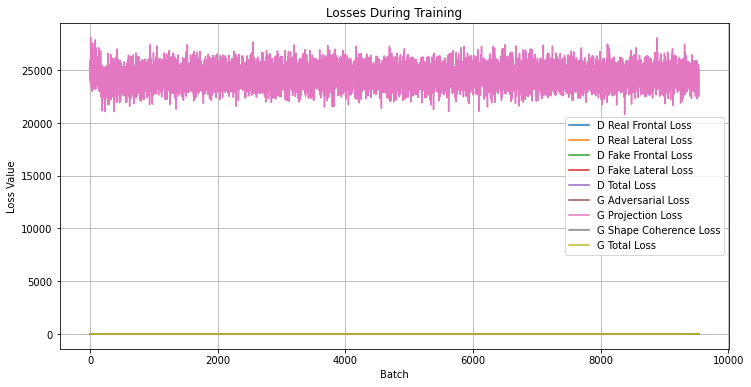

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for loss_name, loss_values in all_loss_history.items():
    plt.plot(loss_values, label=loss_name)

plt.xlabel("Batch")
plt.ylabel("Loss Value")
plt.title("Losses During Training")
plt.legend()
plt.grid(True)
plt.show()


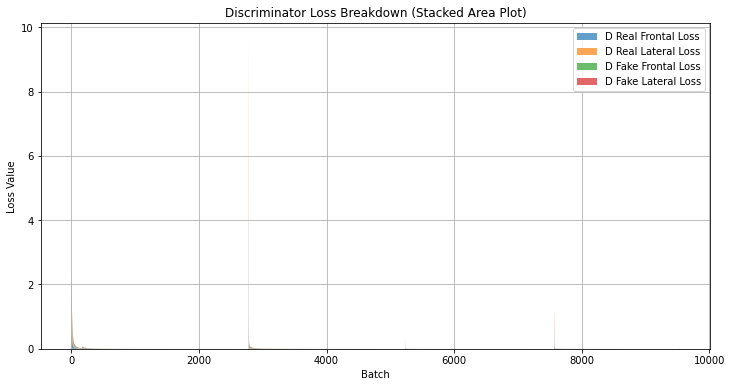

In [3]:
import numpy as np

loss_keys = ["D Real Frontal Loss", "D Real Lateral Loss", "D Fake Frontal Loss", "D Fake Lateral Loss"]
loss_values = np.array([all_loss_history[key] for key in loss_keys])
loss_values = np.array([loss[:min(map(len, loss_values))] for loss in loss_values])

plt.figure(figsize=(12, 6))
plt.stackplot(range(len(loss_values[0])), *loss_values, labels=loss_keys, alpha=0.7)

plt.xlabel("Batch")
plt.ylabel("Loss Value")
plt.title("Discriminator Loss Breakdown (Stacked Area Plot)")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(all_loss_history)

plt.figure(figsize=(12, 6))
sns.heatmap(df.T, cmap="coolwarm", annot=False, cbar=True)

plt.xlabel("Batch")
plt.ylabel("Loss Type")
plt.title("Loss Magnitudes Heatmap")
plt.show()


/share/pkg.7/python3/3.8.3/install/lib/python3.8/site-packages/seaborn/matrix.py:68: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.zeros(data.shape, np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<Figure size 864x432 with 0 Axes>

tensor([[[[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

          [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

          [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000

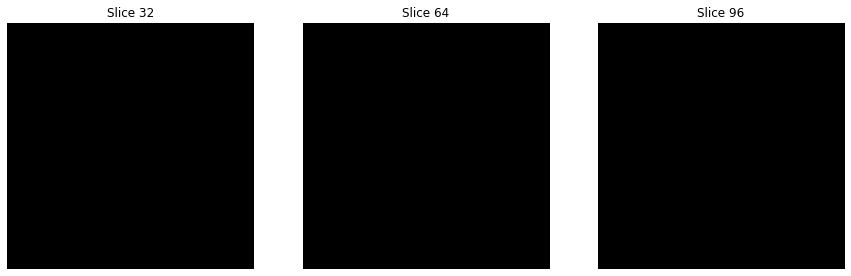

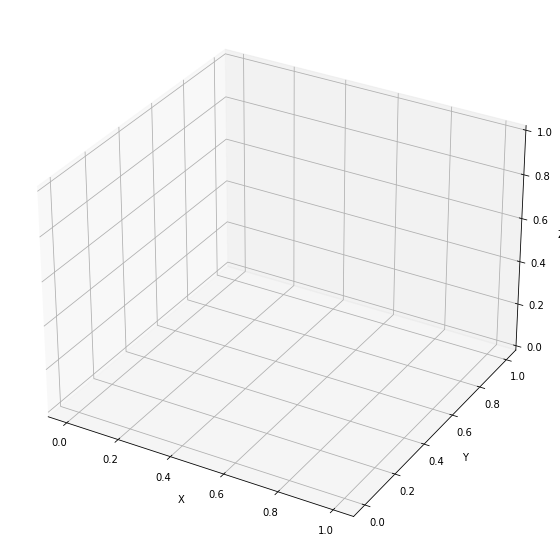

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# -----------------------
# Generator3D Class (same as in training)
# -----------------------
class Generator3D(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, intermediate_size=8, output_size=128):
        super(Generator3D, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((intermediate_size, intermediate_size))
        self.latent_fc = nn.Linear(512 * intermediate_size * intermediate_size, latent_dim * intermediate_size**3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(latent_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, frontal, lateral):
        frontal_features = self.encoder(frontal)
        lateral_features = self.encoder(lateral)
        combined_features = torch.cat((frontal_features, lateral_features), dim=1)
        pooled_features = self.global_avg_pool(combined_features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1) 
        latent_3d = F.relu(self.latent_fc(pooled_features))
        latent_3d = latent_3d.view(-1, 128, 8, 8, 8)
        voxel_grid = self.decoder(latent_3d)
        return voxel_grid


def load_image(image_path):
    """
    Loads an image from a given path, resizes to 512x512, converts to RGB, and returns as a tensor.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(0)  # (1,3,512,512)
    return img_tensor

def visualize_slices(voxel_grid):
    """
    Visualize three slices of the voxel grid.
    voxel_grid: numpy array (D, H, W)
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, idx in enumerate([32, 64, 96]):
        axs[i].imshow(voxel_grid[idx, :, :], cmap='gray')
        axs[i].set_title(f"Slice {idx}")
        axs[i].axis('off')
    plt.show()

def visualize_3d(voxel_grid):
    """
    Visualize voxel grid as a 3D scatter plot of points above a certain threshold.
    voxel_grid: numpy array (D, H, W)
    """
    binary_grid = (voxel_grid > 0.5).astype(int)
    x, y, z = np.where(binary_grid == 1)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, zdir='z', c='red', s=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


if __name__ == '__main__':
    # Paths to the trained model and test images
    model_path = "best_generator_projection.pth"
    frontal_image_path = "1001_IM-0004-1001.dcm.png"
    lateral_image_path = "1001_IM-0004-1002.dcm.png"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    generator2 = Generator3D().to(device)
    generator2 = nn.DataParallel(Generator3D()).to(device)
    generator2.load_state_dict(torch.load(model_path))
    generator2.eval()

    frontal_img_tensor = load_image(frontal_image_path).to(device)
    lateral_img_tensor = load_image(lateral_image_path).to(device)

    with torch.no_grad():
        output = generator2(frontal_img_tensor, lateral_img_tensor)
        print(output)

    voxel_grid = output.squeeze().detach().cpu().numpy()  # (D,H,W)
    visualize_slices(voxel_grid)
    visualize_3d(voxel_grid)

Epoch 1/10:   0%|          | 0/106 [00:00<?, ?batch/s]<ipython-input-1-79a61158ccd6>:164: UserWarning: Using a target size (torch.Size([32, 1, 512, 512])) that is different to the input size (torch.Size([32, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  frontal_loss = F.mse_loss(frontal_input, frontal_projection)
<ipython-input-1-79a61158ccd6>:165: UserWarning: Using a target size (torch.Size([32, 1, 512, 512])) that is different to the input size (torch.Size([32, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  lateral_loss = F.mse_loss(lateral_input, lateral_projection)
Epoch 1/10:  99%|█████████▉| 105/106 [07:24<00:04,  4.17s/batch, D Loss=2.8400, G Loss=10194.2744, Proj Loss=10194.2744, Shape Loss=0.0101, Adv Loss=0.7040]<ipython-input-1-79a61158ccd6>:164: UserWarning: Using a target size (torch.Size([28, 1, 512, 512])) that is different to th

(128, 128, 128)
<class 'numpy.ndarray'>


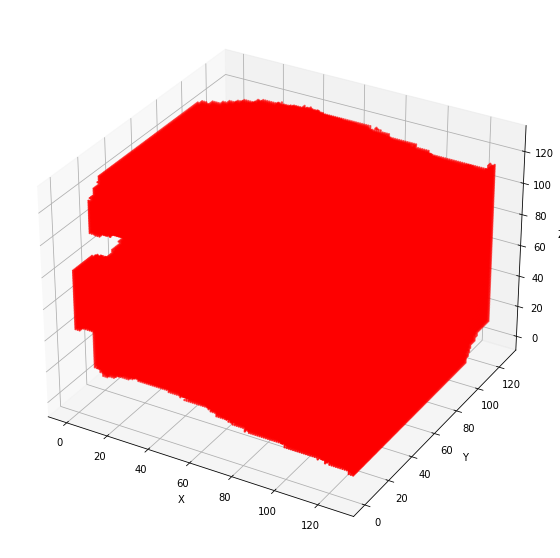

Epoch 2/10: 100%|██████████| 106/106 [07:10<00:00,  4.06s/batch, D Loss=2.7848, G Loss=9956.8613, Proj Loss=9956.8613, Shape Loss=0.0100, Adv Loss=0.7240]  


(128, 128, 128)
<class 'numpy.ndarray'>


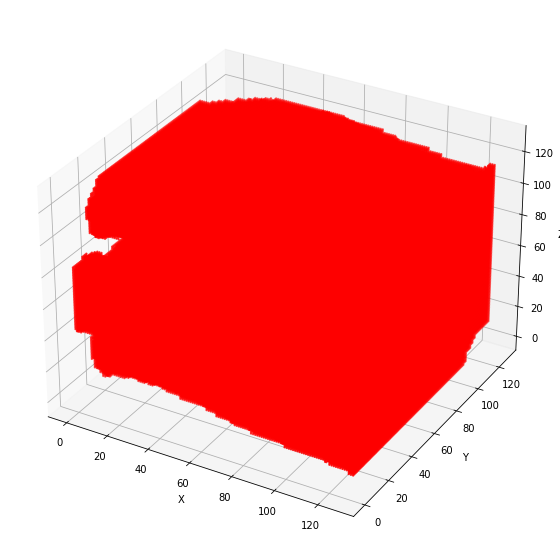

Epoch 3/10: 100%|██████████| 106/106 [07:11<00:00,  4.07s/batch, D Loss=2.7255, G Loss=10073.8574, Proj Loss=10073.8574, Shape Loss=0.0109, Adv Loss=0.7428]


(128, 128, 128)
<class 'numpy.ndarray'>


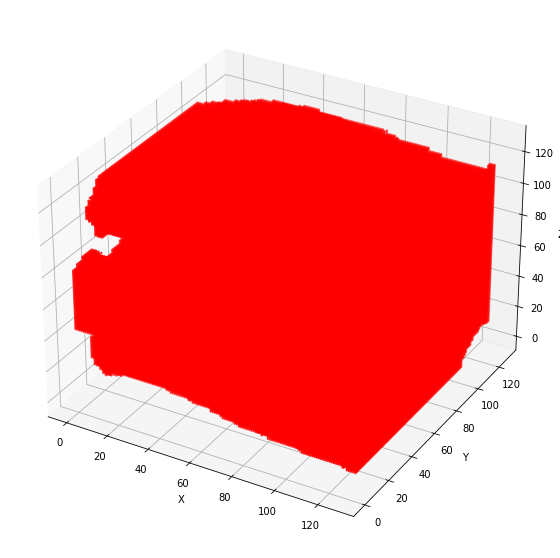

Epoch 4/10: 100%|██████████| 106/106 [07:10<00:00,  4.06s/batch, D Loss=2.6573, G Loss=10041.3809, Proj Loss=10041.3809, Shape Loss=0.0107, Adv Loss=0.7562]


(128, 128, 128)
<class 'numpy.ndarray'>


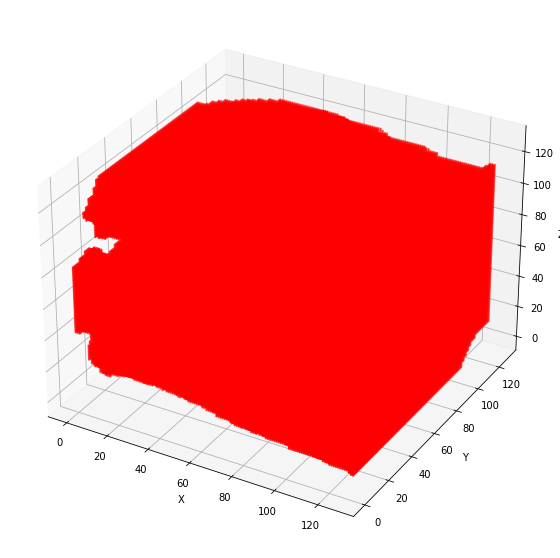

Epoch 5/10: 100%|██████████| 106/106 [07:10<00:00,  4.06s/batch, D Loss=2.6145, G Loss=10410.3682, Proj Loss=10410.3682, Shape Loss=0.0112, Adv Loss=0.7702]


(128, 128, 128)
<class 'numpy.ndarray'>


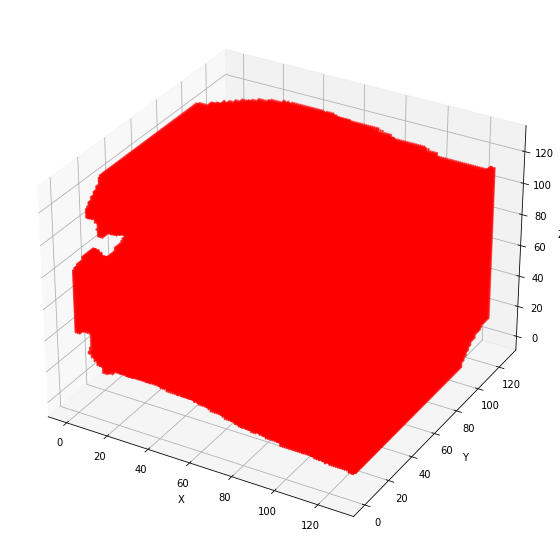

Epoch 6/10: 100%|██████████| 106/106 [07:09<00:00,  4.05s/batch, D Loss=2.5881, G Loss=10512.2754, Proj Loss=10512.2754, Shape Loss=0.0113, Adv Loss=0.7747]


(128, 128, 128)
<class 'numpy.ndarray'>


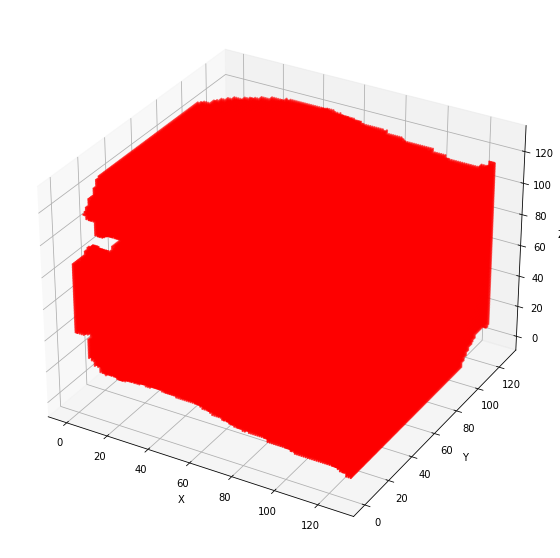

Epoch 7/10:   9%|▉         | 10/106 [00:42<06:44,  4.21s/batch, D Loss=2.5795, G Loss=10259.1797, Proj Loss=10259.1797, Shape Loss=0.0111, Adv Loss=0.7813]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/share/pkg.7/python3/3.8.3/install/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-79a61158ccd6>", line 311, in <module>
    for i, (frontal_img_tensor, lateral_img_tensor) in enumerate(tepoch):
  File "/share/pkg.7/python3/3.8.3/install/lib/python3.8/site-packages/tqdm/std.py", line 1129, in __iter__
    for obj in iterable:
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torch/utils/data/dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data

KeyboardInterrupt: 

In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast  
from tqdm import tqdm 
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
####################
# Dataset Class 
####################


class XRayDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        """
        Initializes dataset with CSV file and image folder.
        """
        self.csv = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform
        self.pairs = self.csv.groupby('uid')
        self.valid_uids = self.check_integrity()

    def check_integrity(self):
        """
        Ensure we have both 'Frontal' and 'Lateral' images for each UID.
        """
        valid_uids = []
        for uid, group in self.pairs:
            frontal_data = group[group['projection'] == 'Frontal']
            lateral_data = group[group['projection'] == 'Lateral']
            if not frontal_data.empty and not lateral_data.empty:
                valid_uids.append(uid)
        return valid_uids

    def __len__(self):
        return len(self.valid_uids)

    def __getitem__(self, idx):
        """
        Fetch the images for a specific UID.
        """
        group_key = self.valid_uids[idx]
        uid = self.pairs.get_group(group_key)

        frontal_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Frontal']['filename'].values[0])
        lateral_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Lateral']['filename'].values[0])

        frontal_img = cv2.imread(frontal_img_path)
        lateral_img = cv2.imread(lateral_img_path)

        if frontal_img is None or lateral_img is None:
            print(f"Error reading image: {frontal_img_path if frontal_img is None else lateral_img_path}")
            return None, None 

        frontal_img_resized = cv2.resize(frontal_img, (512, 512))
        lateral_img_resized = cv2.resize(lateral_img, (512, 512))

        frontal_img_tensor = torch.tensor(cv2.cvtColor(frontal_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        lateral_img_tensor = torch.tensor(cv2.cvtColor(lateral_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        frontal_img_tensor = frontal_img_tensor.permute(2, 0, 1)  
        lateral_img_tensor = lateral_img_tensor.permute(2, 0, 1)  


        return frontal_img_tensor, lateral_img_tensor

############################
# Image Encoder Definition #
############################

class SimpleImageEncoder(nn.Module):
    """
    A simple encoder that reduces a 512x512 image to a latent vector.
    You might replace this with a stronger backbone (e.g., ResNet50).
    """
    def __init__(self, latent_dim=512):
        super(SimpleImageEncoder, self).__init__()
        # A small CNN as a placeholder
        # Input: [B, 3, 512, 512]
        # Output: [B, latent_dim]
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # [B, 32, 256, 256]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # [B, 64, 128, 128]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),# [B,128, 64, 64]
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),# [B,256,32,32]
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1),# [B,512,16,16]
            nn.ReLU(True),
            nn.Conv2d(512, 512, 4, 2, 1),# [B,512,8,8]
            nn.ReLU(True),
            nn.Conv2d(512, 512, 4, 2, 1),# [B,512,4,4]
            nn.ReLU(True),
        )
        self.fc = nn.Linear(512*4*4, latent_dim)

    def forward(self, x):
        feat = self.features(x)
        feat = feat.view(feat.size(0), -1)
        feat = self.fc(feat)
        return feat

#######################
# Fusion Layer         #
#######################

class ViewFusion(nn.Module):
    """
    Fuse two latent vectors (from the frontal and lateral images).
    """
    def __init__(self, in_dim=512, out_dim=512):
        super(ViewFusion, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim*2, 512),
            nn.ReLU(True),
            nn.Linear(512, out_dim)
        )

    def forward(self, f_feat, l_feat):
        fused = torch.cat([f_feat, l_feat], dim=1)
        return self.fc(fused)

##########################
# 3D Voxel Decoder       #
##########################

class VoxelGenerator(nn.Module):
    """
    Decode a latent vector into a 3D voxel grid [B,1,128,128,128].
    We'll start from a small 3D latent representation and upsample.
    """
    def __init__(self, latent_dim=512, base_size=8, final_size=128):
        super(VoxelGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.base_size = base_size
        self.final_size = final_size

        # Number of upsampling steps from base_size to final_size:
        # base_size = 8, final_size = 128, we need 4x upscale steps (8->16->32->64->128)
        # We'll start from a latent vector and reshape to [B,512,8,8,8]

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * base_size * base_size * base_size),
            nn.ReLU(True)
        )

        # Upsample in 3D using ConvTranspose3d
        # Input: [B,512,8,8,8]
        # Steps: (512->256->128->64->1) with doubling spatial dims each step
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, 4, stride=2, padding=1), # 8->16
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, 4, stride=2, padding=1), #16->32
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 64, 4, stride=2, padding=1),  #32->64
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 32, 4, stride=2, padding=1),   #64->128
            nn.ReLU(True),
            nn.Conv3d(32, 1, 3, padding=1), # [B,1,128,128,128]
            nn.Sigmoid() 
        )

    def forward(self, z):
        base = self.fc(z) 
        base = base.view(-1, 512, self.base_size, self.base_size, self.base_size)
        voxels = self.decoder(base) 
        return voxels

##########################
# Full Generator Module  #
##########################

class Generator(nn.Module):
    """
    The full generator: encodes frontal and lateral images into latent codes,
    fuses them, and decodes into a 3D voxel volume.
    """
    def __init__(self, latent_dim=512):
        super(Generator, self).__init__()
        self.encoder = SimpleImageEncoder(latent_dim=latent_dim)
        self.fusion = ViewFusion(in_dim=latent_dim, out_dim=latent_dim)
        self.voxel_gen = VoxelGenerator(latent_dim=latent_dim, base_size=8, final_size=128)

    def forward(self, front_img, lat_img):
        # front_img, lat_img: [B,3,512,512]
        f_feat = self.encoder(front_img)  # [B,latent_dim]
        l_feat = self.encoder(lat_img)    # [B,latent_dim]
        z = self.fusion(f_feat, l_feat)   # [B,latent_dim]
        voxels = self.voxel_gen(z)        # [B,1,128,128,128]
        return voxels    
    
    
# ####################
# # Generator3D 
# ####################
# class Generator3D(nn.Module):
#     def __init__(self, input_channels=3, latent_dim=128, intermediate_size=8, output_size=128):
#         super(Generator3D, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#         )

#         self.global_avg_pool = nn.AdaptiveAvgPool2d((intermediate_size, intermediate_size))
#         self.latent_fc = nn.Linear(512 * intermediate_size * intermediate_size, latent_dim * intermediate_size**3)

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose3d(latent_dim, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(128),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(64),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(32),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, frontal, lateral):
#         # Process frontal and lateral images separately
#         frontal_features = self.encoder(frontal)
#         lateral_features = self.encoder(lateral)
#         combined_features = torch.cat((frontal_features, lateral_features), dim=1)
#         pooled_features = self.global_avg_pool(combined_features)
#         pooled_features = pooled_features.view(pooled_features.size(0), -1) 
#         latent_3d = F.relu(self.latent_fc(pooled_features))
#         latent_3d = latent_3d.view(-1, 128, 8, 8, 8)

#         voxel_grid = self.decoder(latent_3d)
#         return voxel_grid

####################
# Discriminator2D
####################
class Discriminator2D(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator2D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d((1,1))  
        )
        
    def forward(self, x):
        out = self.model(x)
        return out.view(-1) 

####################
# Loss Functions
####################
def projection_consistency_loss(generated_3d, frontal_input, lateral_input):
    """
    Calculate loss by comparing projections of the generated 3D shape 
    with the input frontal and lateral images.
    """
    frontal_input = frontal_input.mean(dim=1, keepdim=False)
    lateral_input = lateral_input.mean(dim=1, keepdim=False) 
    frontal_projection = generated_3d.sum(dim=2)
    lateral_projection = generated_3d.sum(dim=4) 

    frontal_projection = F.interpolate(frontal_projection, size=(512, 512), mode="bilinear", align_corners=False)
    lateral_projection = F.interpolate(lateral_projection, size=(512, 512), mode="bilinear", align_corners=False)

    frontal_loss = F.mse_loss(frontal_input, frontal_projection)
    lateral_loss = F.mse_loss(lateral_input, lateral_projection)

    return frontal_loss + lateral_loss, frontal_projection, lateral_projection

def shape_coherence_loss(generated_3d):
    """
    Regularize the 3D shape using Total Variation (TV) Loss to ensure smoothness.
    """
    # Differences along each dimension (TV loss components)
    dx = torch.abs(generated_3d[:, :, 1:, :, :] - generated_3d[:, :, :-1, :, :]).mean()
    dy = torch.abs(generated_3d[:, :, :, 1:, :] - generated_3d[:, :, :, :-1, :]).mean()
    dz = torch.abs(generated_3d[:, :, :, :, 1:] - generated_3d[:, :, :, :, :-1]).mean()
    
    # Total TV loss
    return dx + dy + dz

def adversarial_loss(disc_output, target_is_real=True):
    if target_is_real:
        # target of 1.0 for real
        targets = torch.ones_like(disc_output, device=disc_output.device)
    else:
        # target of 0.0 for fake
        targets = torch.zeros_like(disc_output, device=disc_output.device)
    return F.binary_cross_entropy_with_logits(disc_output, targets)

def compute_snr(real_img, fake_img):
    # Both in same scale, assume normalized 0-1
    mse = torch.mean((real_img - fake_img)**2)
    signal_power = torch.mean(real_img**2)
    if mse == 0:
        return float('inf')
    snr_value = 10 * math.log10((signal_power / mse).item())
    return snr_value

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# def visualize_slices(voxel_grid):
#     """
#     Visualize three slices of the voxel grid.
#     voxel_grid: numpy array (D, H, W)
#     """
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#     for i, idx in enumerate([32, 64, 96]):
#         axs[i].imshow(voxel_grid[idx, :, :], cmap='gray')
#         axs[i].set_title(f"Slice {idx}")
#         axs[i].axis('off')
#     plt.show()

def visualize_slices(voxel_grid):
    """
    Visualize a single slice of the voxel grid.
    If the input is 3D (D, H, W), it will visualize one slice from the middle of the depth.
    If the input is 2D (H, W), it will visualize the whole image.

    voxel_grid: numpy array (D, H, W) or (H, W)
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if len(voxel_grid.shape) == 3:  # If it's a 3D voxel grid (D, H, W)
        middle_depth = voxel_grid.shape[0] // 2  # Take the middle slice
        for i in range(3):
            axs[i].imshow(voxel_grid[middle_depth, :, :], cmap='gray')
            axs[i].set_title(f"Slice {middle_depth}")
            axs[i].axis('off')
    elif len(voxel_grid.shape) == 2:  # If it's a 2D grid (H, W)
        axs[0].imshow(voxel_grid, cmap='gray')
        axs[0].set_title(f"Full Slice")
        axs[0].axis('off')
        for i in range(1, 3):
            axs[i].axis('off')
            axs[i].set_title("N/A")
    else:
        raise ValueError("Input voxel_grid must have 2 or 3 dimensions")

    plt.show()


def visualize_3d(voxel_grid):
    """
    Visualize voxel grid as a 3D scatter plot of points above a certain threshold.
    voxel_grid: numpy array (D, H, W)
    """
    binary_grid = (voxel_grid > 0.5).astype(int)
    x, y, z = np.where(binary_grid == 1)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, zdir='z', c='red', s=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paths and parameters
    img_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/images/images_normalized/'
    csv_file = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/indiana_projections.csv'
    
    batch_size = 32
    num_epochs = 10
    lambda_proj = 1.0
    lambda_shape = 0.0
    lambda_adv = 0.00001

    dataset = XRayDataset(csv_file=csv_file, img_folder=img_folder)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = Generator().to(device)
    discriminator = Discriminator2D(input_channels=3).to(device)
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    scaler = GradScaler()
    dscaler = GradScaler()
    g_optimizer = torch.optim.AdamW(generator.parameters(), lr=1e-3, betas=(0.8, 0.999))
    d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=1e-7, betas=(0.8, 0.999))
    all_loss_history = {
    "D Real Frontal Loss": [],
    "D Real Lateral Loss": [],
    "D Fake Frontal Loss": [],
    "D Fake Lateral Loss": [],
    "D Total Loss": [],
    "G Adversarial Loss": [],
    "G Projection Loss": [],
    "G Shape Coherence Loss": [],
    "G Total Loss": [],
    }

# Training loop
    best_loss = float('inf')
    best_loss_G = float('inf')
    best_loss_S = float('inf')
    best_loss_A = float('inf')
    for epoch in range(num_epochs):
        with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as tepoch:
            for i, (frontal_img_tensor, lateral_img_tensor) in enumerate(tepoch):
                frontal_img_tensor = frontal_img_tensor.to(device)
                lateral_img_tensor = lateral_img_tensor.to(device)

                # ----------------------
                # Train Discriminator
                # ----------------------
                d_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Real losses
                    real_frontal_out = discriminator(frontal_img_tensor)
                    d_real_frontal_loss = adversarial_loss(real_frontal_out, target_is_real=True)

                    real_lateral_out = discriminator(lateral_img_tensor)
                    d_real_lateral_loss = adversarial_loss(real_lateral_out, target_is_real=True)

                    # Fake losses
#                     with torch.no_grad():
                    generated_3d = generator(frontal_img_tensor, lateral_img_tensor)
                    _, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)

                    fake_frontal_out = discriminator(fake_frontal_proj)
                    d_fake_frontal_loss = adversarial_loss(fake_frontal_out, target_is_real=False)

                    fake_lateral_out = discriminator(fake_lateral_proj)
                    d_fake_lateral_loss = adversarial_loss(fake_lateral_out, target_is_real=False)

                    # Total discriminator loss
                    d_loss = (
                        d_real_frontal_loss + d_real_lateral_loss + d_fake_frontal_loss + d_fake_lateral_loss
                    )
#                     d_loss += 1e-4 * sum(p.pow(2.0).sum() for p in discriminator.parameters())

                # Backpropagate and update discriminator
                scaler.scale(d_loss).backward(retain_graph=True)
                scaler.step(d_optimizer)
                scaler.update()

                # ----------------------
                # Train Generator
                # ----------------------
                g_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Projection and shape losses
                    proj_loss, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    shape_loss = shape_coherence_loss(generated_3d)

                    # Adversarial loss
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)
                    g_frontal_out = discriminator(fake_frontal_proj)
                    g_lateral_out = discriminator(fake_lateral_proj)
                    g_adv_loss = (adversarial_loss(g_frontal_out, target_is_real=True) +
                                adversarial_loss(g_lateral_out, target_is_real=True)) / 2

                    # Dynamic loss weights
#                     lambda_proj = 1.0 / (proj_loss.item() + 1e-8)
#                     lambda_shape = 0.1 / (shape_loss.item() + 1e-8)
#                     lambda_adv = 1.0 / (g_adv_loss.item() + 1e-8)
#                     total_weight = lambda_proj + lambda_shape + lambda_adv
#                     lambda_proj /= total_weight
#                     lambda_shape /= total_weight
#                     lambda_adv /= total_weight

                    # Total generator loss
                    total_g_loss = lambda_adv * g_adv_loss + lambda_proj * proj_loss + lambda_shape * shape_loss
#                     print(total_g_loss)
#                     total_g_loss += 1e-4 * sum(p.pow(2.0).sum() for p in generator.parameters())

                # Backpropagate and update generator
                scaler.scale(total_g_loss).backward()
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)  
                scaler.step(g_optimizer)
                scaler.update()
                
                #----------------------
                # Store all Losses
                #----------------------
                
                all_loss_history["D Real Frontal Loss"].append(d_real_frontal_loss.item())
                all_loss_history["D Real Lateral Loss"].append(d_real_lateral_loss.item())
                all_loss_history["D Fake Frontal Loss"].append(d_fake_frontal_loss.item())
                all_loss_history["D Fake Lateral Loss"].append(d_fake_lateral_loss.item())
                all_loss_history["D Total Loss"].append(d_loss.item())
                all_loss_history["G Adversarial Loss"].append(g_adv_loss.item())
                all_loss_history["G Projection Loss"].append(proj_loss.item())
                all_loss_history["G Shape Coherence Loss"].append(shape_loss.item())
                all_loss_history["G Total Loss"].append(total_g_loss.item())


                # ----------------------
                # Update TQDM Postfix
                # ----------------------
                tepoch.set_postfix({
                    "D Loss": f"{d_loss.item():.4f}",
                    "G Loss": f"{total_g_loss.item():.4f}",
                    "Proj Loss": f"{proj_loss.item():.4f}",
                    "Shape Loss": f"{shape_loss.item():.4f}",
                    "Adv Loss": f"{g_adv_loss.item():.4f}",
                })
                
                with torch.no_grad():
                    output = generator(frontal_img_tensor, lateral_img_tensor)

                # Iterate over the batch
            for i in range(output.shape[0]):
                if i == 1:
                    sample = output[i, :, :, :, :]
                    sample = sample.squeeze().detach().cpu().numpy()
                    print(sample.shape)
                    print(type(sample))
                    voxel_grid = sample
                    visualize_3d(voxel_grid)
#                 voxel_grid = output.squeeze().detach().cpu().numpy()  # (D,H,W)
#                 visualize_3d(voxel_grid)

                # Save the best generator
#                 if proj_loss.item() < best_loss:
#                     best_loss = proj_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_projection.pth")
#                 if total_g_loss.item() < best_loss_G:
#                     best_loss = total_g_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_G_Loss.pth")
#                 if shape_loss.item() < best_loss_S:
#                     best_loss = shape_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_Shape_Loss.pth")
#                 if g_adv_loss.item() < best_loss_A:
#                     best_loss = g_adv_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_ADV_Loss.pth")
    torch.save(generator.state_dict(), "best_generator_ADV_Loss.pth")

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast  
from tqdm import tqdm 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
####################
# Dataset Class 
####################


class XRayDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        """
        Initializes dataset with CSV file and image folder.
        """
        self.csv = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform
        self.pairs = self.csv.groupby('uid')
        self.valid_uids = self.check_integrity()

    def check_integrity(self):
        """
        Ensure we have both 'Frontal' and 'Lateral' images for each UID.
        """
        valid_uids = []
        for uid, group in self.pairs:
            frontal_data = group[group['projection'] == 'Frontal']
            lateral_data = group[group['projection'] == 'Lateral']
            if not frontal_data.empty and not lateral_data.empty:
                valid_uids.append(uid)
        return valid_uids

    def __len__(self):
        return len(self.valid_uids)

    def __getitem__(self, idx):
        """
        Fetch the images for a specific UID.
        """
        group_key = self.valid_uids[idx]
        uid = self.pairs.get_group(group_key)

        frontal_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Frontal']['filename'].values[0])
        lateral_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Lateral']['filename'].values[0])

        frontal_img = cv2.imread(frontal_img_path)
        lateral_img = cv2.imread(lateral_img_path)

        if frontal_img is None or lateral_img is None:
            print(f"Error reading image: {frontal_img_path if frontal_img is None else lateral_img_path}")
            return None, None 

        frontal_img_resized = cv2.resize(frontal_img, (512, 512))
        lateral_img_resized = cv2.resize(lateral_img, (512, 512))

        frontal_img_tensor = torch.tensor(cv2.cvtColor(frontal_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        lateral_img_tensor = torch.tensor(cv2.cvtColor(lateral_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        frontal_img_tensor = frontal_img_tensor.permute(2, 0, 1)  
        lateral_img_tensor = lateral_img_tensor.permute(2, 0, 1)  


        return frontal_img_tensor, lateral_img_tensor

####################
# Generator3D 
####################
class Generator3D(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, intermediate_size=8, output_size=128):
        super(Generator3D, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((intermediate_size, intermediate_size))
        self.latent_fc = nn.Linear(512 * intermediate_size * intermediate_size, latent_dim * intermediate_size**3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(latent_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, frontal, lateral):
        # Process frontal and lateral images separately
        frontal_features = self.encoder(frontal)
        lateral_features = self.encoder(lateral)
        combined_features = torch.cat((frontal_features, lateral_features), dim=1)
        pooled_features = self.global_avg_pool(combined_features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1) 
        latent_3d = F.relu(self.latent_fc(pooled_features))
        latent_3d = latent_3d.view(-1, 128, 8, 8, 8)

        voxel_grid = self.decoder(latent_3d)
        return voxel_grid

####################
# Discriminator2D
####################
class Discriminator2D(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator2D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d((1,1))  
        )
        
    def forward(self, x):
        out = self.model(x)
        return out.view(-1) 

####################
# Loss Functions
####################
def projection_consistency_loss(generated_3d, frontal_input, lateral_input):
    """
    Calculate loss by comparing projections of the generated 3D shape 
    with the input frontal and lateral images.
    """
    frontal_input = frontal_input.mean(dim=1, keepdim=True)
    lateral_input = lateral_input.mean(dim=1, keepdim=True) 
    frontal_projection = generated_3d.sum(dim=2)
    lateral_projection = generated_3d.sum(dim=4) 

    frontal_projection = F.interpolate(frontal_projection, size=(512, 512), mode="bilinear", align_corners=False)
    lateral_projection = F.interpolate(lateral_projection, size=(512, 512), mode="bilinear", align_corners=False)

    frontal_loss = F.mse_loss(frontal_projection, frontal_input)
    lateral_loss = F.mse_loss(lateral_projection, lateral_input)

    return frontal_loss + lateral_loss, frontal_projection, lateral_projection

def shape_coherence_loss(generated_3d):
    """
    Regularize the 3D shape using Total Variation (TV) Loss to ensure smoothness.
    """
    # Differences along each dimension (TV loss components)
    dx = torch.abs(generated_3d[:, :, 1:, :, :] - generated_3d[:, :, :-1, :, :]).mean()
    dy = torch.abs(generated_3d[:, :, :, 1:, :] - generated_3d[:, :, :, :-1, :]).mean()
    dz = torch.abs(generated_3d[:, :, :, :, 1:] - generated_3d[:, :, :, :, :-1]).mean()
    
    # Total TV loss
    return dx + dy + dz

def adversarial_loss(disc_output, target_is_real=True):
    if target_is_real:
        # target of 1.0 for real
        targets = torch.ones_like(disc_output, device=disc_output.device)
    else:
        # target of 0.0 for fake
        targets = torch.zeros_like(disc_output, device=disc_output.device)
    return F.binary_cross_entropy_with_logits(disc_output, targets)

def compute_snr(real_img, fake_img):
    # Both in same scale, assume normalized 0-1
    mse = torch.mean((real_img - fake_img)**2)
    signal_power = torch.mean(real_img**2)
    if mse == 0:
        return float('inf')
    snr_value = 10 * math.log10((signal_power / mse).item())
    return snr_value


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paths and parameters
    img_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/images/images_normalized/'
    csv_file = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/indiana_projections.csv'
    
    batch_size = 32
    num_epochs = 10
    lambda_proj = 0.0001
    lambda_shape = 1.0
    lambda_adv = 0.1

    dataset = XRayDataset(csv_file=csv_file, img_folder=img_folder)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = Generator3D().to(device)
    discriminator = Discriminator2D(input_channels=3).to(device)
    generator = nn.DataParallel(Generator3D()).to(device)
    discriminator = nn.DataParallel(Discriminator2D(input_channels=3)).to(device)


    scaler = GradScaler()
    g_optimizer = torch.optim.AdamW(generator.parameters(), lr=1e-3, betas=(0.8, 0.999))
    d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=1e-4, betas=(0.8, 0.999))
    all_loss_history = {
    "D Real Frontal Loss": [],
    "D Real Lateral Loss": [],
    "D Fake Frontal Loss": [],
    "D Fake Lateral Loss": [],
    "D Total Loss": [],
    "G Adversarial Loss": [],
    "G Projection Loss": [],
    "G Shape Coherence Loss": [],
    "G Total Loss": [],
    }

# Training loop
    best_loss = float('inf')
    best_loss_G = float('inf')
    best_loss_S = float('inf')
    best_loss_A = float('inf')
    for epoch in range(num_epochs):
        with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as tepoch:
            for i, (frontal_img_tensor, lateral_img_tensor) in enumerate(tepoch):
                frontal_img_tensor = frontal_img_tensor.to(device)
                lateral_img_tensor = lateral_img_tensor.to(device)

                # ----------------------
                # Train Discriminator
                # ----------------------
                d_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Real losses
                    real_frontal_out = discriminator(frontal_img_tensor)
                    d_real_frontal_loss = adversarial_loss(real_frontal_out, target_is_real=True)

                    real_lateral_out = discriminator(lateral_img_tensor)
                    d_real_lateral_loss = adversarial_loss(real_lateral_out, target_is_real=True)

                    # Fake losses
                    with torch.no_grad():
                        generated_3d = generator(frontal_img_tensor, lateral_img_tensor)
                    _, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)

                    fake_frontal_out = discriminator(fake_frontal_proj)
                    d_fake_frontal_loss = adversarial_loss(fake_frontal_out, target_is_real=False)

                    fake_lateral_out = discriminator(fake_lateral_proj)
                    d_fake_lateral_loss = adversarial_loss(fake_lateral_out, target_is_real=False)

                    # Total discriminator loss
                    d_loss = (
                        d_real_frontal_loss + d_real_lateral_loss + d_fake_frontal_loss + d_fake_lateral_loss
                    ) / 4
                    d_loss += 1e-4 * sum(p.pow(2.0).sum() for p in discriminator.parameters())

                # Backpropagate and update discriminator
                scaler.scale(d_loss).backward()
                scaler.step(d_optimizer)
                scaler.update()

                # ----------------------
                # Train Generator
                # ----------------------
                g_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Projection and shape losses
                    proj_loss, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    shape_loss = shape_coherence_loss(generated_3d)

                    # Adversarial loss
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)
                    g_frontal_out = discriminator(fake_frontal_proj)
                    g_lateral_out = discriminator(fake_lateral_proj)
                    g_adv_loss = (adversarial_loss(g_frontal_out, target_is_real=True) +
                                adversarial_loss(g_lateral_out, target_is_real=True)) / 2

                    # Dynamic loss weights
                    lambda_proj = 1.0 / (proj_loss.item() + 1e-8)
                    lambda_shape = 0.1 / (shape_loss.item() + 1e-8)
                    lambda_adv = 1.0 / (g_adv_loss.item() + 1e-8)
                    total_weight = lambda_proj + lambda_shape + lambda_adv
                    lambda_proj /= total_weight
                    lambda_shape /= total_weight
                    lambda_adv /= total_weight

                    # Total generator loss
                    total_g_loss = lambda_adv * g_adv_loss + lambda_proj * proj_loss + lambda_shape * shape_loss
                    total_g_loss += 1e-4 * sum(p.pow(2.0).sum() for p in generator.parameters())

                # Backpropagate and update generator
                scaler.scale(total_g_loss).backward()
                scaler.step(g_optimizer)
                scaler.update()
                
                #----------------------
                # Store all Losses
                #----------------------
                
                all_loss_history["D Real Frontal Loss"].append(d_real_frontal_loss.item())
                all_loss_history["D Real Lateral Loss"].append(d_real_lateral_loss.item())
                all_loss_history["D Fake Frontal Loss"].append(d_fake_frontal_loss.item())
                all_loss_history["D Fake Lateral Loss"].append(d_fake_lateral_loss.item())
                all_loss_history["D Total Loss"].append(d_loss.item())
                all_loss_history["G Adversarial Loss"].append(g_adv_loss.item())
                all_loss_history["G Projection Loss"].append(proj_loss.item())
                all_loss_history["G Shape Coherence Loss"].append(shape_loss.item())
                all_loss_history["G Total Loss"].append(total_g_loss.item())


                # ----------------------
                # Update TQDM Postfix
                # ----------------------
                tepoch.set_postfix({
                    "D Loss": f"{d_loss.item():.4f}",
                    "G Loss": f"{total_g_loss.item():.4f}",
                    "Proj Loss": f"{proj_loss.item():.4f}",
                    "Shape Loss": f"{shape_loss.item():.4f}",
                    "Adv Loss": f"{g_adv_loss.item():.4f}",
                })

                # Save the best generator
#                 if proj_loss.item() < best_loss:
#                     best_loss = proj_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_projection.pth")
#                 if total_g_loss.item() < best_loss_G:
#                     best_loss = total_g_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_G_Loss.pth")
                if shape_loss.item() < best_loss_S:
                    best_loss = shape_loss.item()
                    torch.save(generator.state_dict(), "best_generator_Shape_Loss.pth")
#                 if g_adv_loss.item() < best_loss_A:
#                     best_loss = g_adv_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_ADV_Loss.pth")
    torch.save(generator.state_dict(), "best_generator_Shape_Loss.pth")

Epoch 1/1900:   1%|          | 1/106 [00:10<18:41, 10.68s/batch, D Loss=2.9827, G Loss=23671.1250, Proj Loss=12544.7324, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   2%|▏         | 2/106 [00:14<14:43,  8.50s/batch, D Loss=2.9730, G Loss=23924.7148, Proj Loss=12595.4482, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   3%|▎         | 3/106 [00:16<11:40,  6.80s/batch, D Loss=2.9852, G Loss=22961.1504, Proj Loss=12521.0020, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   4%|▍         | 4/106 [00:20<09:46,  5.75s/batch, D Loss=2.9782, G Loss=23935.5234, Proj Loss=12829.7852, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   5%|▍         | 5/106 [00:23<08:15,  4.91s/batch, D Loss=2.9675, G Loss=25836.6523, Proj Loss=13329.9453, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   6%|▌         | 6/106 [00:26<07:11,  4.31s/batch, D Loss=2.9771, G Loss=24205.9336, Proj Loss=12623.5430, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   7%|▋         | 7/106 [00:29<06:26,  3.90s/batch, D Loss=2.9742, G Loss=25082.7344, Proj Loss=13214.9072, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   8%|▊         | 8/106 [00:31<05:53,  3.60s/batch, D Loss=2.9744, G Loss=25426.5000, Proj Loss=13085.1045, Shape Loss=0.0004, Adv Loss=0.7368]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   8%|▊         | 9/106 [00:34<05:29,  3.40s/batch, D Loss=2.9866, G Loss=25029.8750, Proj Loss=13024.9004, Shape Loss=0.0004, Adv Loss=0.7368]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:   9%|▉         | 10/106 [00:37<05:11,  3.25s/batch, D Loss=2.9864, G Loss=23773.8281, Proj Loss=12730.2334, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:  10%|█         | 11/106 [00:40<05:01,  3.17s/batch, D Loss=2.9706, G Loss=24832.3711, Proj Loss=12421.8438, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:  11%|█▏        | 12/106 [00:43<04:49,  3.08s/batch, D Loss=2.9782, G Loss=23818.1016, Proj Loss=12959.6260, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900:  12%|█▏        | 13/106 [00:46<04:42,  3.03s/batch, D Loss=2.9823, G Loss=25022.2656, Proj Loss=12799.9092, Shape Loss=0.0004, Adv Loss=0.7369]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 1/1900: 100%|██████████| 106/106 [05:16<00:00,  2.99s/batch, D Loss=2.9382, G Loss=10365.7803, Proj Loss=4823.7285, Shape Loss=0.0297, Adv Loss=0.7582]


(128, 128, 128)
<class 'numpy.ndarray'>


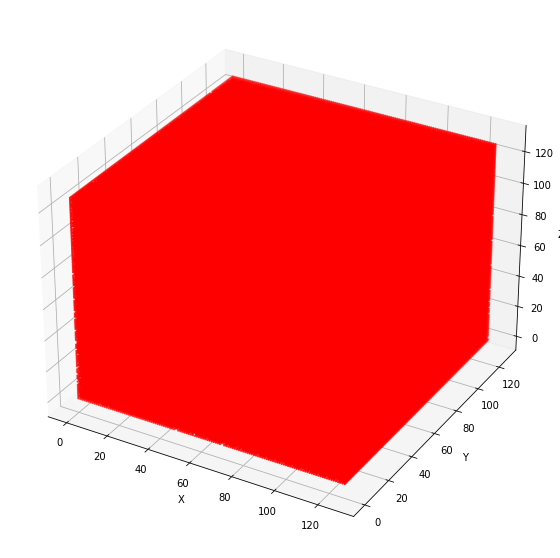

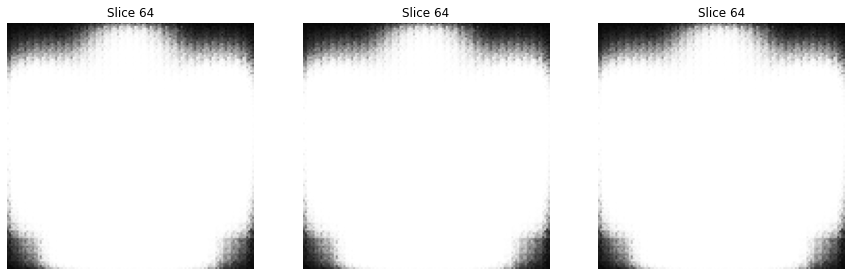

Epoch 2/1900: 100%|██████████| 106/106 [04:57<00:00,  2.81s/batch, D Loss=2.9386, G Loss=9433.7617, Proj Loss=4373.0923, Shape Loss=0.0170, Adv Loss=0.7676] 


(128, 128, 128)
<class 'numpy.ndarray'>


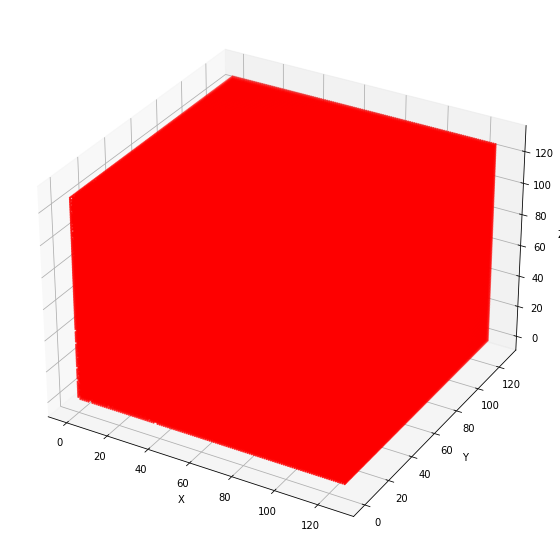

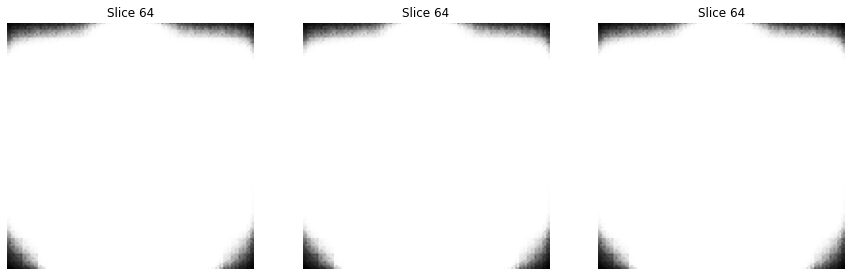

Epoch 3/1900: 100%|██████████| 106/106 [04:57<00:00,  2.81s/batch, D Loss=2.9276, G Loss=9489.7754, Proj Loss=4451.4443, Shape Loss=0.0162, Adv Loss=0.7650]


(128, 128, 128)
<class 'numpy.ndarray'>


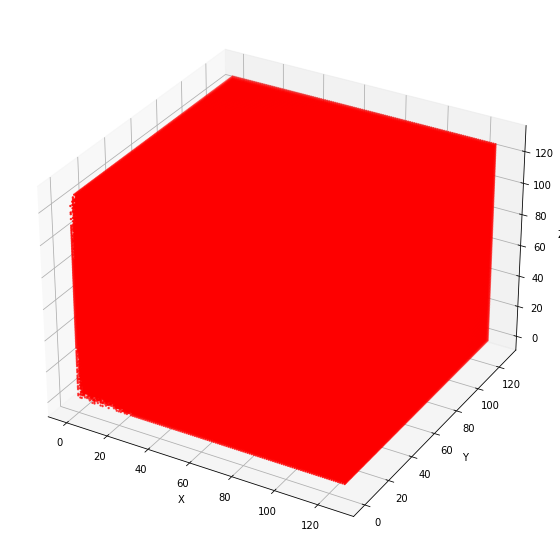

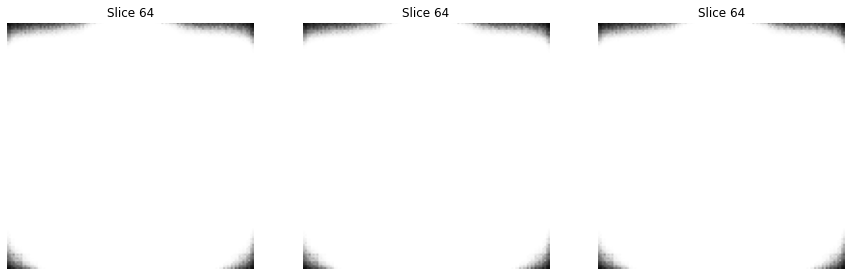

Epoch 4/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.9107, G Loss=9104.7793, Proj Loss=4310.2881, Shape Loss=0.0681, Adv Loss=0.7788]


(128, 128, 128)
<class 'numpy.ndarray'>


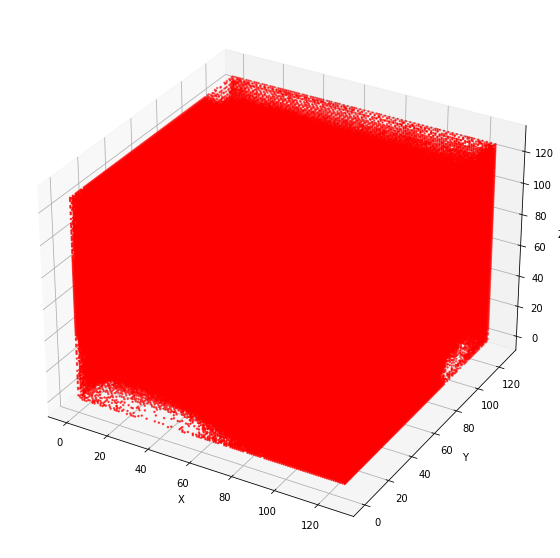

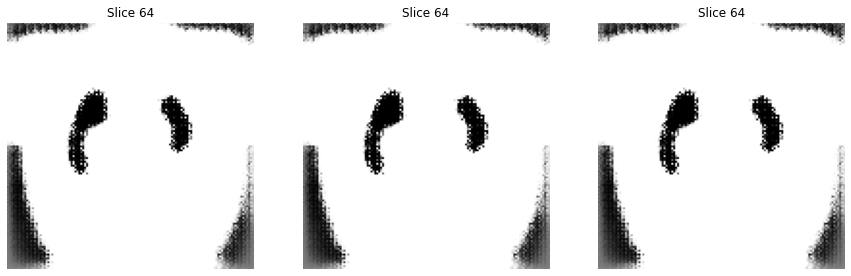

Epoch 5/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9287, G Loss=9151.8223, Proj Loss=4264.4692, Shape Loss=0.0542, Adv Loss=0.7679]


(128, 128, 128)
<class 'numpy.ndarray'>


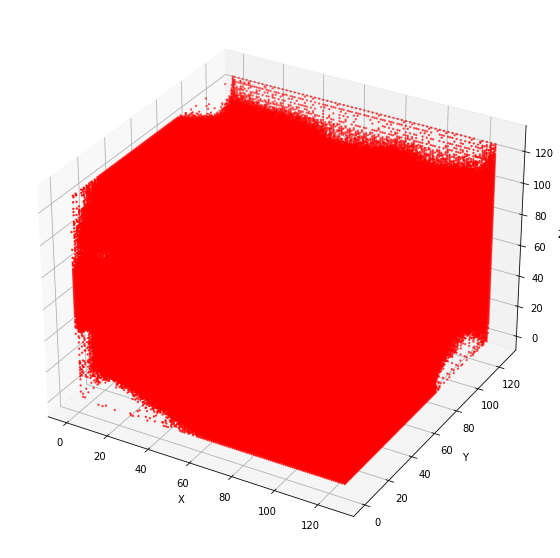

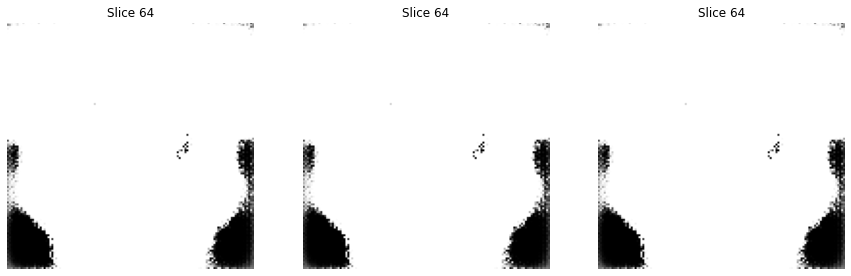

Epoch 6/1900: 100%|██████████| 106/106 [04:58<00:00,  2.81s/batch, D Loss=2.9098, G Loss=9759.7656, Proj Loss=4585.9272, Shape Loss=0.0545, Adv Loss=0.7747]


(128, 128, 128)
<class 'numpy.ndarray'>


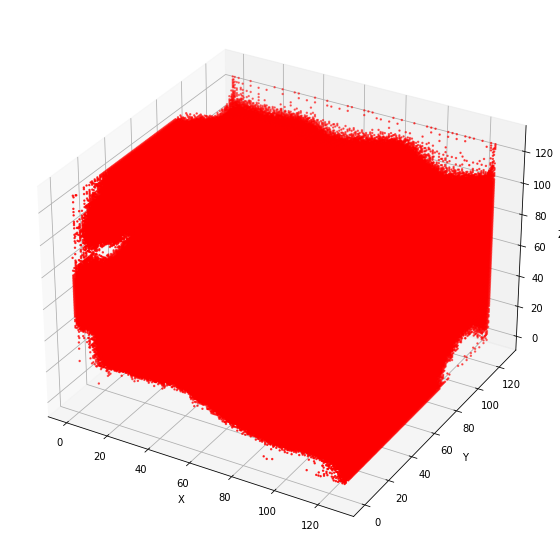

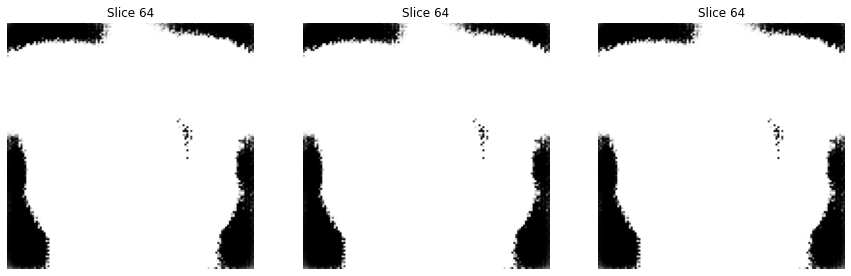

Epoch 7/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=2.9178, G Loss=9612.5156, Proj Loss=4518.7261, Shape Loss=0.0563, Adv Loss=0.7801]


(128, 128, 128)
<class 'numpy.ndarray'>


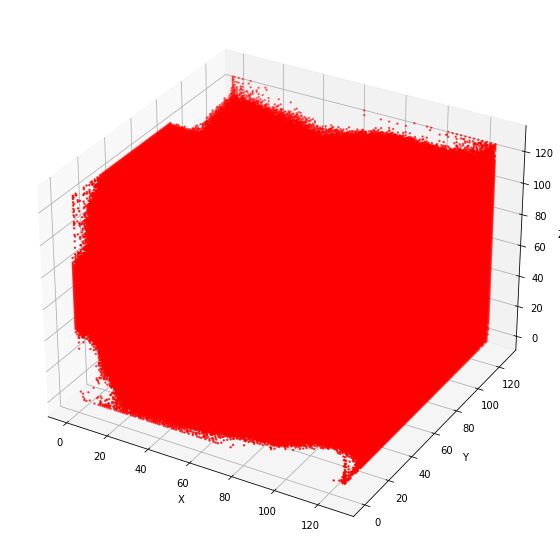

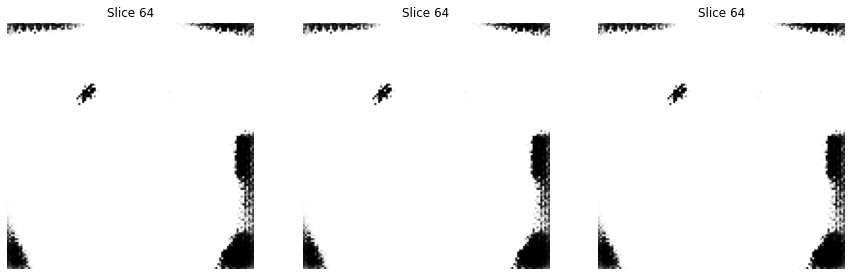

Epoch 8/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8942, G Loss=9057.7324, Proj Loss=4297.0908, Shape Loss=0.0619, Adv Loss=0.7925]


(128, 128, 128)
<class 'numpy.ndarray'>


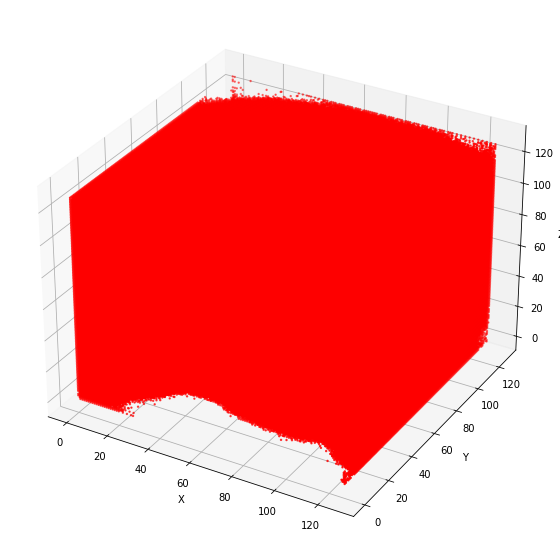

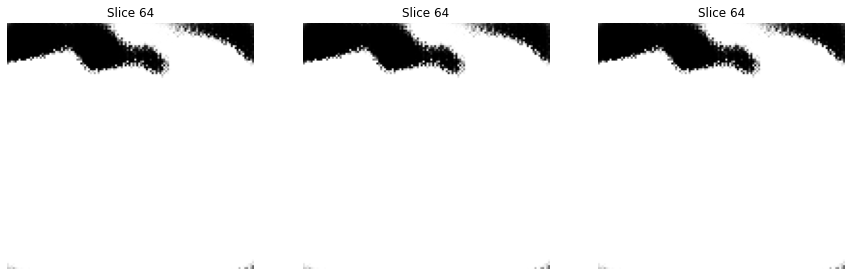

Epoch 9/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8882, G Loss=7841.9434, Proj Loss=3921.5332, Shape Loss=0.0649, Adv Loss=0.8027]


(128, 128, 128)
<class 'numpy.ndarray'>


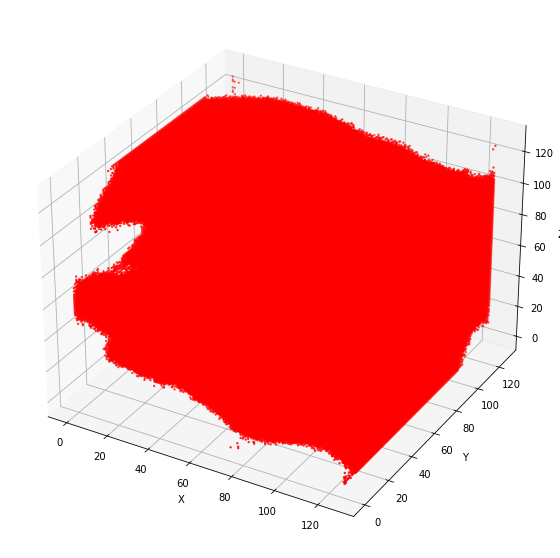

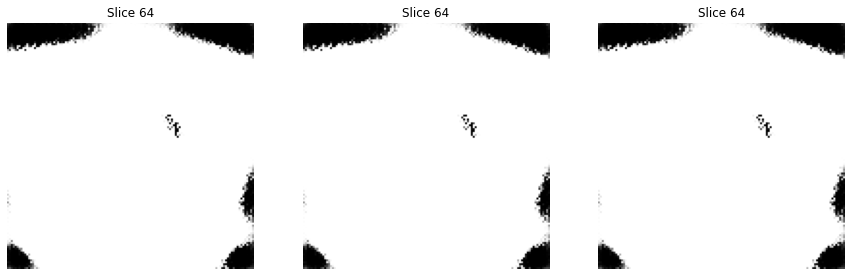

Epoch 10/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.9130, G Loss=8824.9531, Proj Loss=4373.6772, Shape Loss=0.0499, Adv Loss=0.7780]


(128, 128, 128)
<class 'numpy.ndarray'>


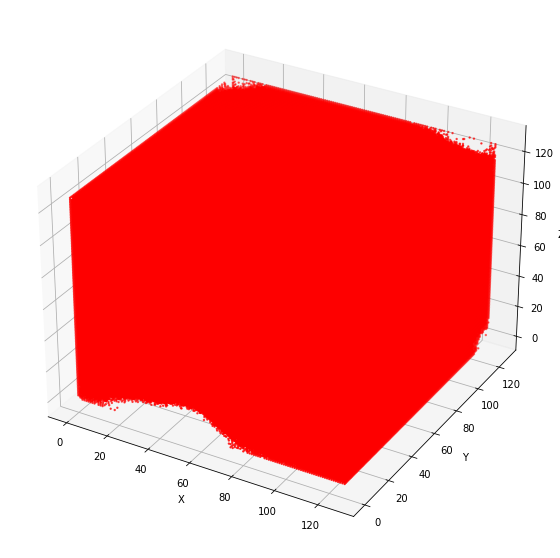

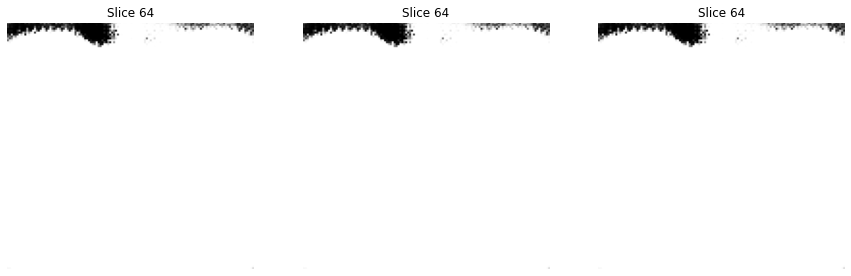

Epoch 11/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9023, G Loss=9216.2676, Proj Loss=4490.4409, Shape Loss=0.0523, Adv Loss=0.7800]


(128, 128, 128)
<class 'numpy.ndarray'>


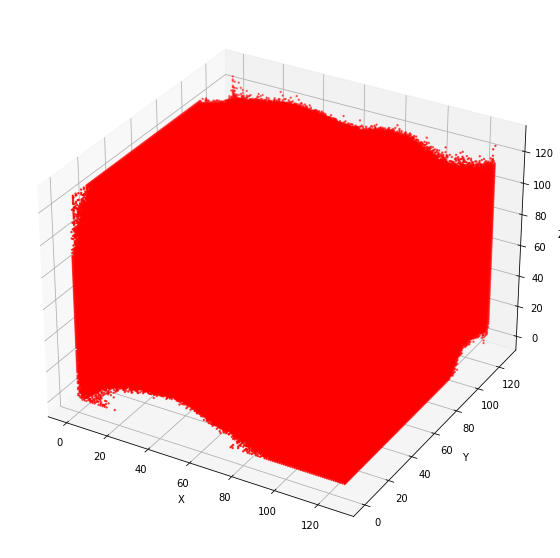

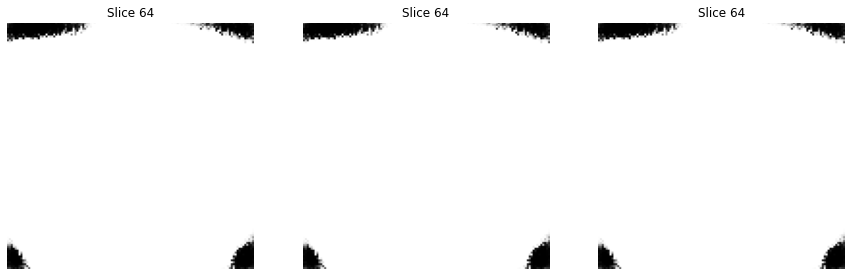

Epoch 12/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9077, G Loss=8953.7129, Proj Loss=4484.9648, Shape Loss=0.0478, Adv Loss=0.7739]


(128, 128, 128)
<class 'numpy.ndarray'>


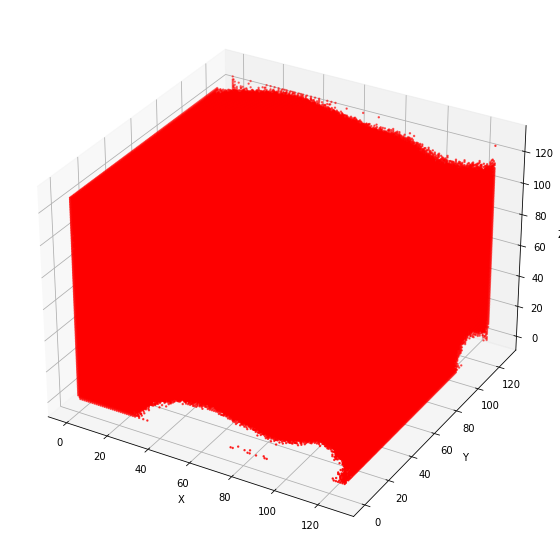

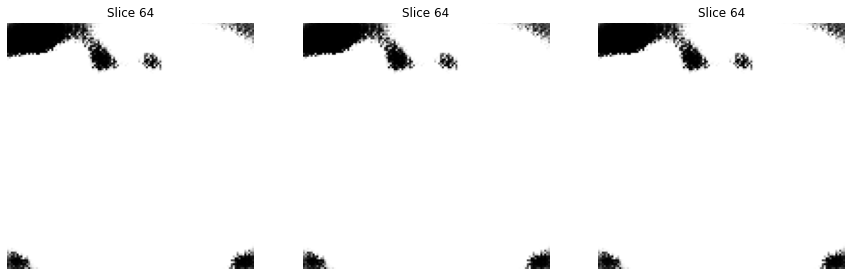

Epoch 13/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.9228, G Loss=9748.7559, Proj Loss=4525.4883, Shape Loss=0.0426, Adv Loss=0.7675]


(128, 128, 128)
<class 'numpy.ndarray'>


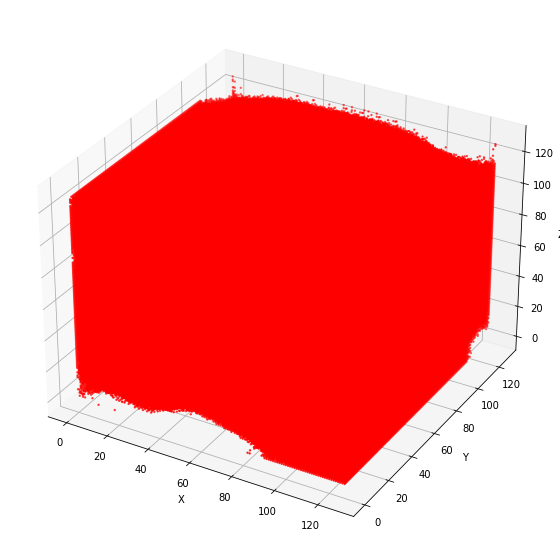

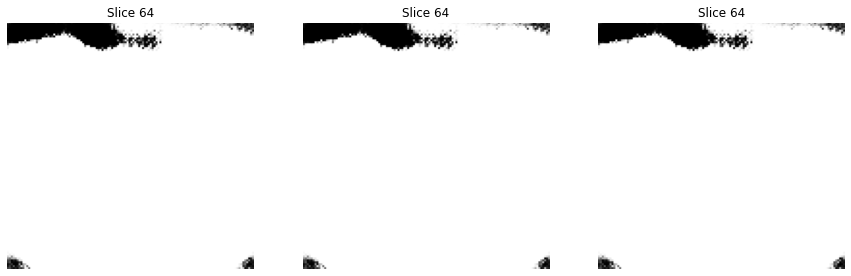

Epoch 14/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.9047, G Loss=8823.5117, Proj Loss=4210.7539, Shape Loss=0.0456, Adv Loss=0.7763]


(128, 128, 128)
<class 'numpy.ndarray'>


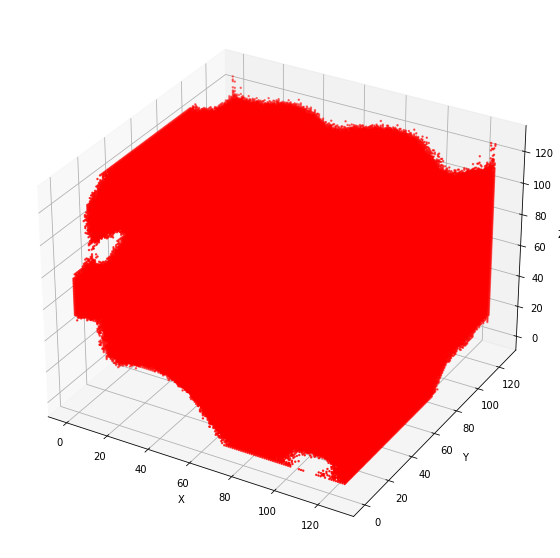

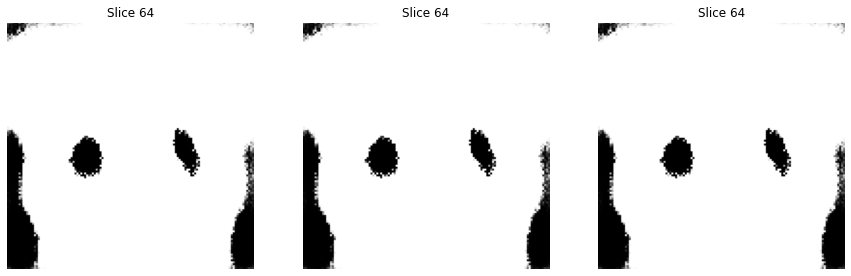

Epoch 15/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=2.9014, G Loss=8887.9453, Proj Loss=4551.0688, Shape Loss=0.0495, Adv Loss=0.7824]


(128, 128, 128)
<class 'numpy.ndarray'>


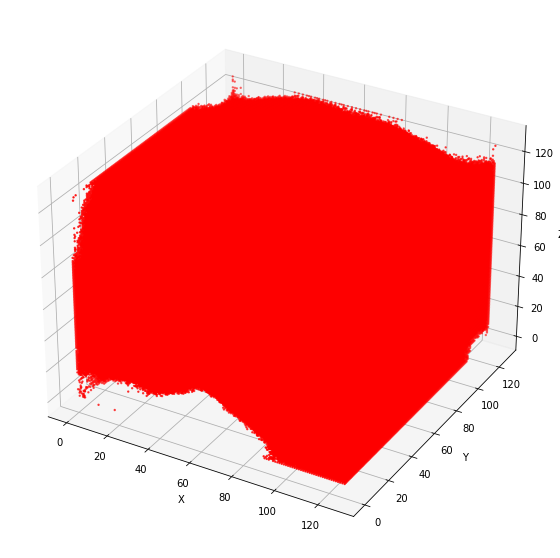

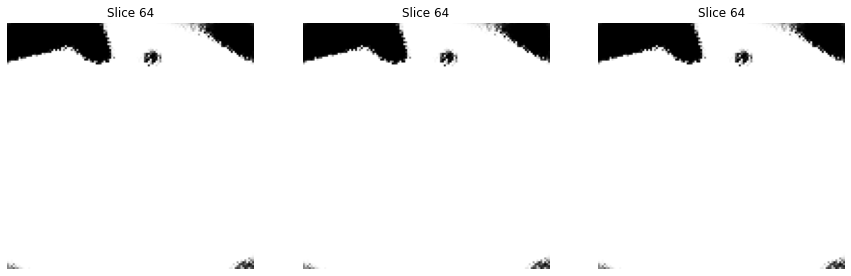

Epoch 16/1900: 100%|██████████| 106/106 [04:53<00:00,  2.77s/batch, D Loss=2.9036, G Loss=8825.6953, Proj Loss=4570.5381, Shape Loss=0.0479, Adv Loss=0.7820]


(128, 128, 128)
<class 'numpy.ndarray'>


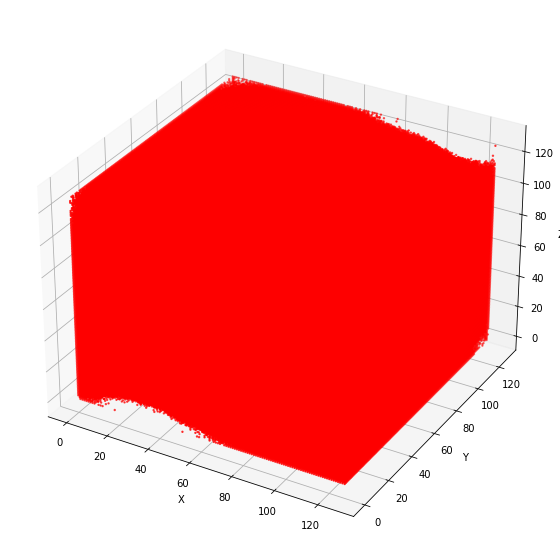

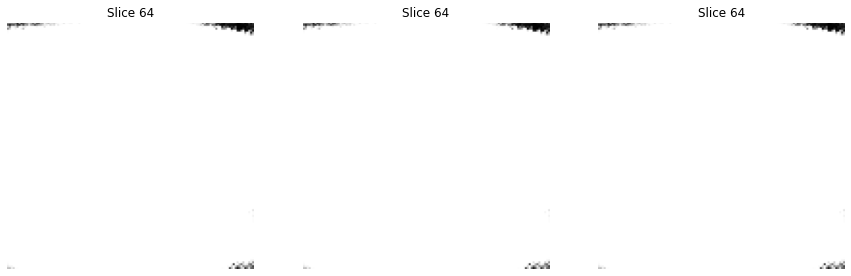

Epoch 17/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.8878, G Loss=8308.5117, Proj Loss=4077.1826, Shape Loss=0.0516, Adv Loss=0.7973]


(128, 128, 128)
<class 'numpy.ndarray'>


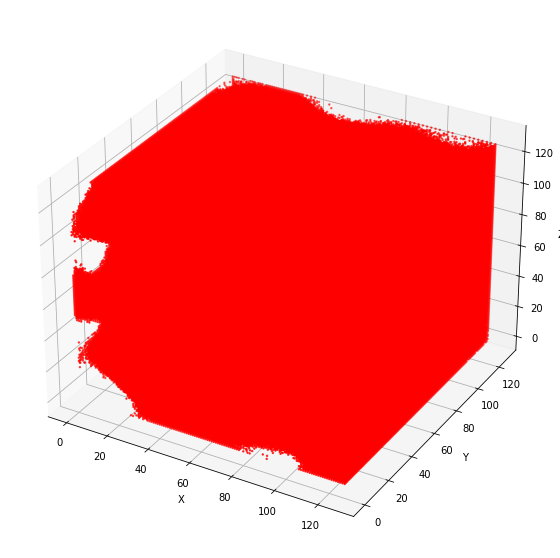

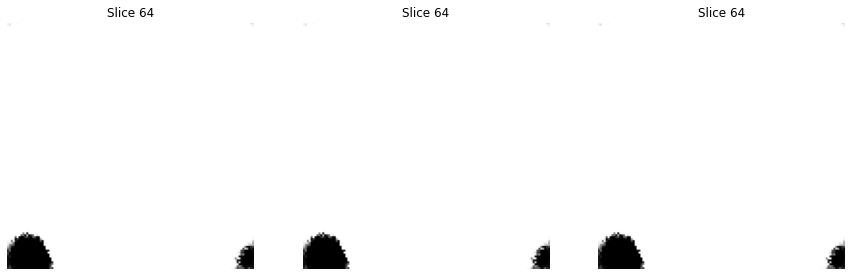

Epoch 18/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8999, G Loss=8961.8662, Proj Loss=4390.3711, Shape Loss=0.0436, Adv Loss=0.7777]


(128, 128, 128)
<class 'numpy.ndarray'>


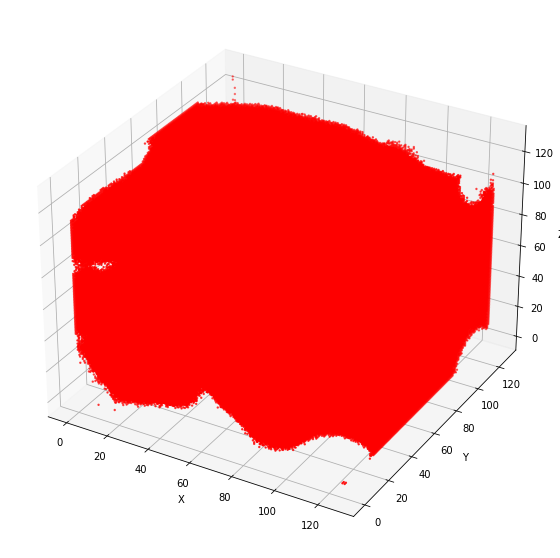

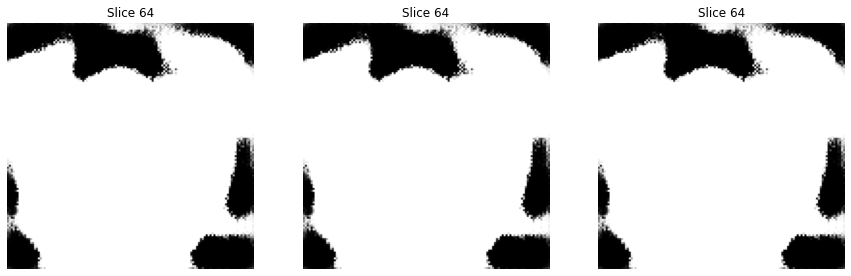

Epoch 19/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9079, G Loss=8963.6162, Proj Loss=4511.9966, Shape Loss=0.0415, Adv Loss=0.7746]


(128, 128, 128)
<class 'numpy.ndarray'>


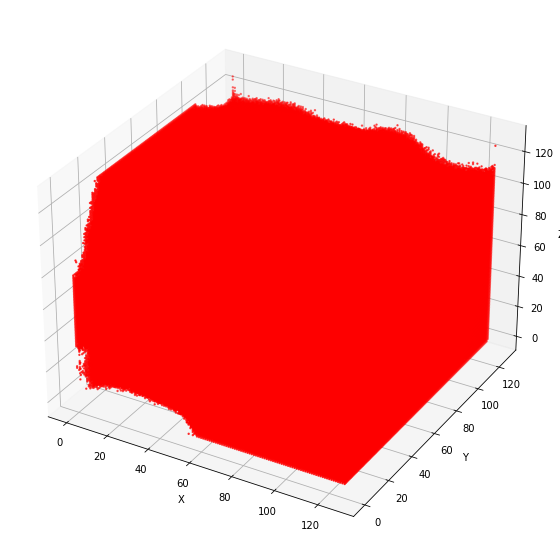

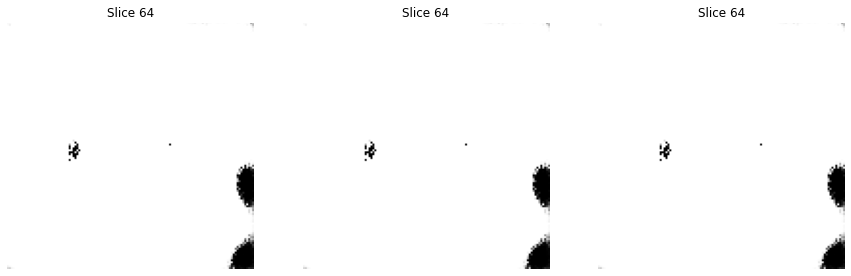

Epoch 20/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=2.9154, G Loss=9345.5781, Proj Loss=4293.2007, Shape Loss=0.0353, Adv Loss=0.7644]


(128, 128, 128)
<class 'numpy.ndarray'>


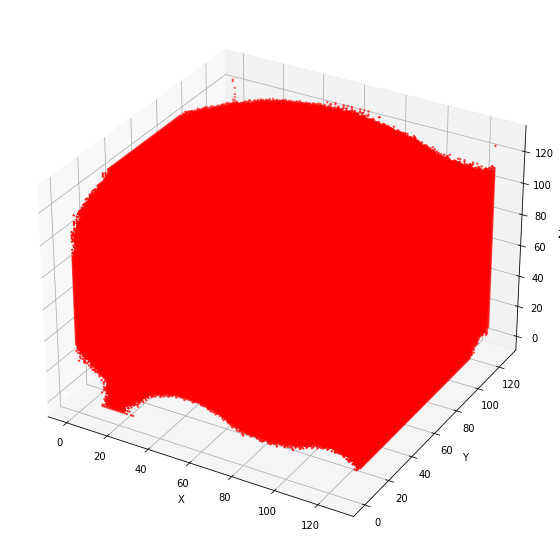

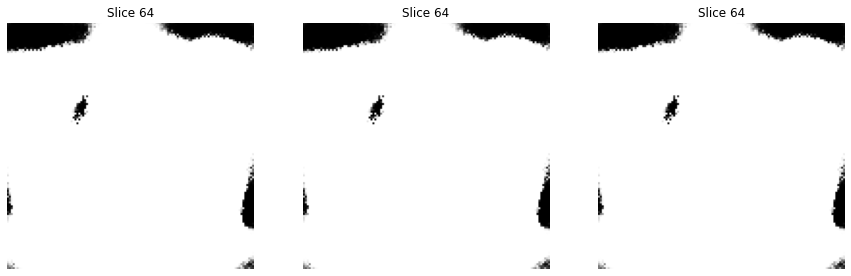

Epoch 21/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8823, G Loss=7969.9404, Proj Loss=4040.4497, Shape Loss=0.0496, Adv Loss=0.8046]


(128, 128, 128)
<class 'numpy.ndarray'>


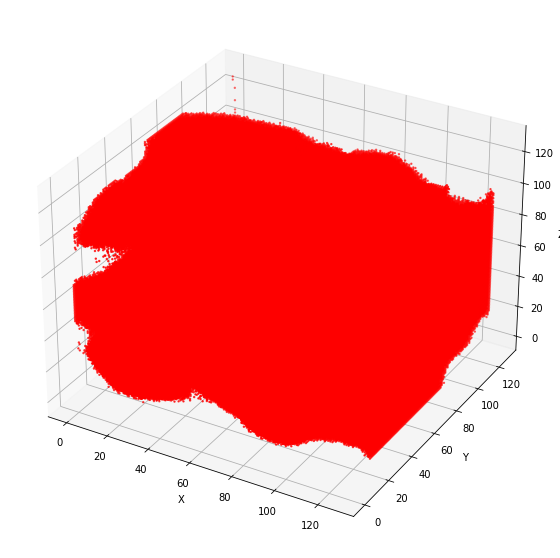

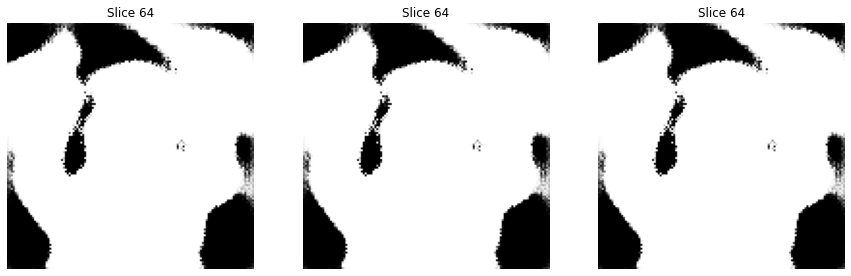

Epoch 22/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.8881, G Loss=8645.2656, Proj Loss=4142.9673, Shape Loss=0.0427, Adv Loss=0.7862]


(128, 128, 128)
<class 'numpy.ndarray'>


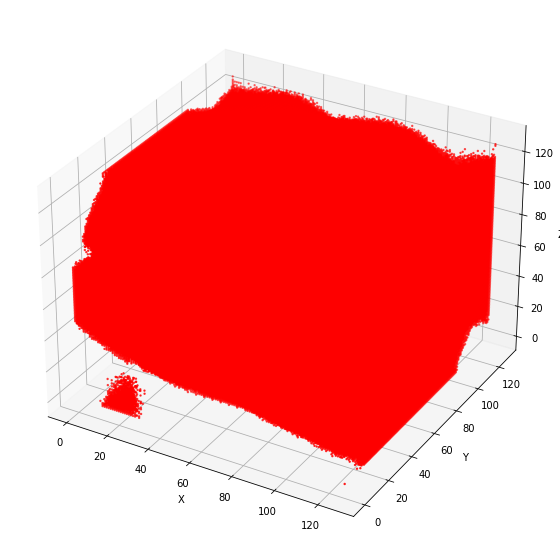

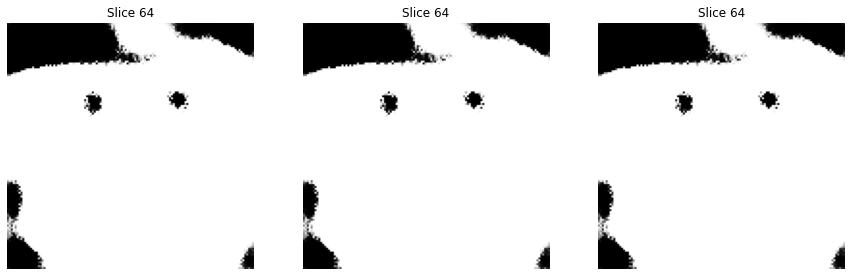

Epoch 23/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.9003, G Loss=8797.8613, Proj Loss=4189.4478, Shape Loss=0.0399, Adv Loss=0.7791]


(128, 128, 128)
<class 'numpy.ndarray'>


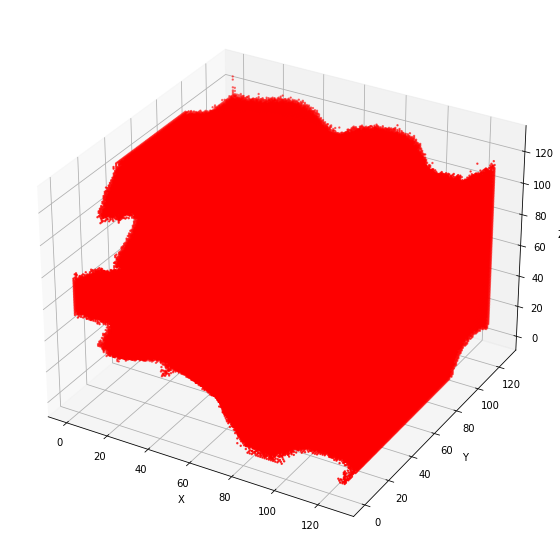

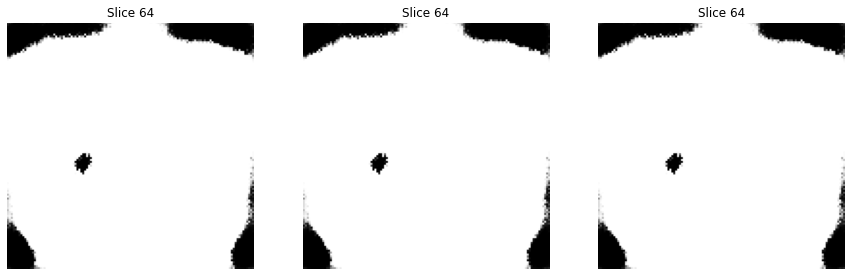

Epoch 24/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9001, G Loss=8832.9561, Proj Loss=4469.2568, Shape Loss=0.0394, Adv Loss=0.7803]


(128, 128, 128)
<class 'numpy.ndarray'>


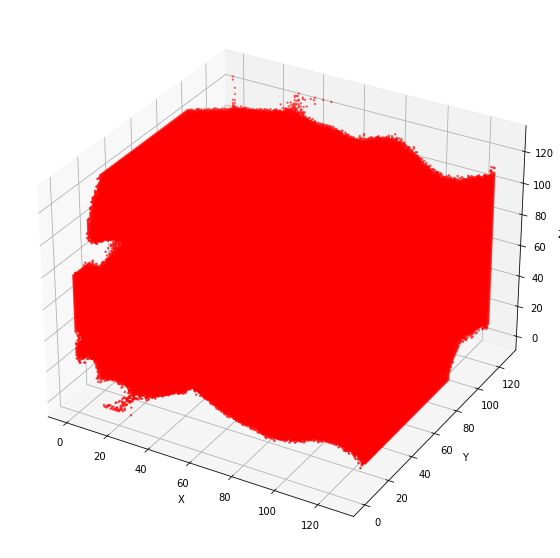

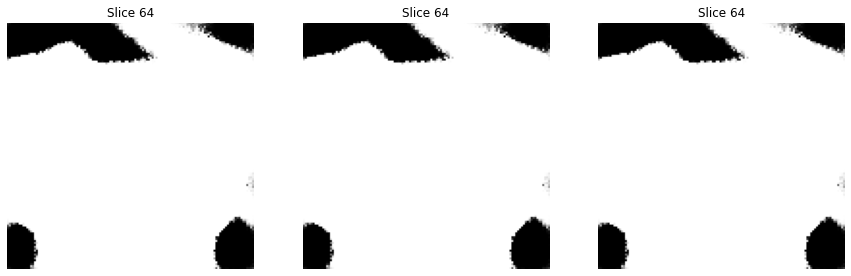

Epoch 25/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9046, G Loss=9399.7812, Proj Loss=4652.1377, Shape Loss=0.0346, Adv Loss=0.7685]


(128, 128, 128)
<class 'numpy.ndarray'>


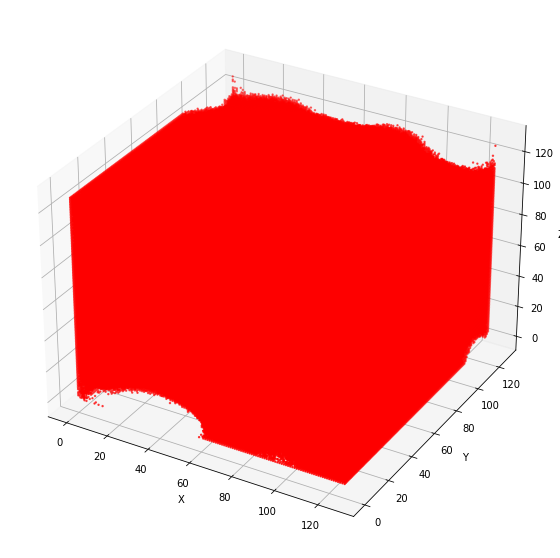

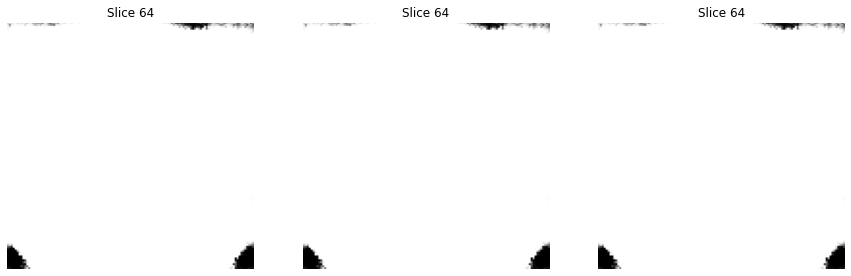

Epoch 26/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8993, G Loss=8437.8691, Proj Loss=4148.2651, Shape Loss=0.0406, Adv Loss=0.7851]


(128, 128, 128)
<class 'numpy.ndarray'>


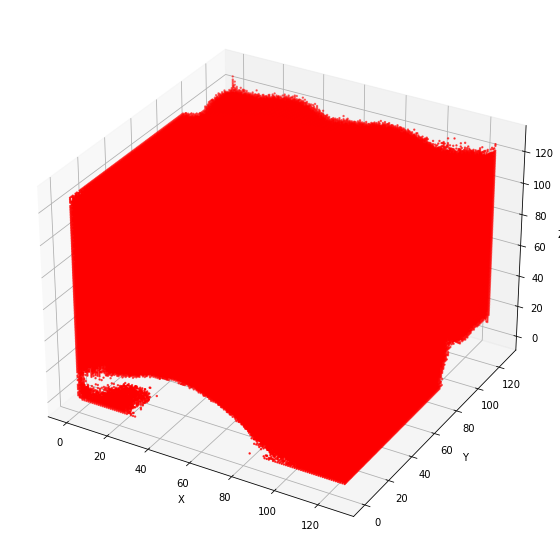

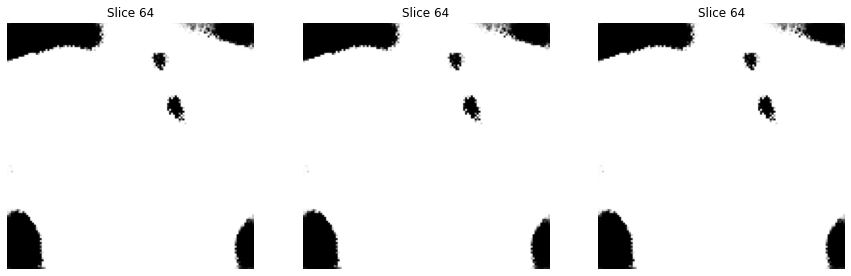

Epoch 27/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8863, G Loss=8282.3340, Proj Loss=3942.8567, Shape Loss=0.0399, Adv Loss=0.7892]


(128, 128, 128)
<class 'numpy.ndarray'>


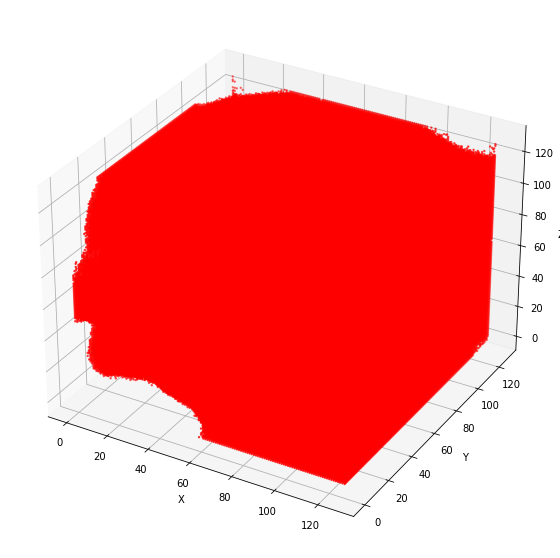

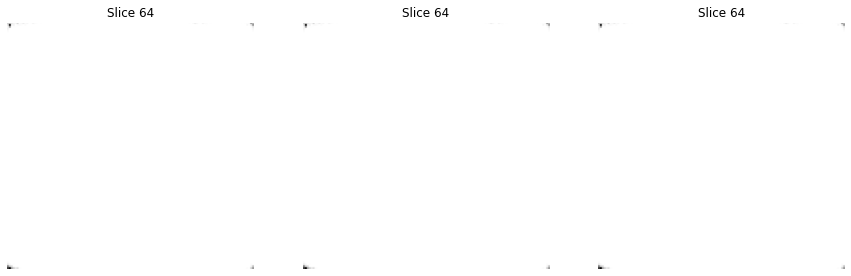

Epoch 28/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=2.8972, G Loss=8472.3223, Proj Loss=4358.2705, Shape Loss=0.0419, Adv Loss=0.7921]


(128, 128, 128)
<class 'numpy.ndarray'>


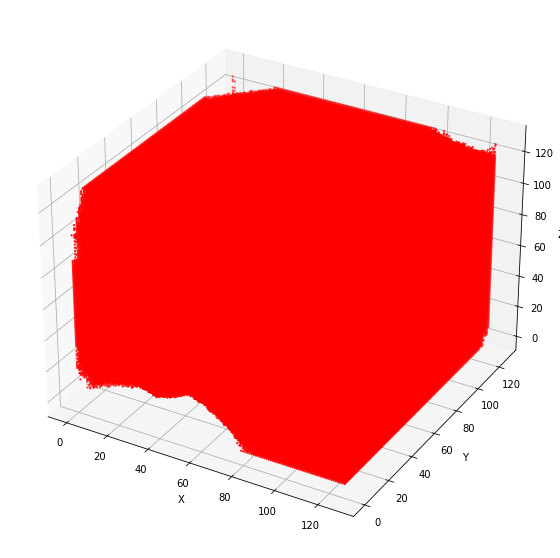

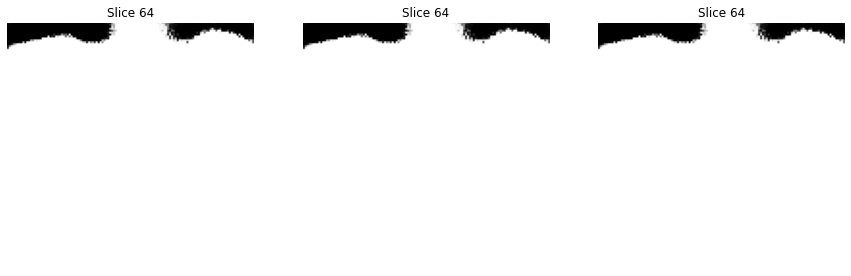

Epoch 29/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8969, G Loss=8588.9121, Proj Loss=4370.6523, Shape Loss=0.0415, Adv Loss=0.7909]


(128, 128, 128)
<class 'numpy.ndarray'>


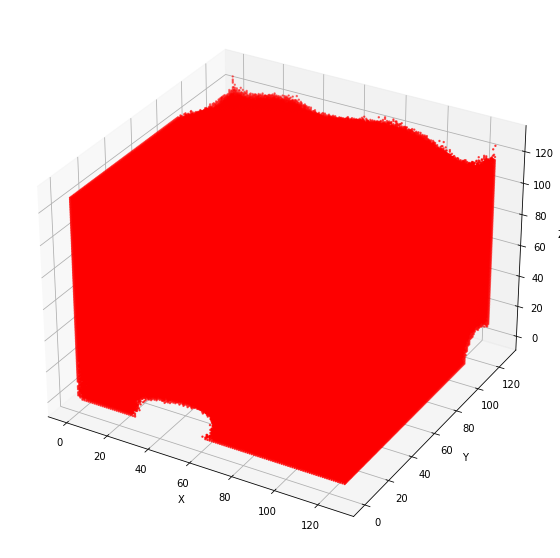

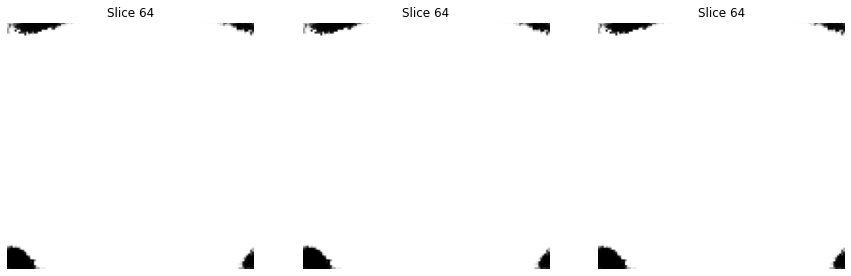

Epoch 30/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=2.8948, G Loss=8410.8145, Proj Loss=4412.4170, Shape Loss=0.0402, Adv Loss=0.7882]


(128, 128, 128)
<class 'numpy.ndarray'>


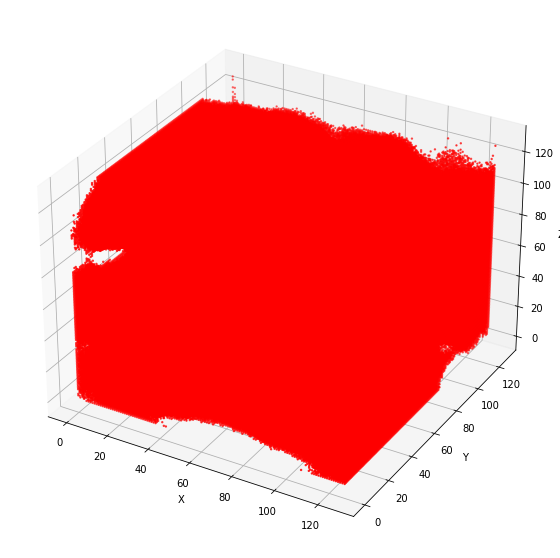

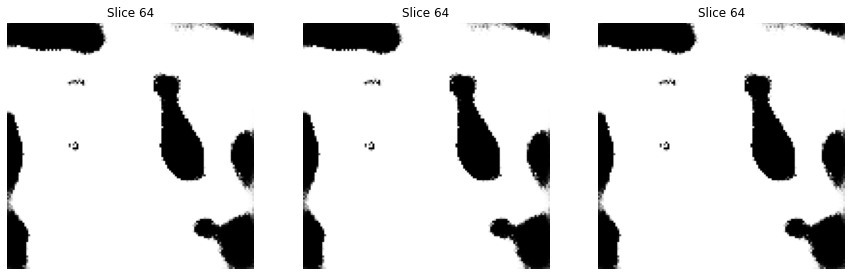

Epoch 31/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.9057, G Loss=8697.0391, Proj Loss=4103.6548, Shape Loss=0.0337, Adv Loss=0.7764]


(128, 128, 128)
<class 'numpy.ndarray'>


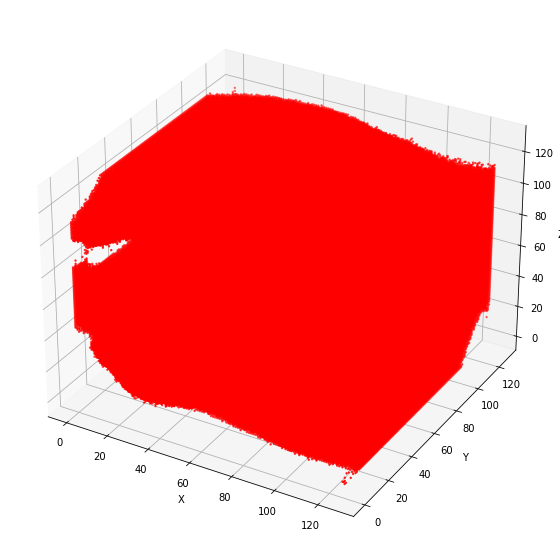

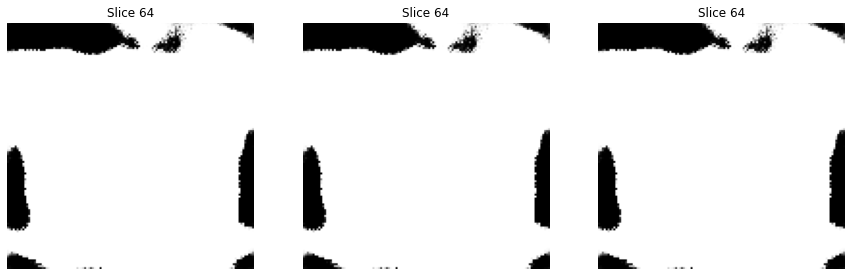

Epoch 32/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=2.9075, G Loss=8567.2695, Proj Loss=4179.7969, Shape Loss=0.0363, Adv Loss=0.7784]


(128, 128, 128)
<class 'numpy.ndarray'>


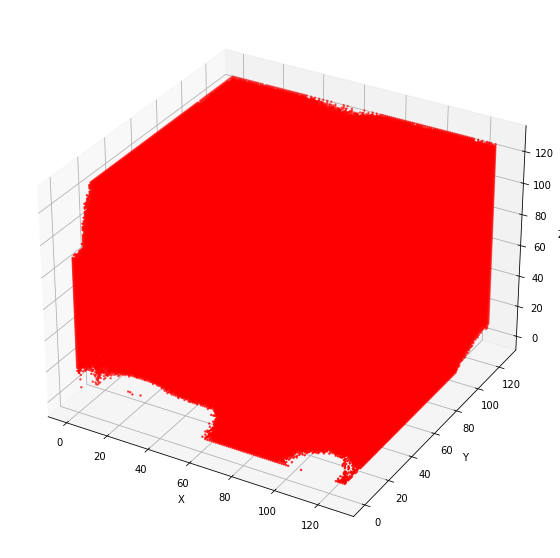

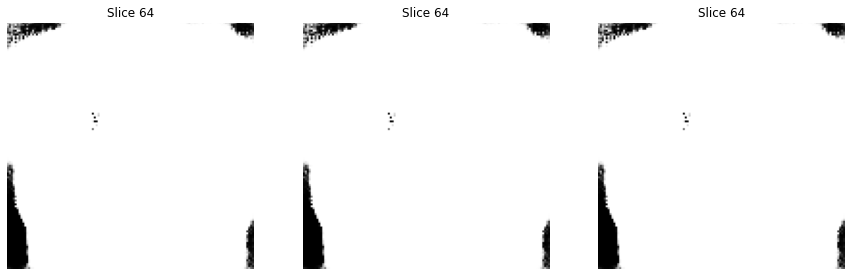

Epoch 33/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8875, G Loss=8035.9526, Proj Loss=4062.6646, Shape Loss=0.0411, Adv Loss=0.7964]


(128, 128, 128)
<class 'numpy.ndarray'>


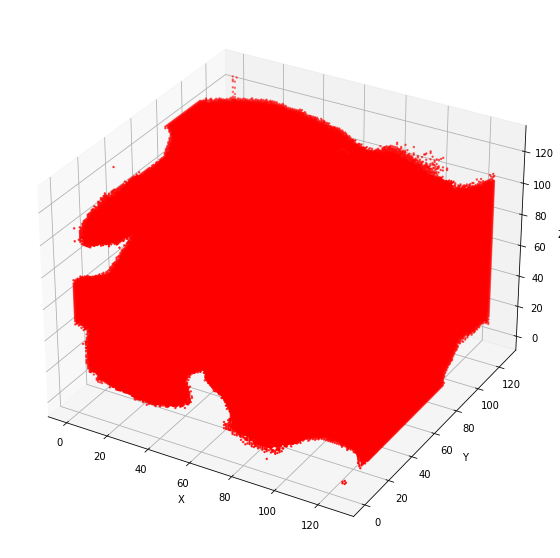

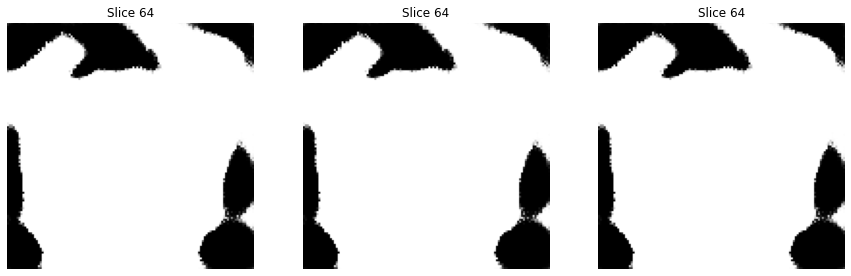

Epoch 34/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9087, G Loss=9052.4707, Proj Loss=4351.6670, Shape Loss=0.0298, Adv Loss=0.7643]


(128, 128, 128)
<class 'numpy.ndarray'>


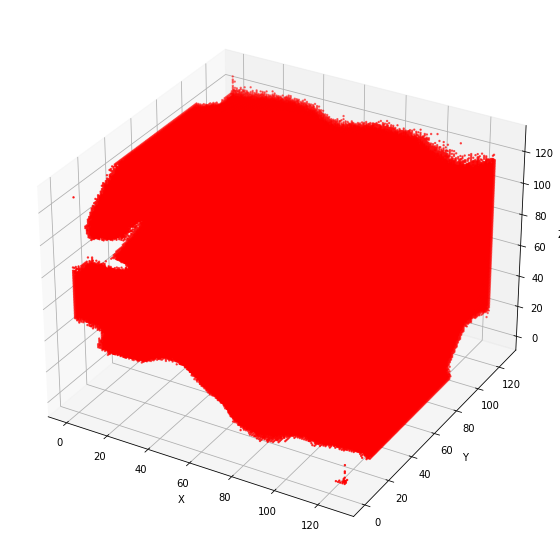

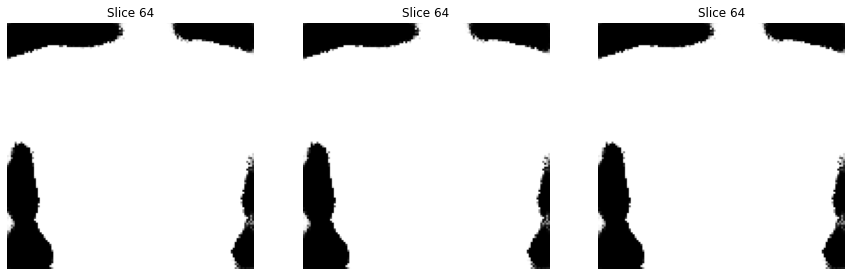

Epoch 35/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8897, G Loss=8204.5449, Proj Loss=4037.9990, Shape Loss=0.0392, Adv Loss=0.7890]


(128, 128, 128)
<class 'numpy.ndarray'>


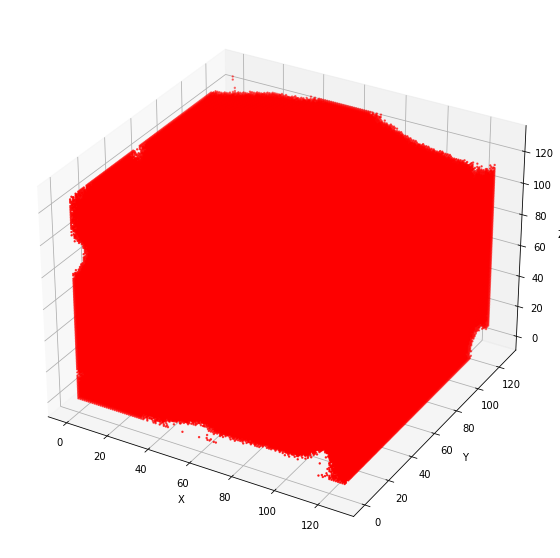

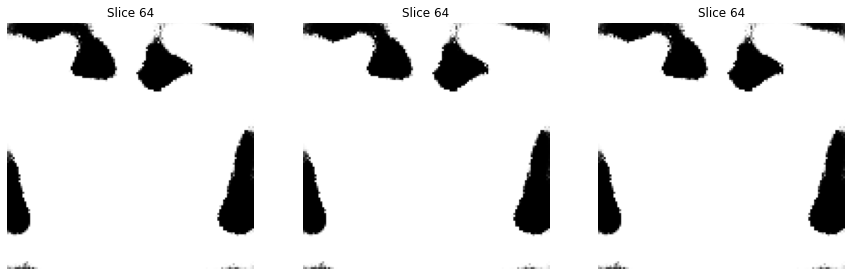

Epoch 36/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.9085, G Loss=9318.4785, Proj Loss=4421.7832, Shape Loss=0.0314, Adv Loss=0.7700]


(128, 128, 128)
<class 'numpy.ndarray'>


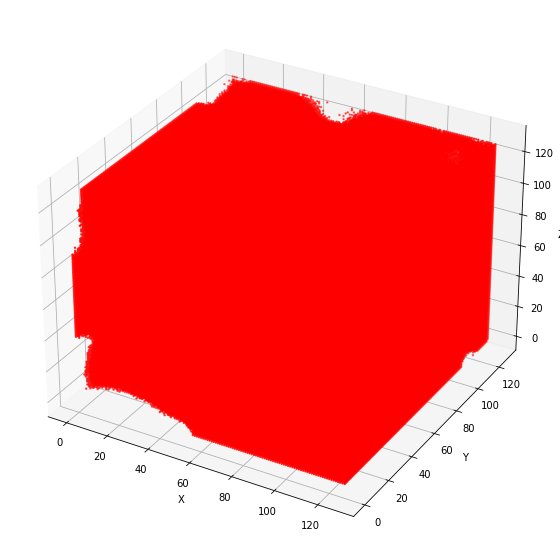

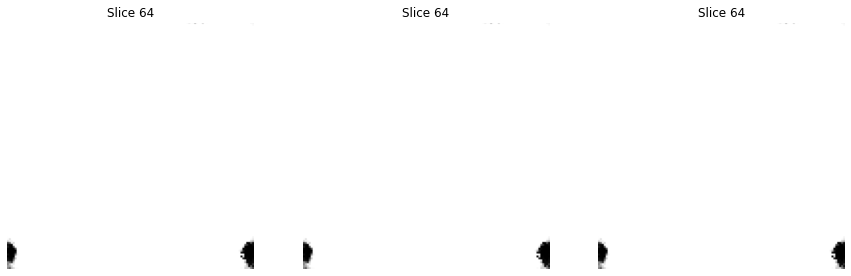

Epoch 37/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9047, G Loss=8938.2051, Proj Loss=4175.6792, Shape Loss=0.0298, Adv Loss=0.7675]


(128, 128, 128)
<class 'numpy.ndarray'>


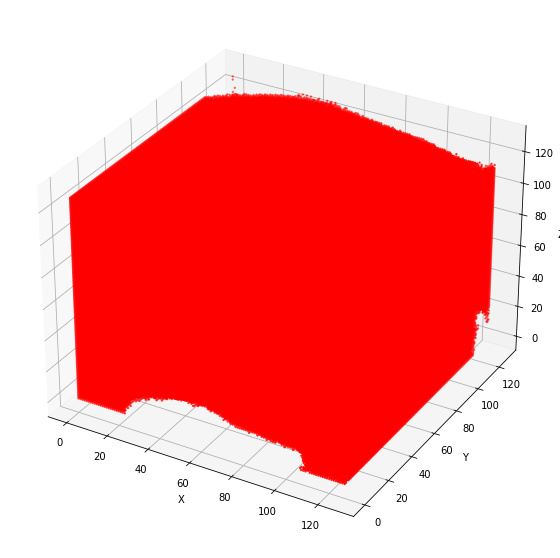

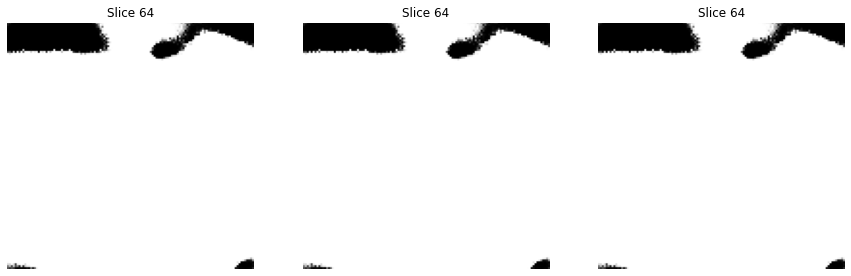

Epoch 38/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.9029, G Loss=8416.2344, Proj Loss=4059.3555, Shape Loss=0.0374, Adv Loss=0.7910]


(128, 128, 128)
<class 'numpy.ndarray'>


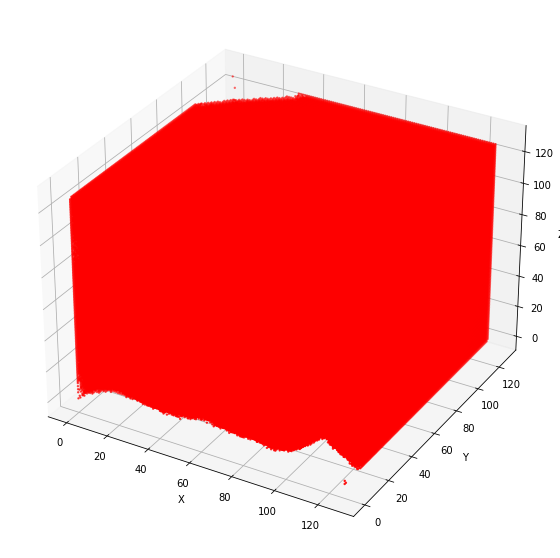

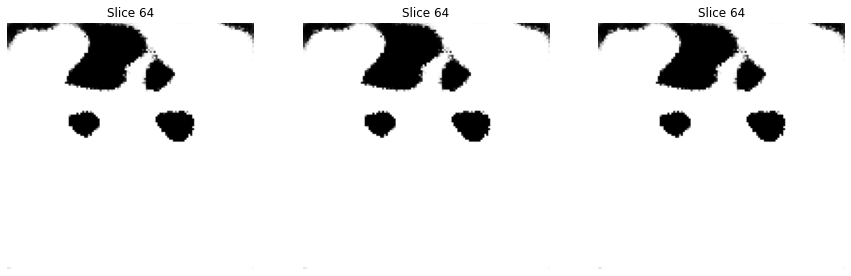

Epoch 39/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8864, G Loss=8599.7812, Proj Loss=4303.4082, Shape Loss=0.0364, Adv Loss=0.7882]


(128, 128, 128)
<class 'numpy.ndarray'>


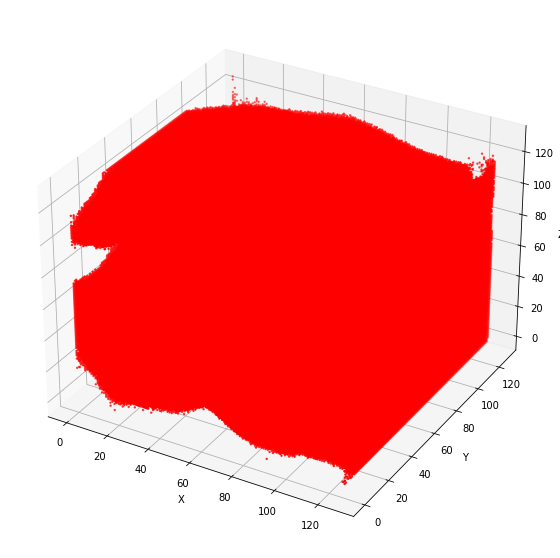

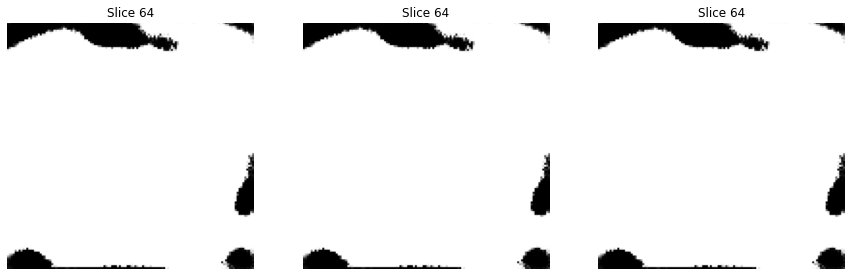

Epoch 40/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9060, G Loss=9201.1084, Proj Loss=4538.7793, Shape Loss=0.0327, Adv Loss=0.7751]


(128, 128, 128)
<class 'numpy.ndarray'>


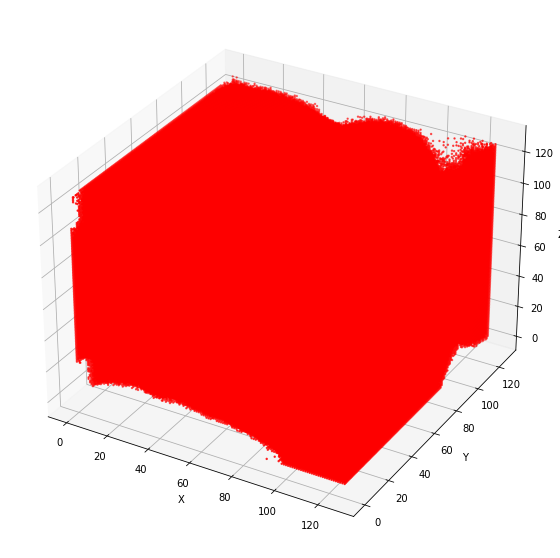

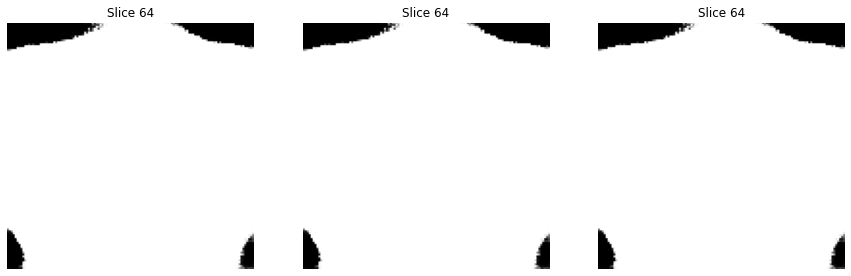

Epoch 41/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.9032, G Loss=9026.0791, Proj Loss=4513.8750, Shape Loss=0.0319, Adv Loss=0.7758]


(128, 128, 128)
<class 'numpy.ndarray'>


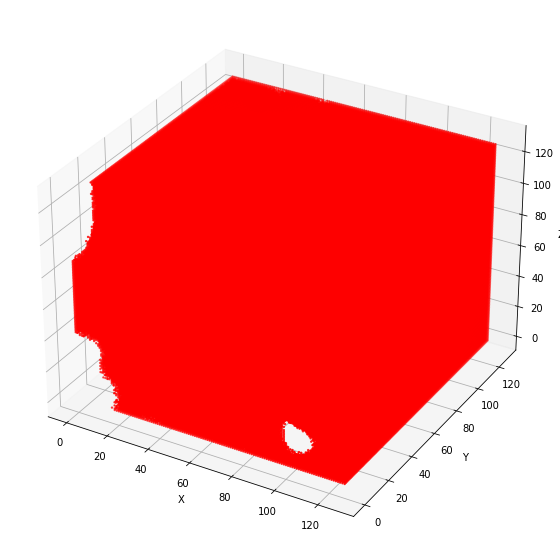

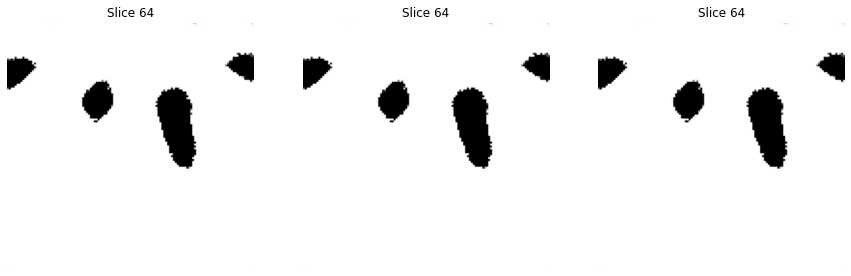

Epoch 42/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8883, G Loss=8983.7168, Proj Loss=4330.9468, Shape Loss=0.0349, Adv Loss=0.7814]


(128, 128, 128)
<class 'numpy.ndarray'>


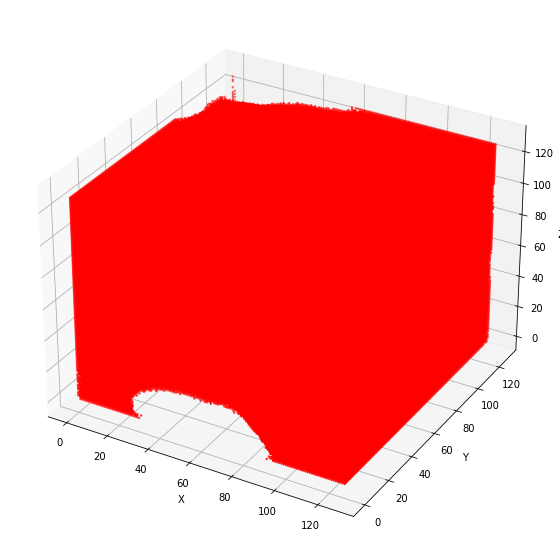

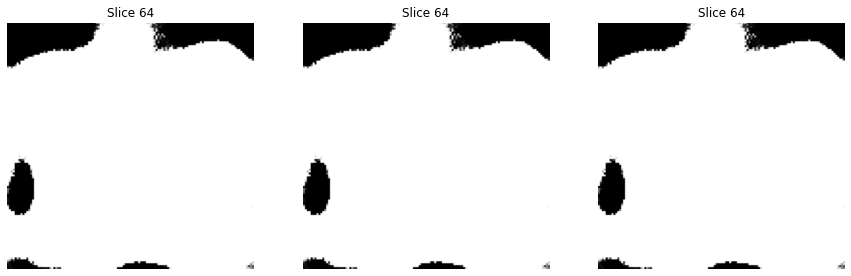

Epoch 43/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.9061, G Loss=8862.9199, Proj Loss=4376.4785, Shape Loss=0.0340, Adv Loss=0.7792]


(128, 128, 128)
<class 'numpy.ndarray'>


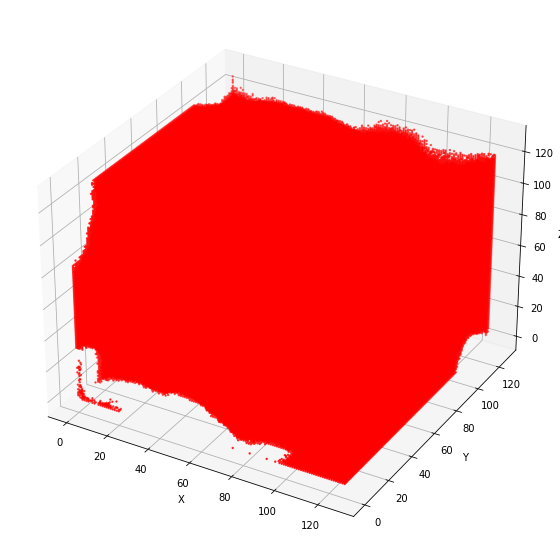

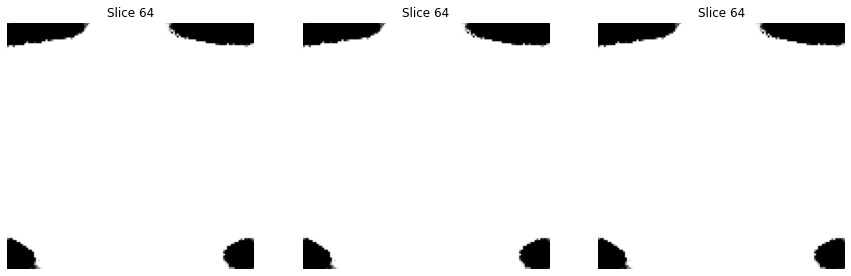

Epoch 44/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9061, G Loss=8492.7715, Proj Loss=4196.7700, Shape Loss=0.0349, Adv Loss=0.7846]


(128, 128, 128)
<class 'numpy.ndarray'>


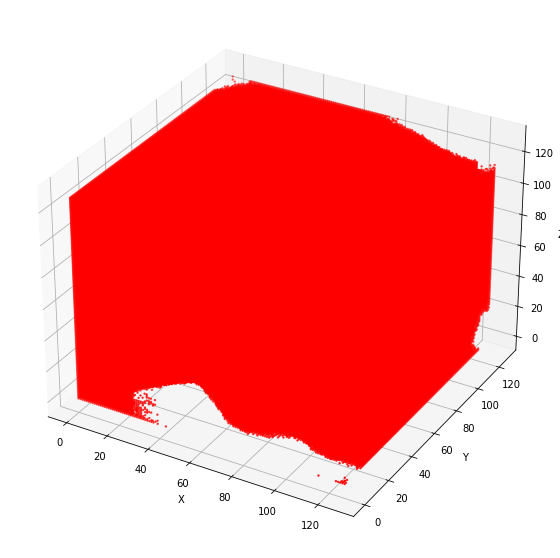

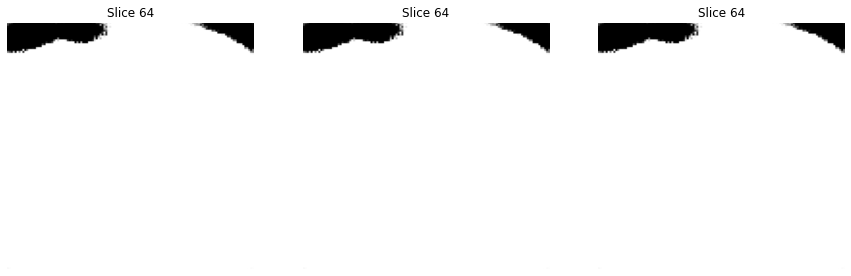

Epoch 45/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.8974, G Loss=8864.1055, Proj Loss=4100.7925, Shape Loss=0.0327, Adv Loss=0.7819]


(128, 128, 128)
<class 'numpy.ndarray'>


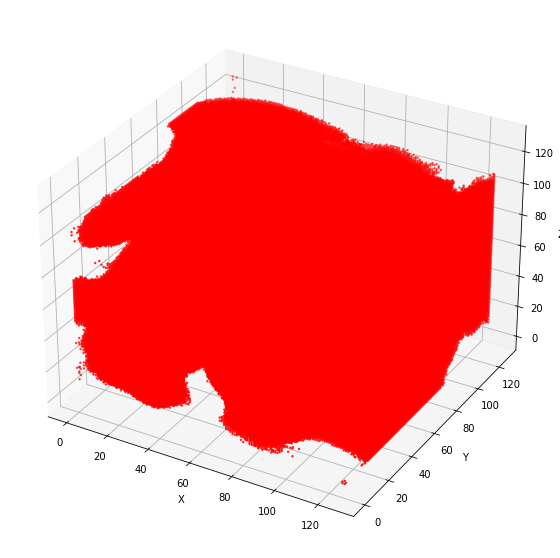

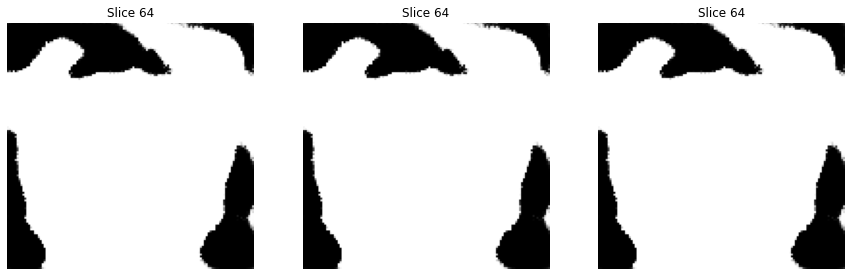

Epoch 46/1900: 100%|██████████| 106/106 [04:58<00:00,  2.82s/batch, D Loss=2.8911, G Loss=8942.1582, Proj Loss=4479.1196, Shape Loss=0.0355, Adv Loss=0.7856]


(128, 128, 128)
<class 'numpy.ndarray'>


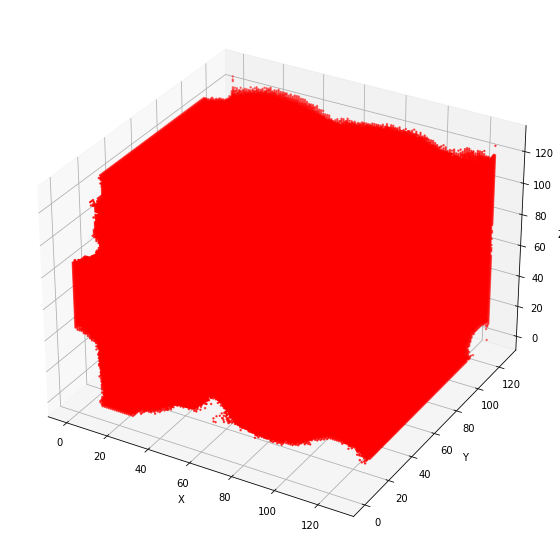

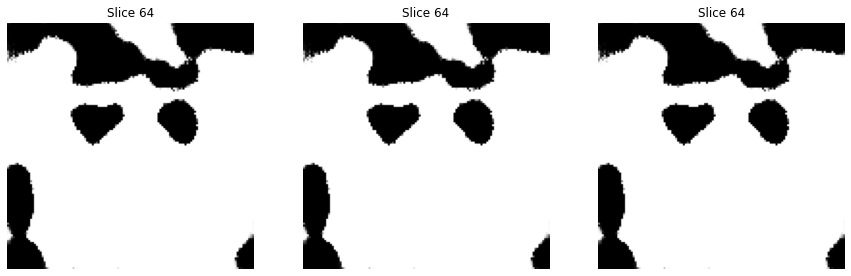

Epoch 47/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.8945, G Loss=8169.1553, Proj Loss=4163.9775, Shape Loss=0.0379, Adv Loss=0.7916]


(128, 128, 128)
<class 'numpy.ndarray'>


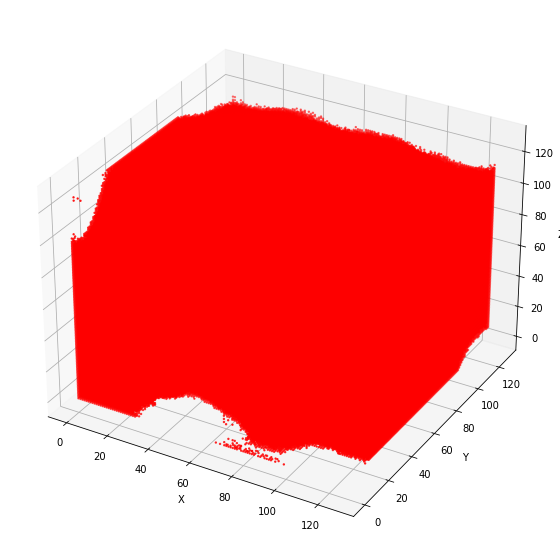

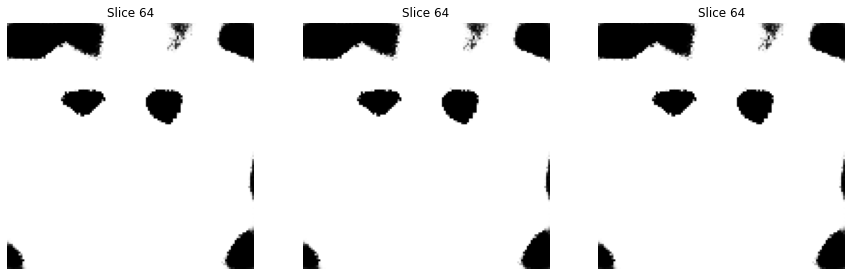

Epoch 48/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.9097, G Loss=8791.3477, Proj Loss=4256.8711, Shape Loss=0.0313, Adv Loss=0.7742]


(128, 128, 128)
<class 'numpy.ndarray'>


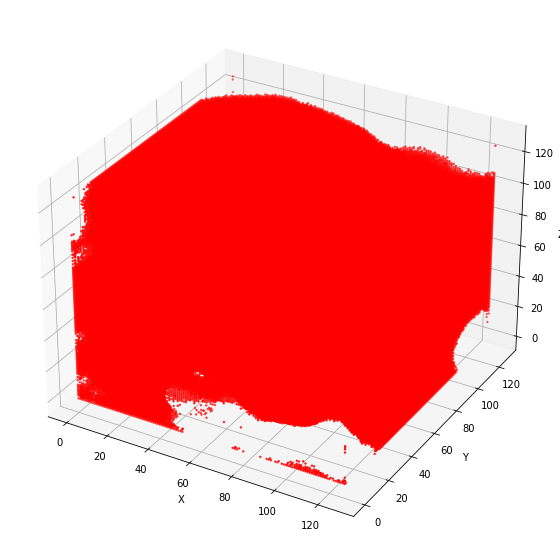

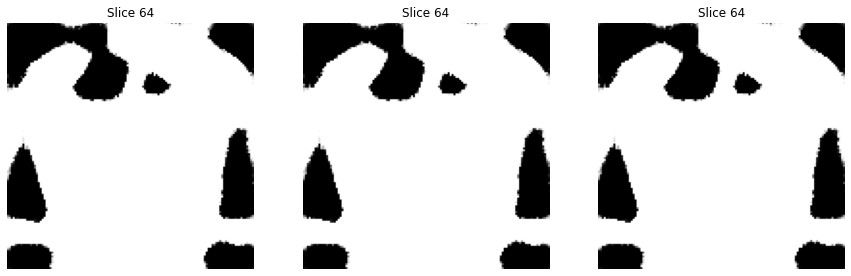

Epoch 49/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.8963, G Loss=8618.5254, Proj Loss=4049.9702, Shape Loss=0.0338, Adv Loss=0.7832]


(128, 128, 128)
<class 'numpy.ndarray'>


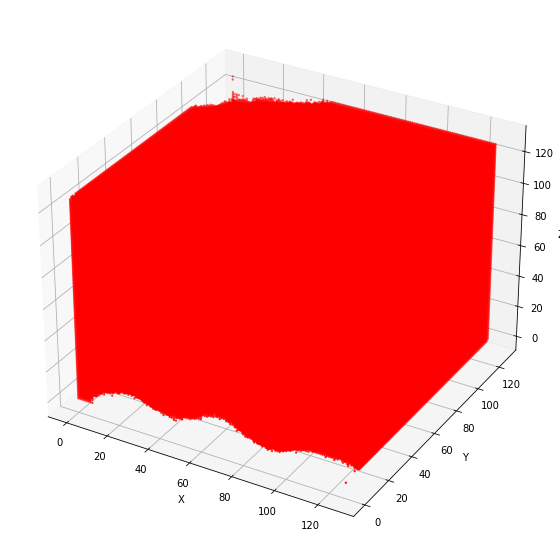

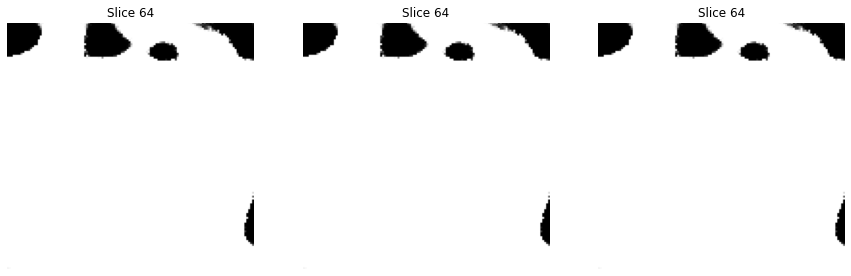

Epoch 50/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.9085, G Loss=8635.7617, Proj Loss=4258.1982, Shape Loss=0.0333, Adv Loss=0.7790]


(128, 128, 128)
<class 'numpy.ndarray'>


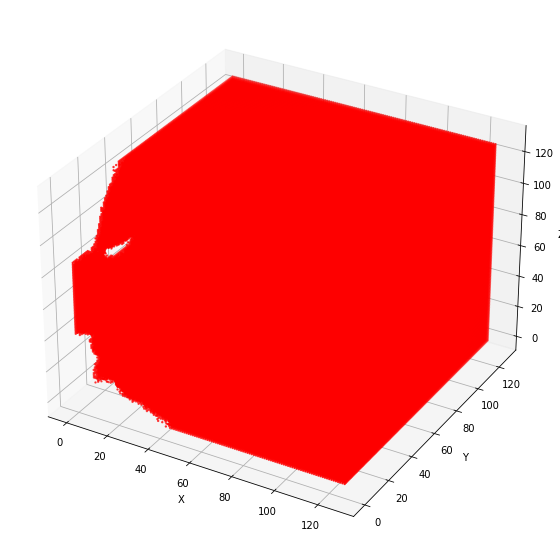

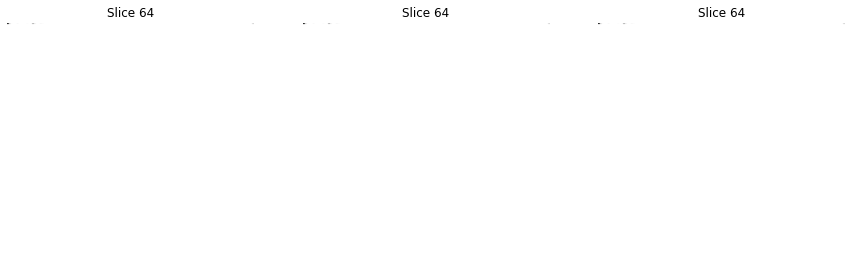

Epoch 51/1900: 100%|██████████| 106/106 [05:01<00:00,  2.85s/batch, D Loss=2.8842, G Loss=7972.8228, Proj Loss=3967.8752, Shape Loss=0.0364, Adv Loss=0.7935]


(128, 128, 128)
<class 'numpy.ndarray'>


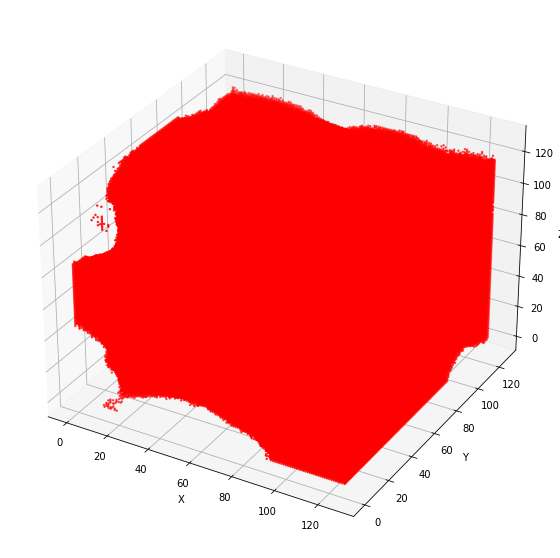

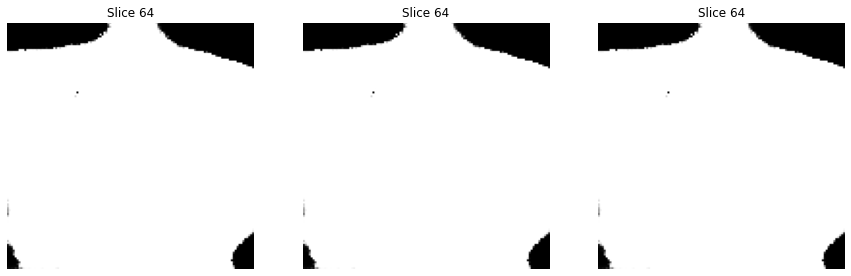

Epoch 52/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.8979, G Loss=8770.9326, Proj Loss=4111.2651, Shape Loss=0.0317, Adv Loss=0.7789]


(128, 128, 128)
<class 'numpy.ndarray'>


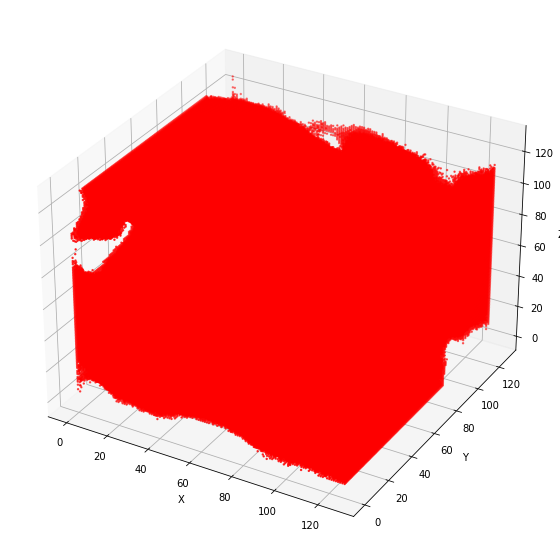

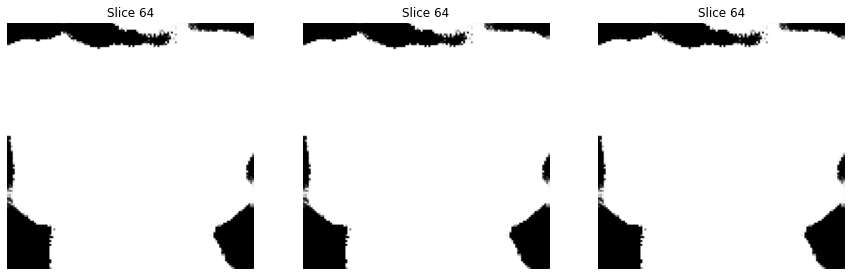

Epoch 53/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8880, G Loss=8544.0195, Proj Loss=4207.9155, Shape Loss=0.0360, Adv Loss=0.7913]


(128, 128, 128)
<class 'numpy.ndarray'>


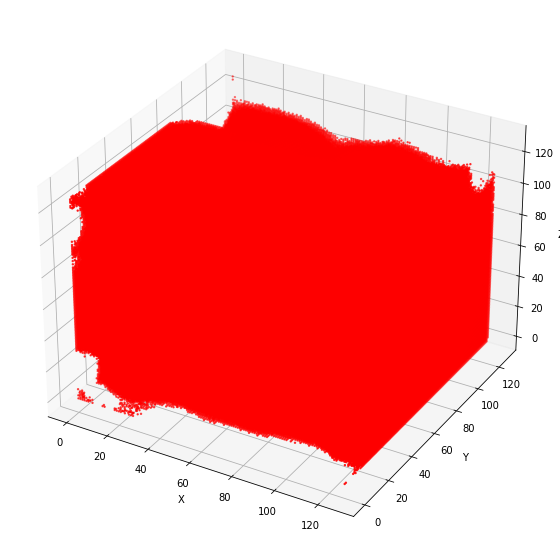

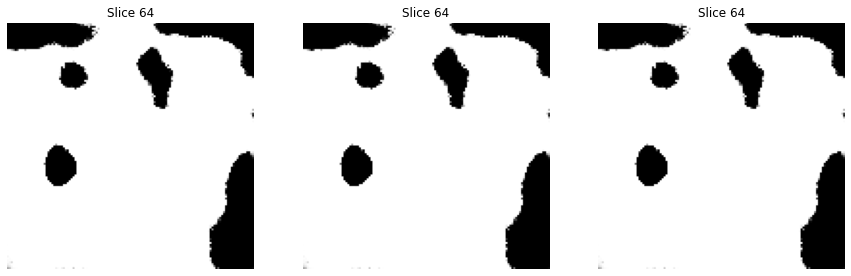

Epoch 54/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=2.8925, G Loss=8505.5293, Proj Loss=3971.7246, Shape Loss=0.0326, Adv Loss=0.7833]


(128, 128, 128)
<class 'numpy.ndarray'>


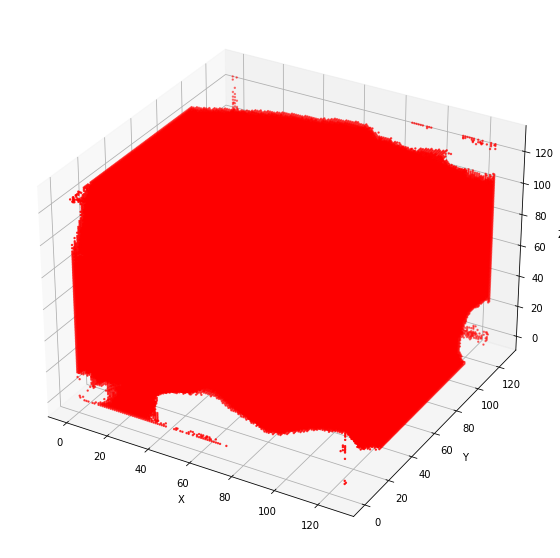

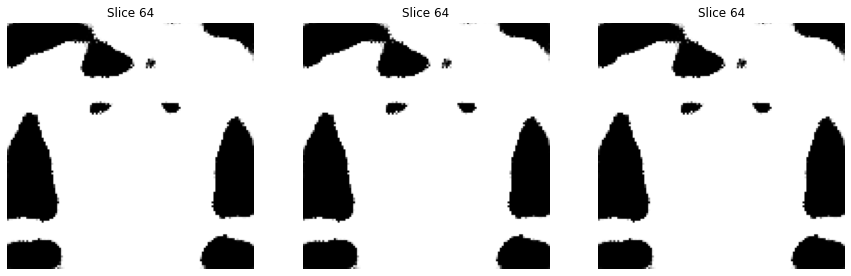

Epoch 55/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.8953, G Loss=8664.2900, Proj Loss=4105.7944, Shape Loss=0.0332, Adv Loss=0.7837]


(128, 128, 128)
<class 'numpy.ndarray'>


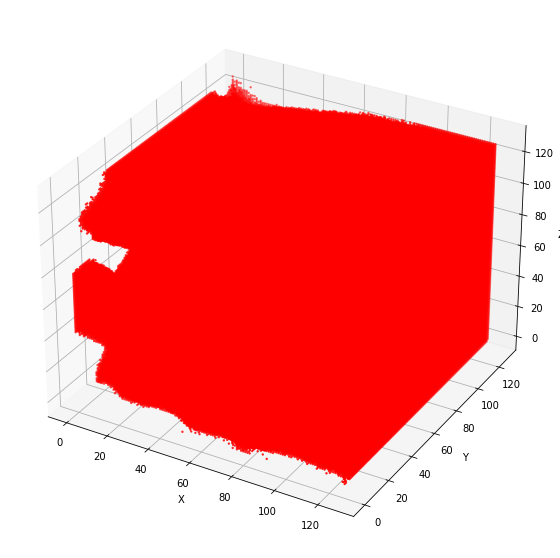

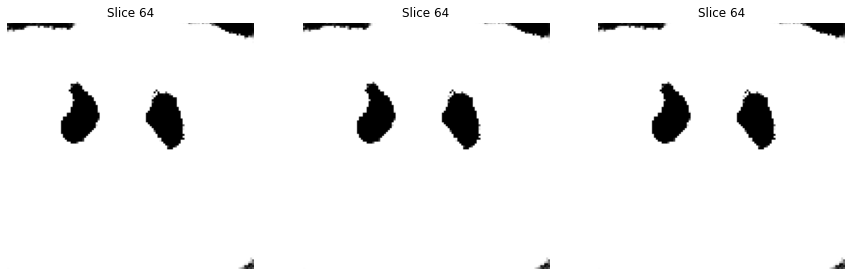

Epoch 56/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8979, G Loss=8613.0674, Proj Loss=4247.4683, Shape Loss=0.0310, Adv Loss=0.7784]


(128, 128, 128)
<class 'numpy.ndarray'>


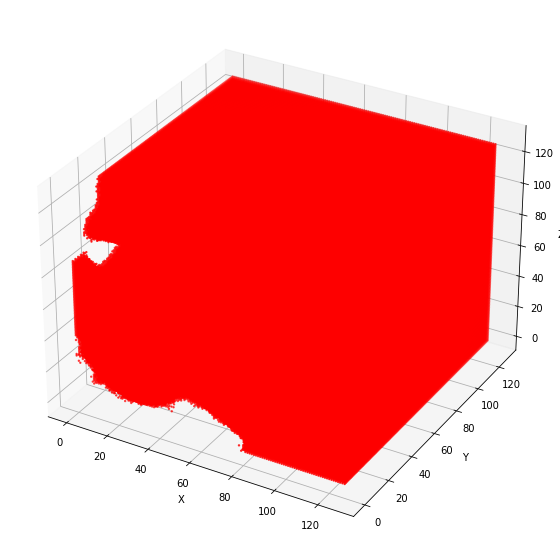

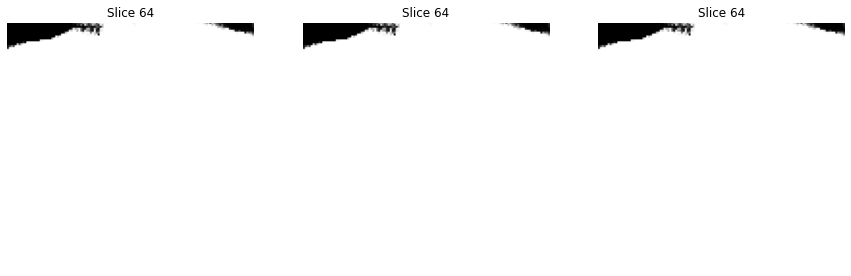

Epoch 57/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.8949, G Loss=9084.4150, Proj Loss=4523.7656, Shape Loss=0.0316, Adv Loss=0.7795]


(128, 128, 128)
<class 'numpy.ndarray'>


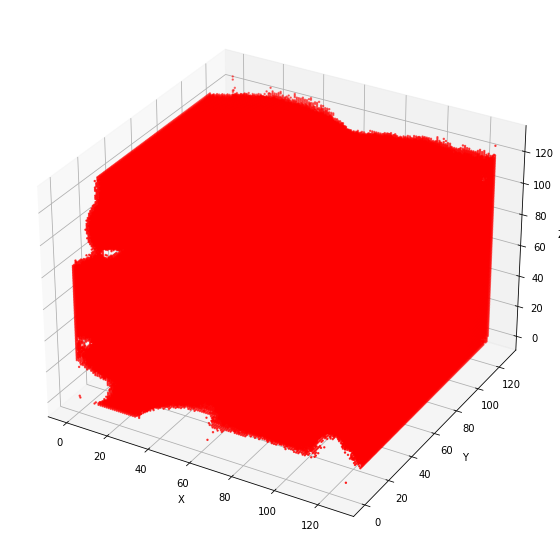

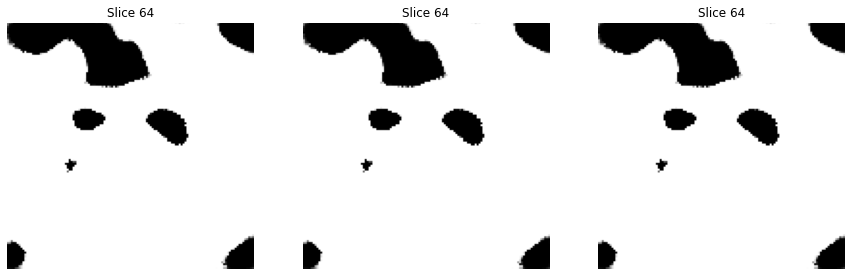

Epoch 58/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8973, G Loss=8536.1758, Proj Loss=4054.3762, Shape Loss=0.0308, Adv Loss=0.7780]


(128, 128, 128)
<class 'numpy.ndarray'>


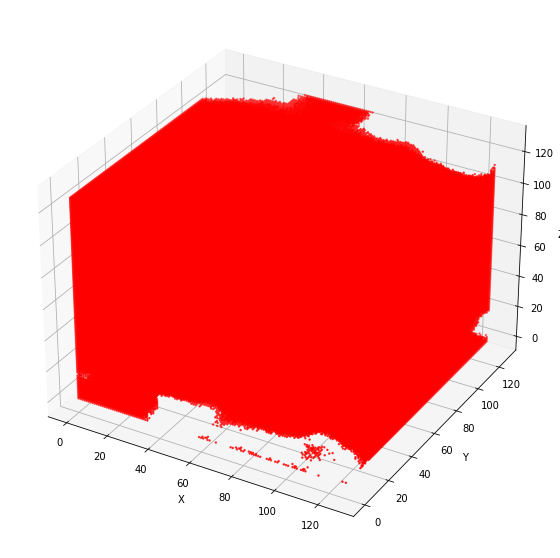

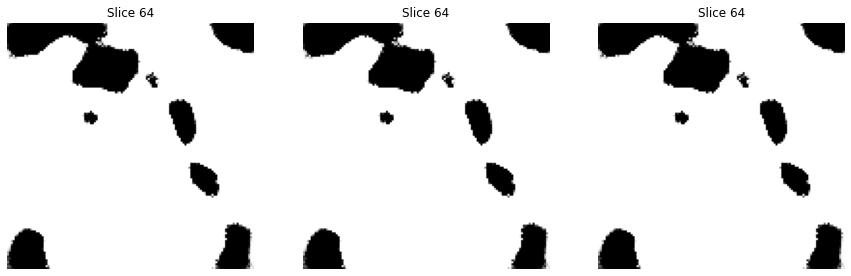

Epoch 59/1900: 100%|██████████| 106/106 [04:57<00:00,  2.80s/batch, D Loss=2.8722, G Loss=8350.3164, Proj Loss=3939.3127, Shape Loss=0.0370, Adv Loss=0.8087]


(128, 128, 128)
<class 'numpy.ndarray'>


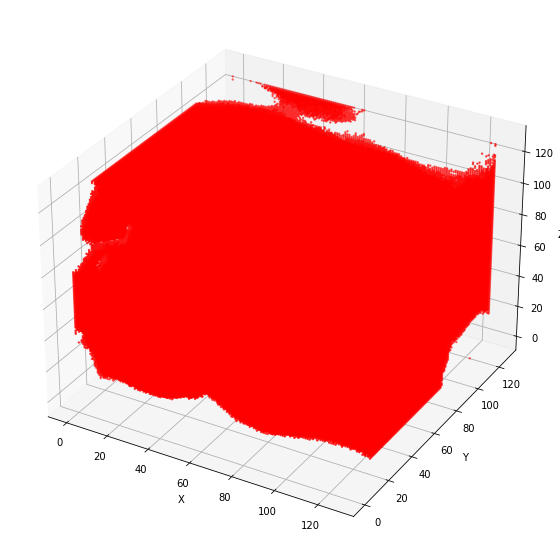

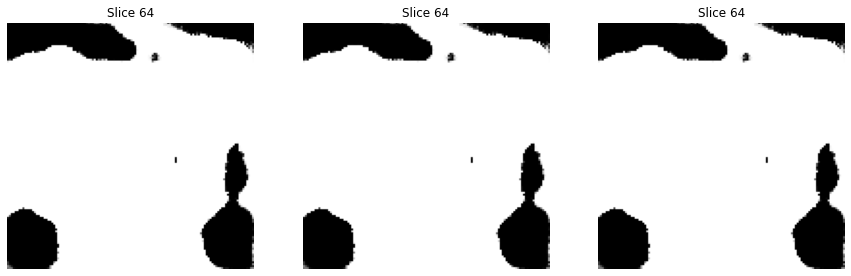

Epoch 60/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8865, G Loss=8852.4043, Proj Loss=4230.2529, Shape Loss=0.0327, Adv Loss=0.7841]


(128, 128, 128)
<class 'numpy.ndarray'>


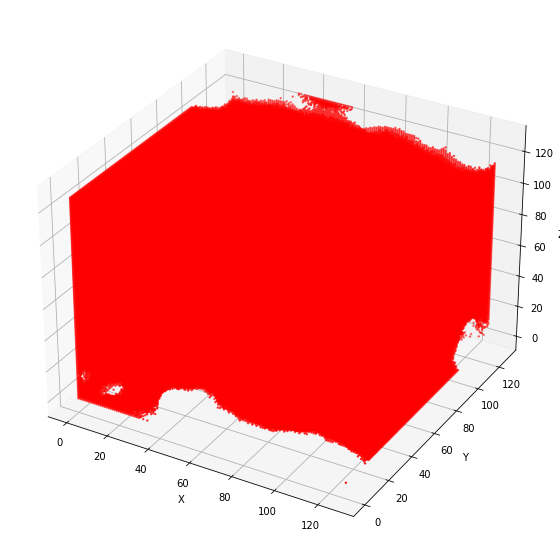

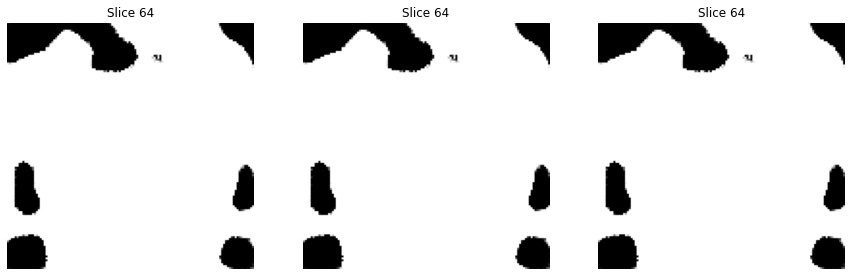

Epoch 61/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8924, G Loss=8525.7695, Proj Loss=4109.1680, Shape Loss=0.0319, Adv Loss=0.7905]


(128, 128, 128)
<class 'numpy.ndarray'>


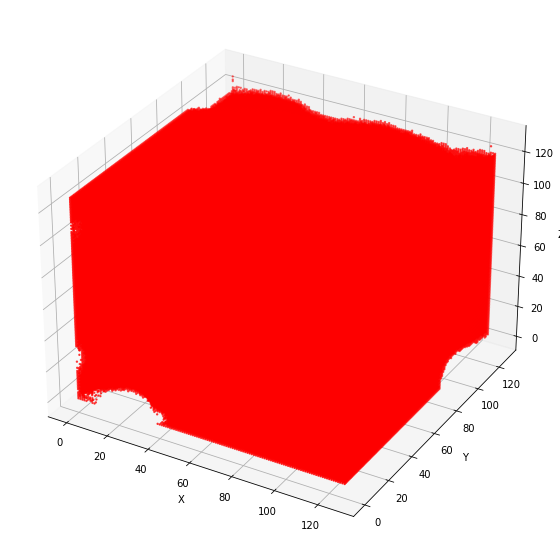

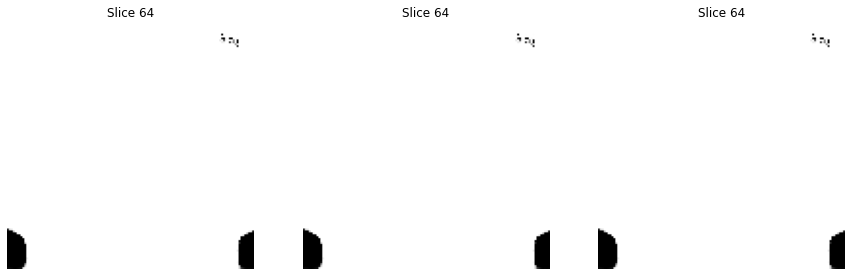

Epoch 62/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8983, G Loss=9277.2578, Proj Loss=4444.7168, Shape Loss=0.0302, Adv Loss=0.7795]


(128, 128, 128)
<class 'numpy.ndarray'>


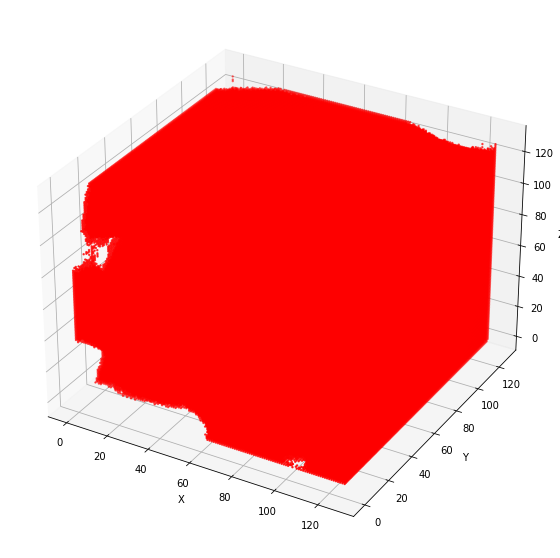

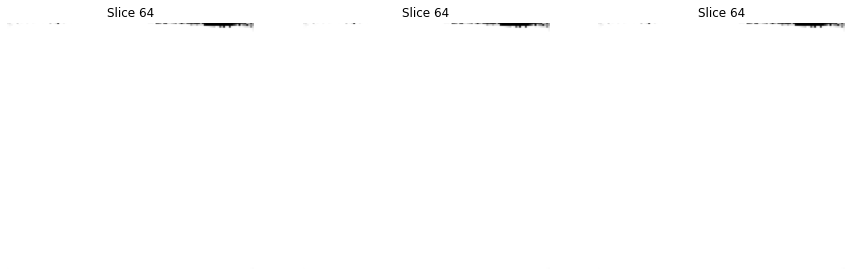

Epoch 63/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9038, G Loss=8541.1455, Proj Loss=4211.9482, Shape Loss=0.0320, Adv Loss=0.7829]


(128, 128, 128)
<class 'numpy.ndarray'>


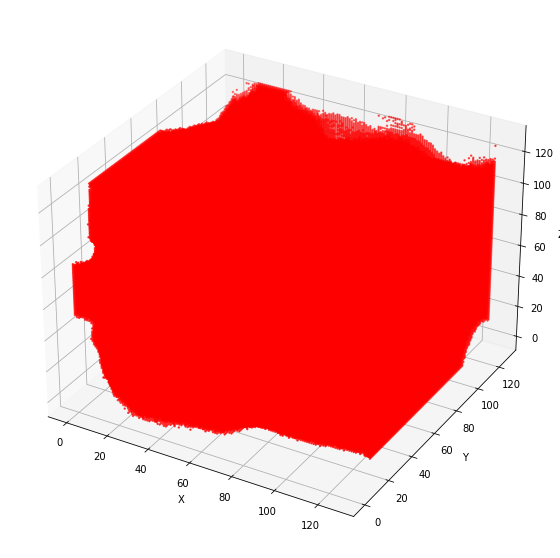

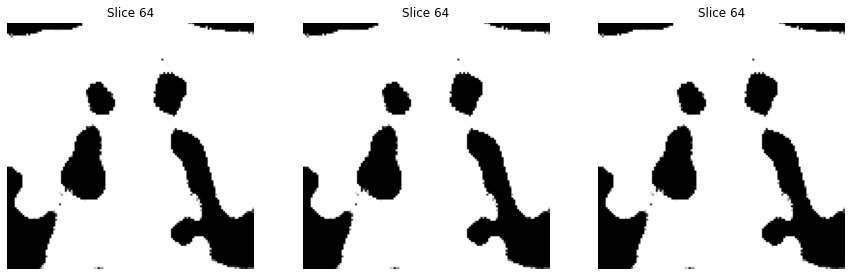

Epoch 64/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.9205, G Loss=8703.1084, Proj Loss=4146.1343, Shape Loss=0.0253, Adv Loss=0.7651]


(128, 128, 128)
<class 'numpy.ndarray'>


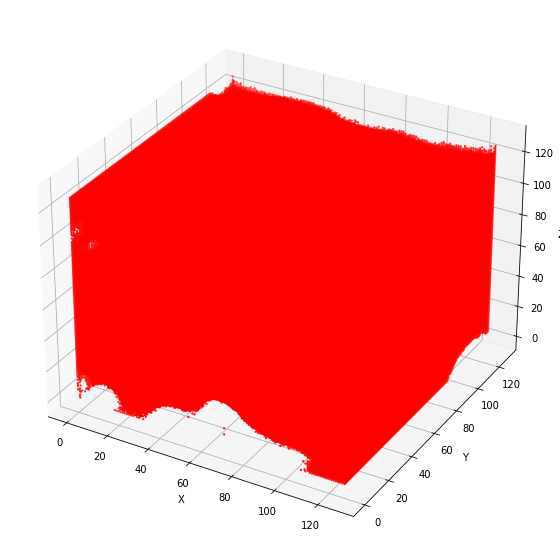

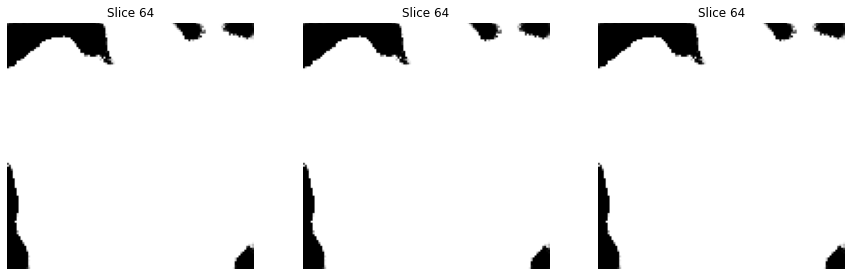

Epoch 65/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.9030, G Loss=8432.4932, Proj Loss=3998.6418, Shape Loss=0.0317, Adv Loss=0.7838]


(128, 128, 128)
<class 'numpy.ndarray'>


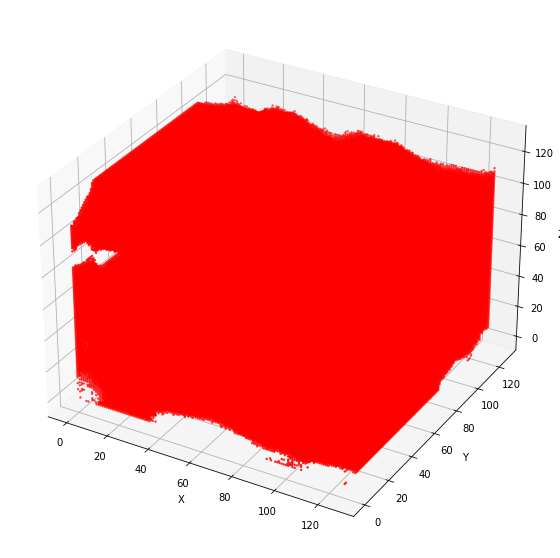

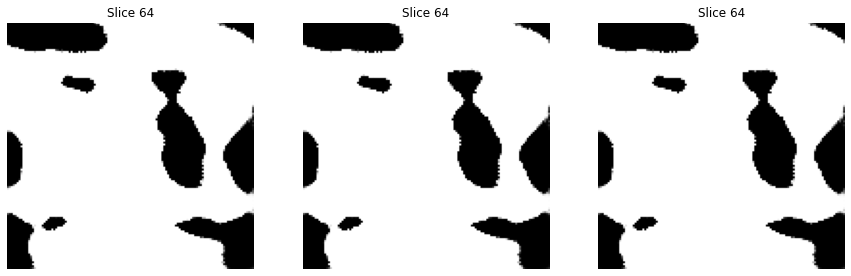

Epoch 66/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.8958, G Loss=8416.6777, Proj Loss=3997.0972, Shape Loss=0.0290, Adv Loss=0.7783]


(128, 128, 128)
<class 'numpy.ndarray'>


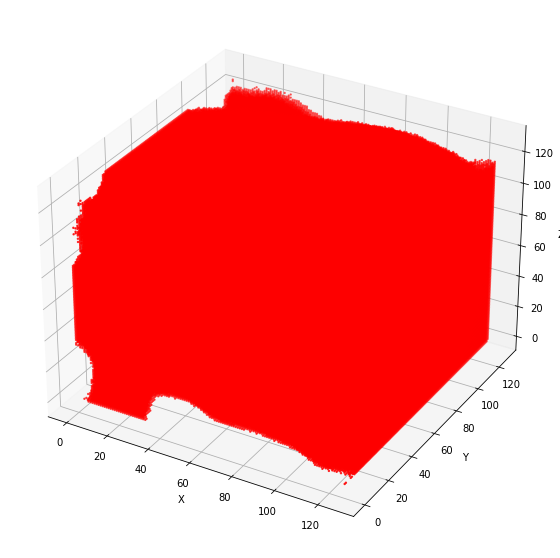

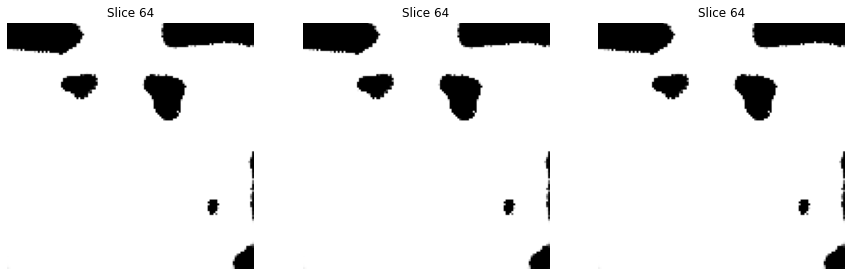

Epoch 67/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.8903, G Loss=8108.0430, Proj Loss=4027.1201, Shape Loss=0.0367, Adv Loss=0.8035]


(128, 128, 128)
<class 'numpy.ndarray'>


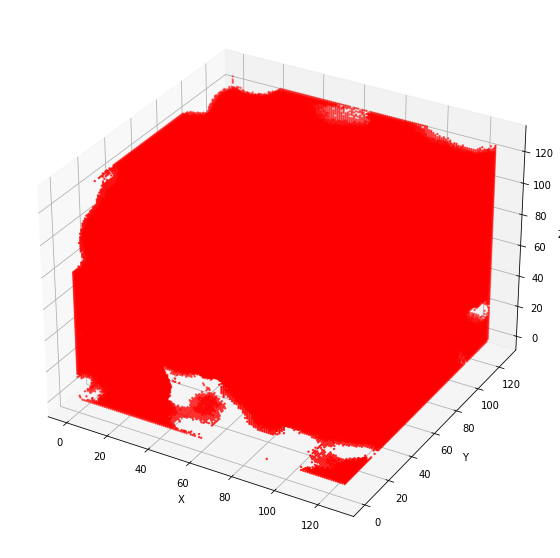

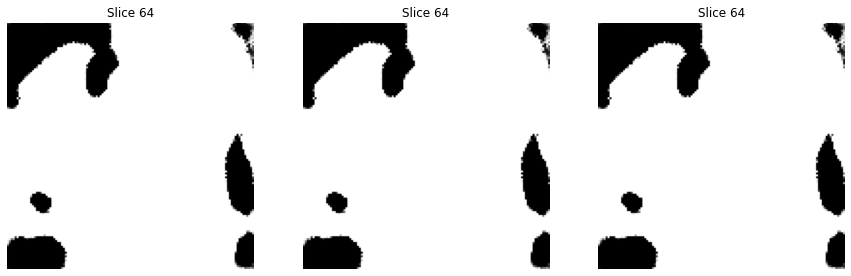

Epoch 68/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=2.8864, G Loss=8497.6465, Proj Loss=4085.0510, Shape Loss=0.0334, Adv Loss=0.7934]


(128, 128, 128)
<class 'numpy.ndarray'>


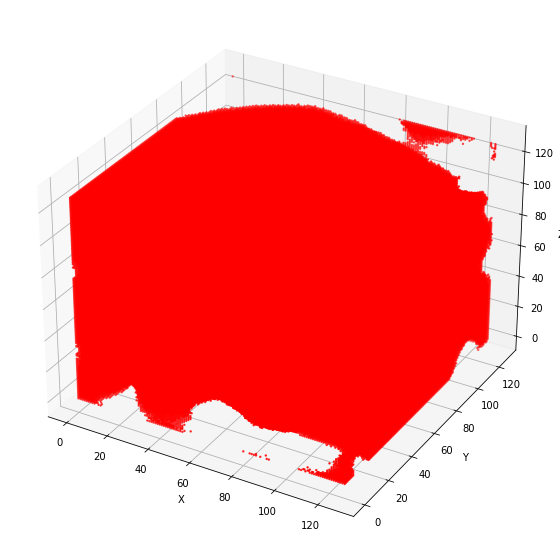

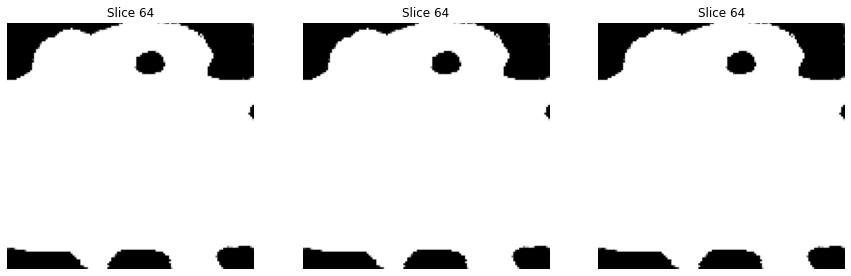

Epoch 69/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.9057, G Loss=8749.5146, Proj Loss=4327.4756, Shape Loss=0.0302, Adv Loss=0.7785]


(128, 128, 128)
<class 'numpy.ndarray'>


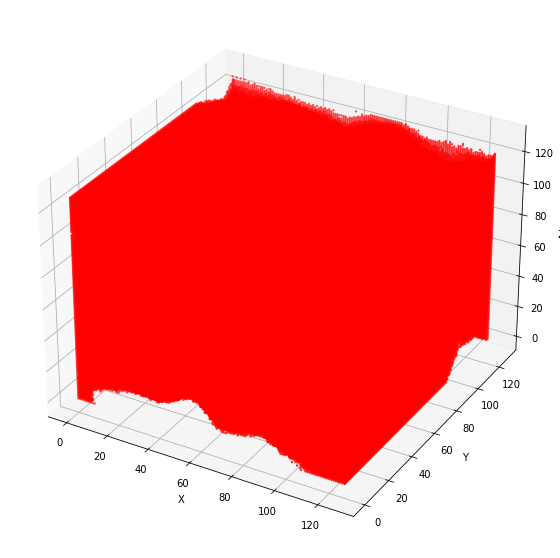

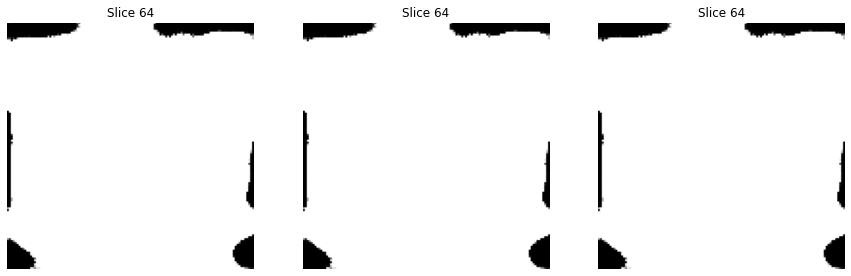

Epoch 70/1900: 100%|██████████| 106/106 [04:56<00:00,  2.80s/batch, D Loss=2.9031, G Loss=8807.3545, Proj Loss=4368.7314, Shape Loss=0.0297, Adv Loss=0.7821]


(128, 128, 128)
<class 'numpy.ndarray'>


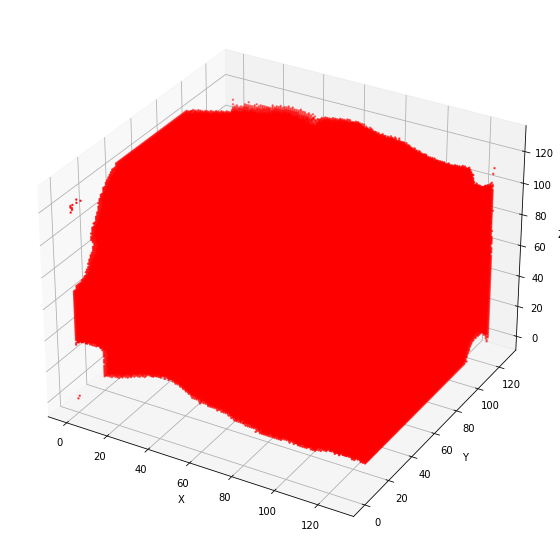

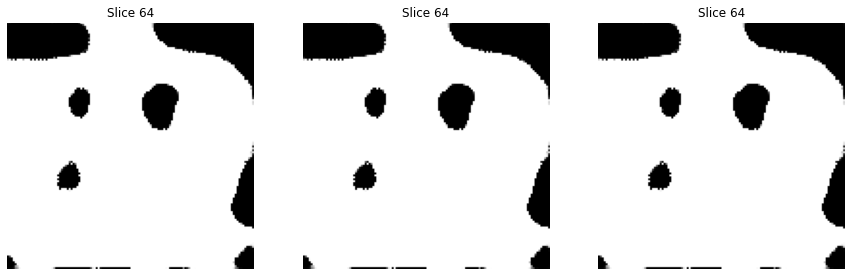

Epoch 71/1900: 100%|██████████| 106/106 [04:56<00:00,  2.79s/batch, D Loss=2.9110, G Loss=8607.0918, Proj Loss=4155.9053, Shape Loss=0.0327, Adv Loss=0.7892]


(128, 128, 128)
<class 'numpy.ndarray'>


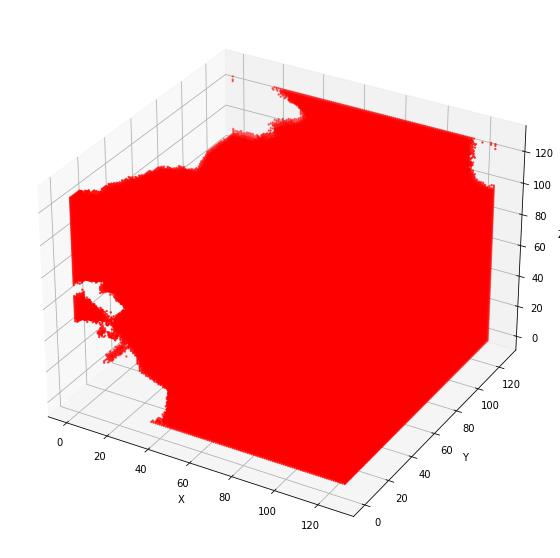

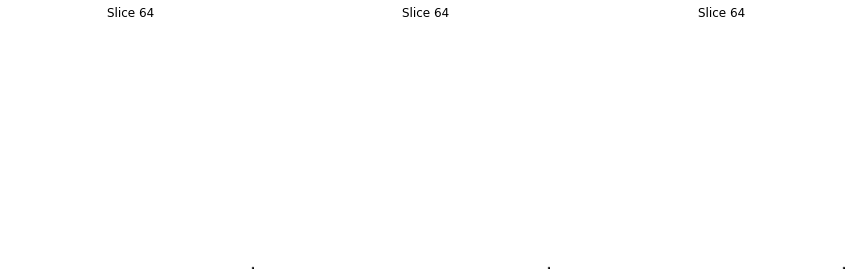

Epoch 72/1900:  61%|██████▏   | 65/106 [03:00<01:53,  2.78s/batch, D Loss=2.8992, G Loss=9085.3926, Proj Loss=4523.4434, Shape Loss=0.0316, Adv Loss=0.7839]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 72/1900:  62%|██████▏   | 66/106 [03:03<01:51,  2.78s/batch, D Loss=2.8802, G Loss=8721.6084, Proj Loss=4292.2954, Shape Loss=0.0329, Adv Loss=0.7975]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 72/1900:  64%|██████▍   | 68/106 [03:09<01:46,  2.81s/batch, D Loss=2.8893, G Loss=8525.4209, Proj Loss=4364.0693, Shape Loss=0.0323, Adv Loss=0.7900]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 72/1900:  75%|███████▍  | 79/106 [03:39<01:15,  2.81s/batch, D Loss=2.8935, G Loss=8856.9395, Proj Loss=4178.1396, Shape Loss=0.0277, Adv Loss=0.7787]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 72/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]                    


(128, 128, 128)
<class 'numpy.ndarray'>


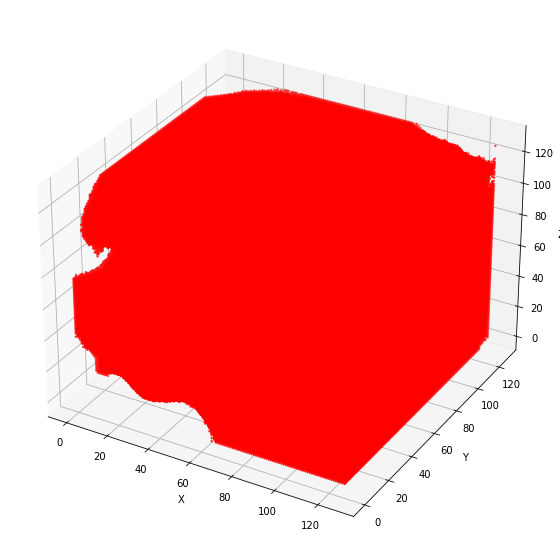

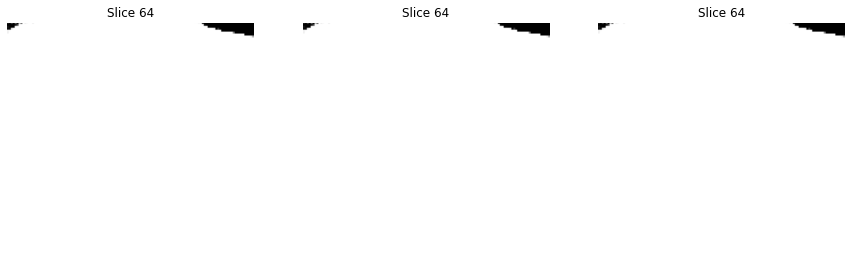

Epoch 73/1900:  12%|█▏        | 13/106 [00:35<04:14,  2.74s/batch, D Loss=2.8861, G Loss=8052.6924, Proj Loss=4169.0479, Shape Loss=0.0348, Adv Loss=0.7979]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 73/1900:  39%|███▊      | 41/106 [01:54<03:03,  2.82s/batch, D Loss=2.8892, G Loss=8758.2363, Proj Loss=4416.4834, Shape Loss=0.0334, Adv Loss=0.7941]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 73/1900:  55%|█████▍    | 58/106 [02:41<02:14,  2.80s/batch, D Loss=2.8849, G Loss=8974.5684, Proj Loss=4551.0010, Shape Loss=0.0336, Adv Loss=0.7975]

Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.
Zero gradients detected.


Epoch 73/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]                    


(128, 128, 128)
<class 'numpy.ndarray'>


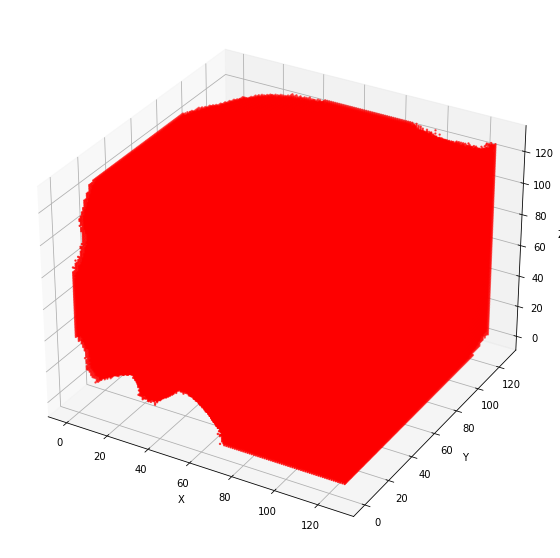

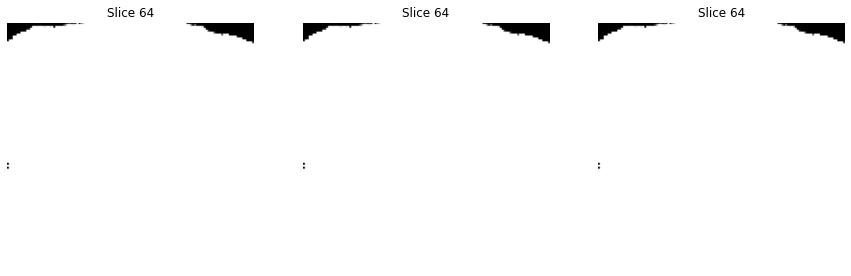

Epoch 74/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]                     


(128, 128, 128)
<class 'numpy.ndarray'>


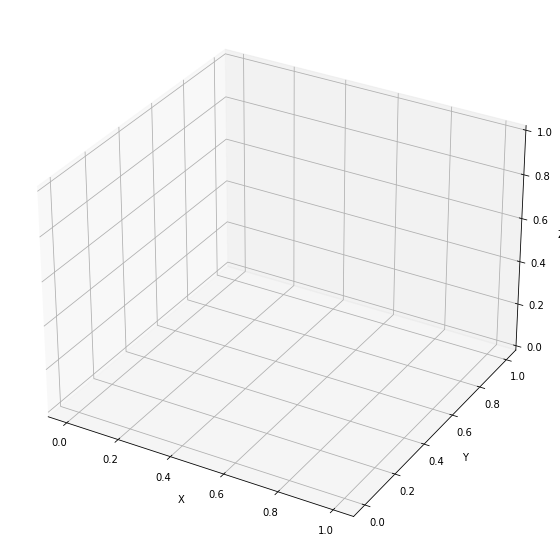

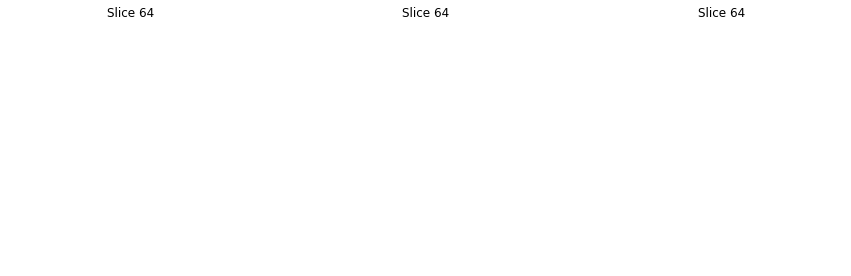

Epoch 75/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


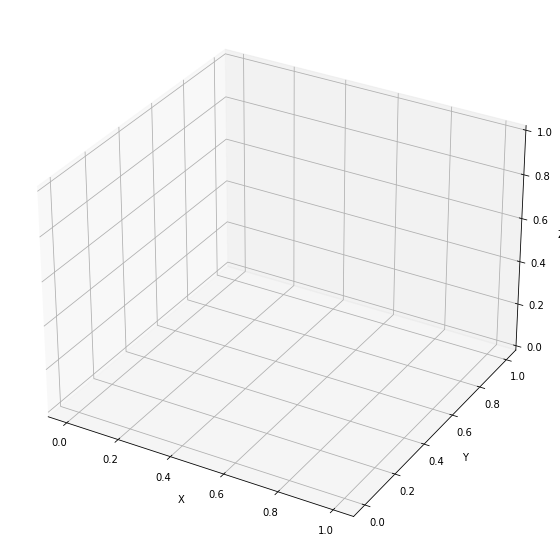

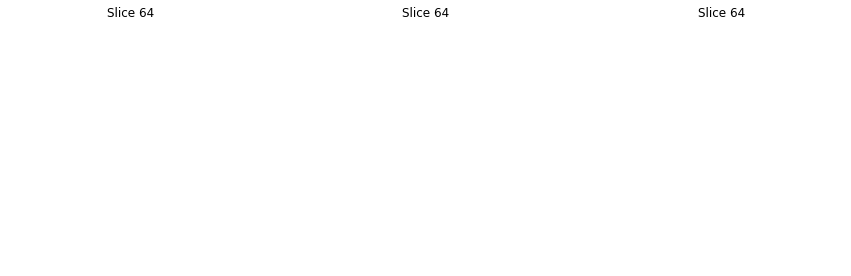

Epoch 76/1900: 100%|██████████| 106/106 [04:53<00:00,  2.77s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


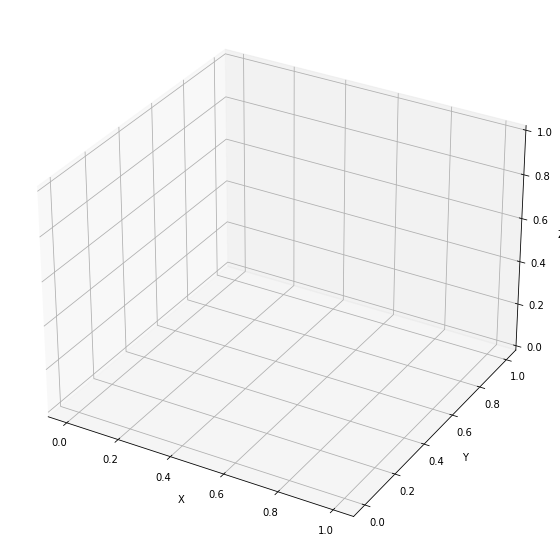

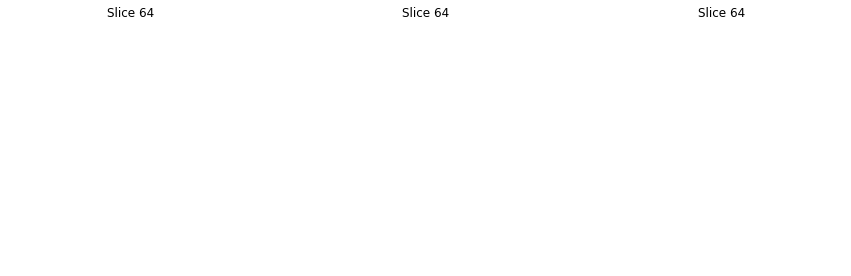

Epoch 77/1900: 100%|██████████| 106/106 [04:52<00:00,  2.76s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


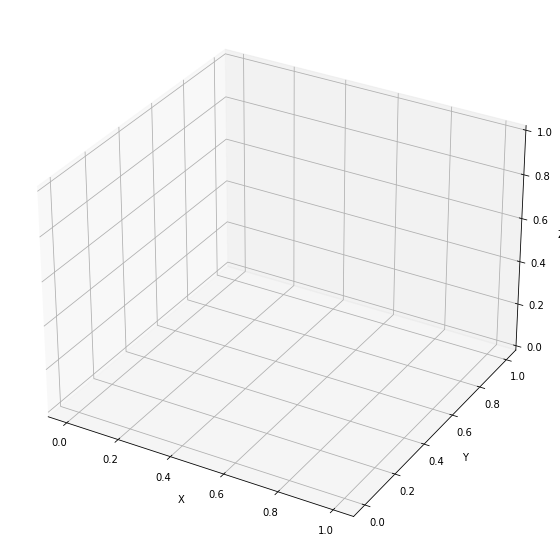

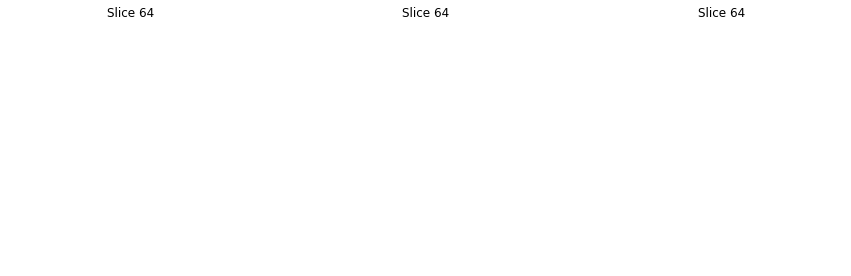

Epoch 78/1900: 100%|██████████| 106/106 [04:52<00:00,  2.76s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


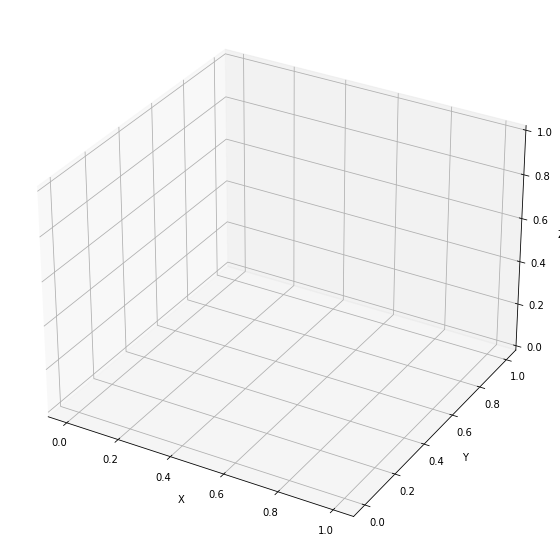

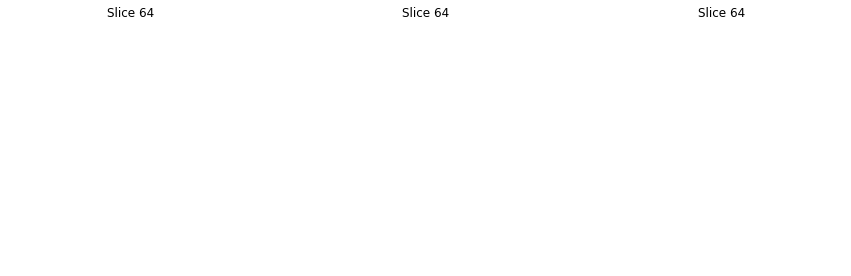

Epoch 79/1900: 100%|██████████| 106/106 [04:53<00:00,  2.77s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


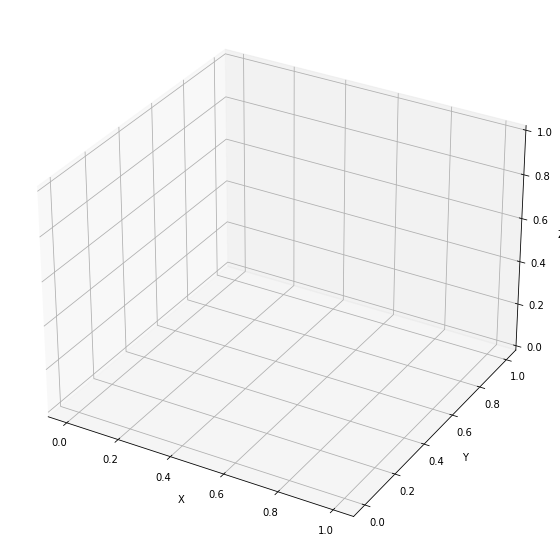

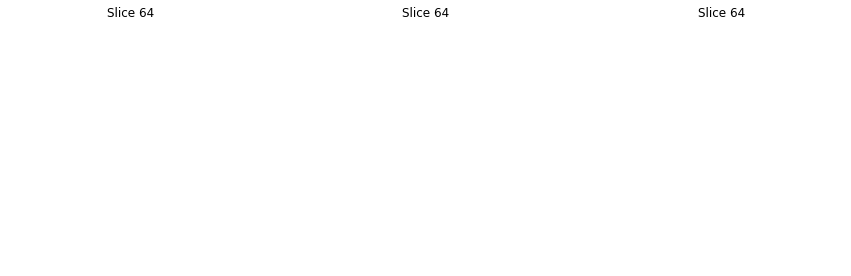

Epoch 80/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


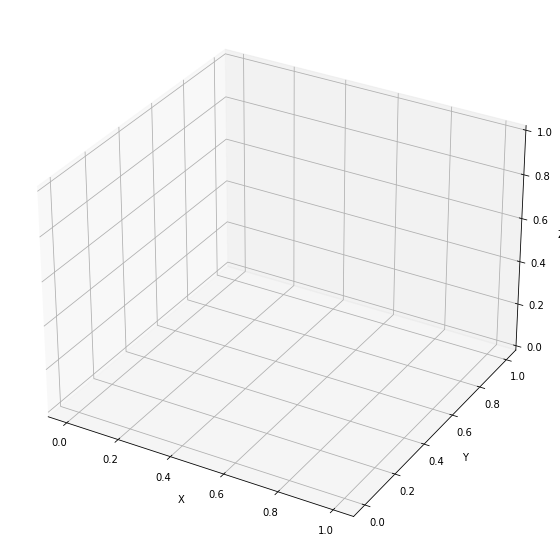

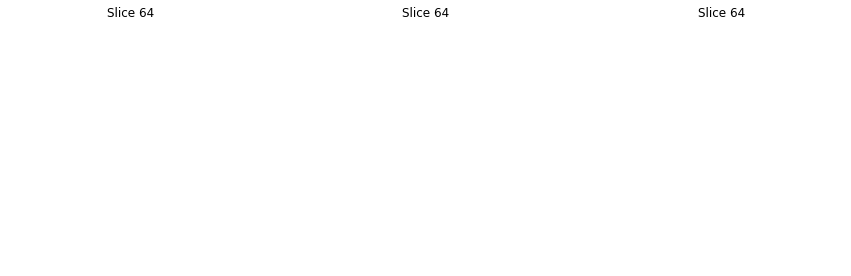

Epoch 81/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


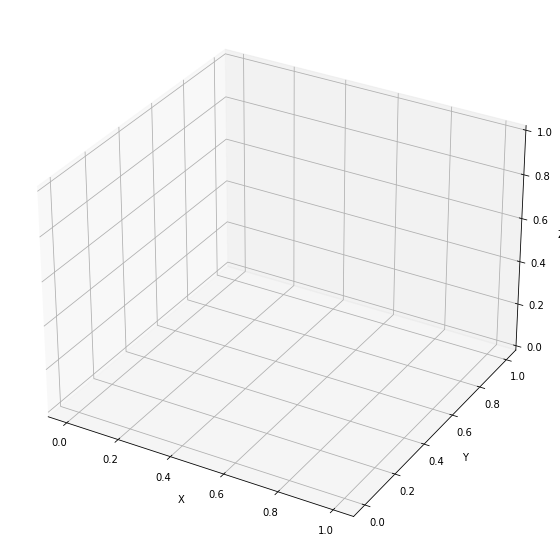

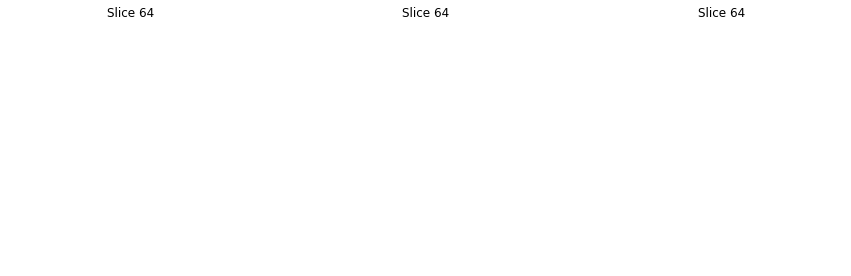

Epoch 82/1900: 100%|██████████| 106/106 [04:55<00:00,  2.79s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


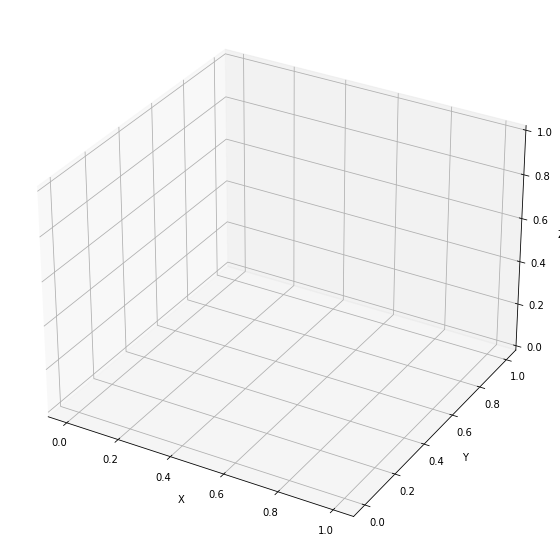

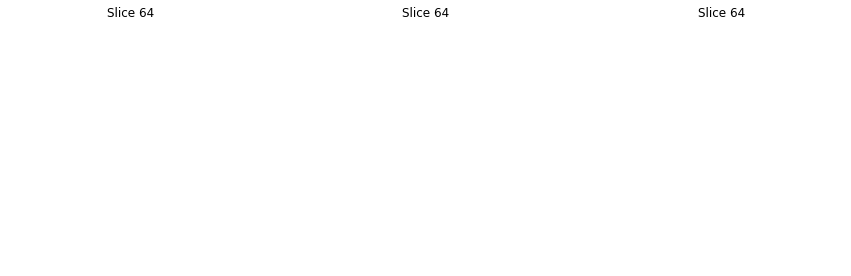

Epoch 83/1900: 100%|██████████| 106/106 [04:54<00:00,  2.77s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


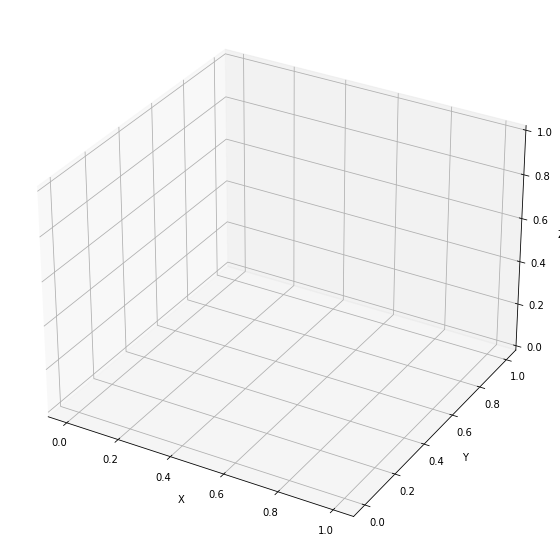

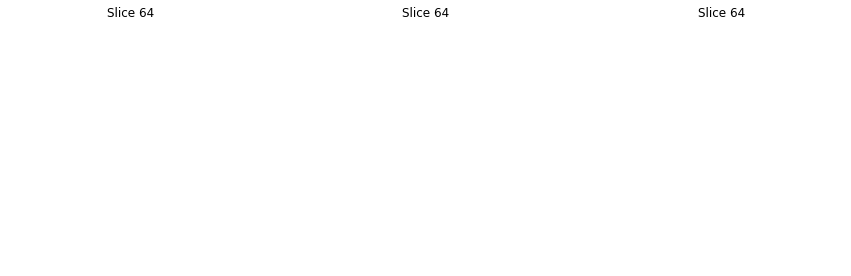

Epoch 84/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


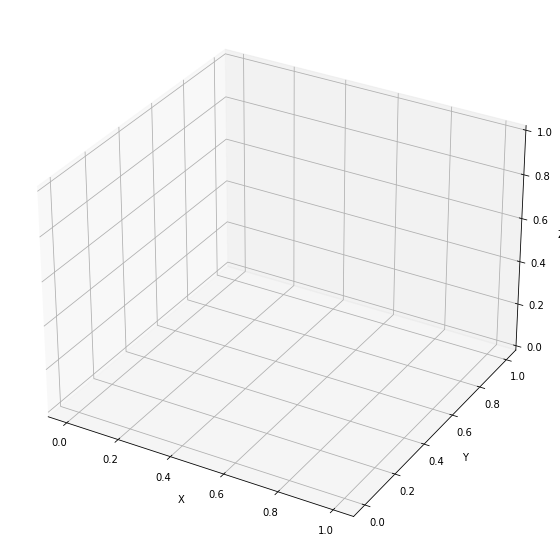

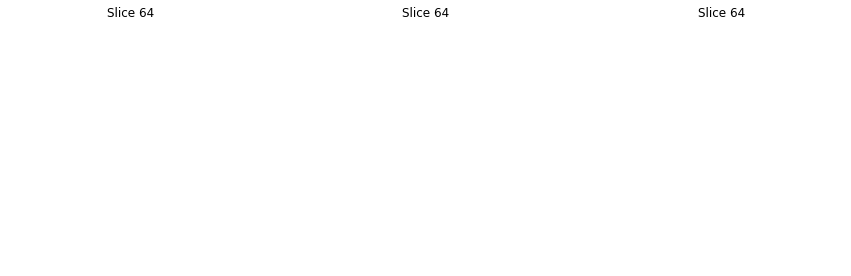

Epoch 85/1900: 100%|██████████| 106/106 [04:54<00:00,  2.78s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


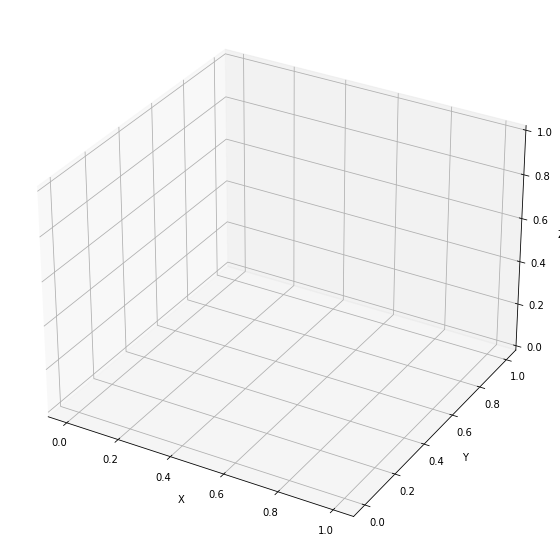

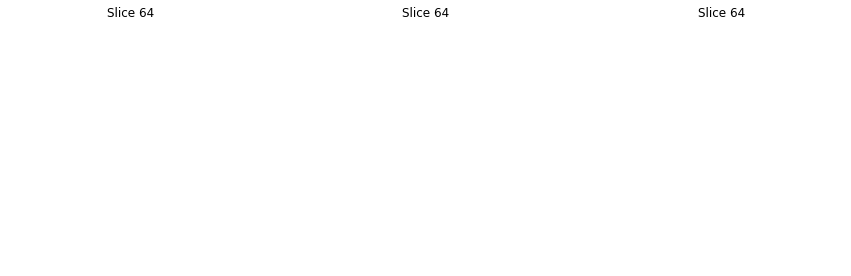

Epoch 86/1900: 100%|██████████| 106/106 [04:55<00:00,  2.78s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]


(128, 128, 128)
<class 'numpy.ndarray'>


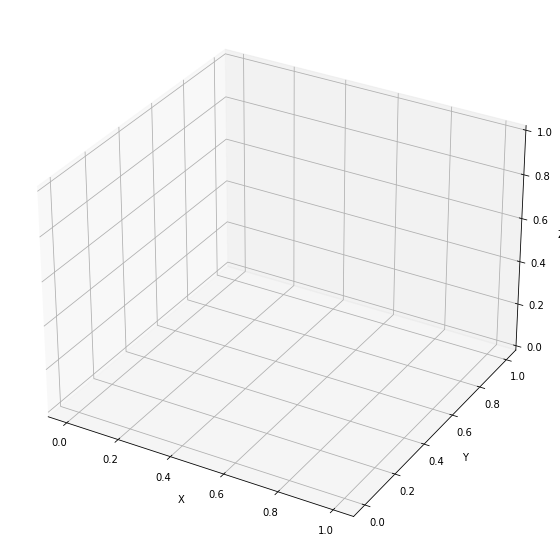

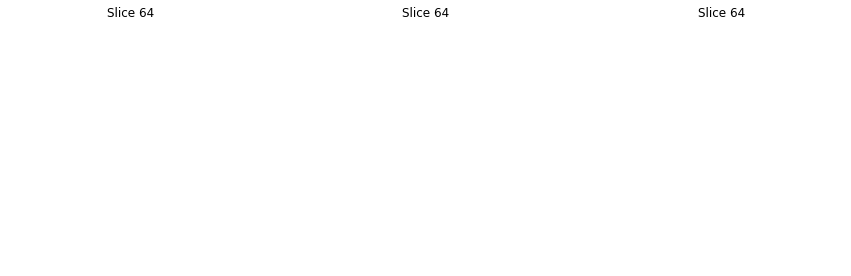

Epoch 87/1900:  48%|████▊     | 51/106 [02:21<02:31,  2.76s/batch, D Loss=nan, G Loss=nan, Proj Loss=nan, Shape Loss=nan, Adv Loss=nan]

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast  
from tqdm import tqdm 
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
####################
# Dataset Class 
####################


class XRayDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        """
        Initializes dataset with CSV file and image folder.
        """
        self.csv = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform
        self.pairs = self.csv.groupby('uid')
        self.valid_uids = self.check_integrity()

    def check_integrity(self):
        """
        Ensure we have both 'Frontal' and 'Lateral' images for each UID.
        """
        valid_uids = []
        for uid, group in self.pairs:
            frontal_data = group[group['projection'] == 'Frontal']
            lateral_data = group[group['projection'] == 'Lateral']
            if not frontal_data.empty and not lateral_data.empty:
                valid_uids.append(uid)
        return valid_uids

    def __len__(self):
        return len(self.valid_uids)

    def __getitem__(self, idx):
        """
        Fetch the images for a specific UID.
        """
        group_key = self.valid_uids[idx]
        uid = self.pairs.get_group(group_key)

        frontal_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Frontal']['filename'].values[0])
        lateral_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Lateral']['filename'].values[0])

        frontal_img = cv2.imread(frontal_img_path)
        lateral_img = cv2.imread(lateral_img_path)

        if frontal_img is None or lateral_img is None:
            print(f"Error reading image: {frontal_img_path if frontal_img is None else lateral_img_path}")
            return None, None 

        frontal_img_resized = cv2.resize(frontal_img, (512, 512))
        lateral_img_resized = cv2.resize(lateral_img, (512, 512))

        frontal_img_tensor = torch.tensor(cv2.cvtColor(frontal_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        lateral_img_tensor = torch.tensor(cv2.cvtColor(lateral_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        frontal_img_tensor = frontal_img_tensor.permute(2, 0, 1)  
        lateral_img_tensor = lateral_img_tensor.permute(2, 0, 1)  


        return frontal_img_tensor, lateral_img_tensor

############################
# Image Encoder Definition #
############################

class SimpleImageEncoder(nn.Module):
    """
    A simple encoder that reduces a 512x512 image to a latent vector.
    You might replace this with a stronger backbone (e.g., ResNet50).
    """
    def __init__(self, latent_dim=512):
        super(SimpleImageEncoder, self).__init__()
        # A small CNN as a placeholder
        # Input: [B, 3, 512, 512]
        # Output: [B, latent_dim]
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # [B, 32, 256, 256]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # [B, 64, 128, 128]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),# [B,128, 64, 64]
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),# [B,256,32,32]
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1),# [B,512,16,16]
            nn.ReLU(True),
            nn.Conv2d(512, 512, 4, 2, 1),# [B,512,8,8]
            nn.ReLU(True),
            nn.Conv2d(512, 512, 4, 2, 1),# [B,512,4,4]
            nn.ReLU(True),
        )
        self.fc = nn.Linear(512*4*4, latent_dim)

    def forward(self, x):
        feat = self.features(x)
        feat = feat.view(feat.size(0), -1)
        feat = self.fc(feat)
        return feat

#######################
# Fusion Layer         #
#######################

class ViewFusion(nn.Module):
    """
    Fuse two latent vectors (from the frontal and lateral images).
    """
    def __init__(self, in_dim=512, out_dim=512):
        super(ViewFusion, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim*2, 512),
            nn.ReLU(True),
            nn.Linear(512, out_dim)
        )

    def forward(self, f_feat, l_feat):
        fused = torch.cat([f_feat, l_feat], dim=1)
        return self.fc(fused)

##########################
# 3D Voxel Decoder       #
##########################

class VoxelGenerator(nn.Module):
    """
    Decode a latent vector into a 3D voxel grid [B,1,128,128,128].
    We'll start from a small 3D latent representation and upsample.
    """
    def __init__(self, latent_dim=512, base_size=8, final_size=128):
        super(VoxelGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.base_size = base_size
        self.final_size = final_size

        # Number of upsampling steps from base_size to final_size:
        # base_size = 8, final_size = 128, we need 4x upscale steps (8->16->32->64->128)
        # We'll start from a latent vector and reshape to [B,512,8,8,8]

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * base_size * base_size * base_size),
            nn.ReLU(True)
        )

        # Upsample in 3D using ConvTranspose3d
        # Input: [B,512,8,8,8]
        # Steps: (512->256->128->64->1) with doubling spatial dims each step
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, 4, stride=2, padding=1), # 8->16
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, 4, stride=2, padding=1), #16->32
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 64, 4, stride=2, padding=1),  #32->64
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 32, 4, stride=2, padding=1),   #64->128
            nn.ReLU(True),
            nn.Conv3d(32, 1, 3, padding=1), # [B,1,128,128,128]
            nn.Sigmoid() 
        )

    def forward(self, z):
        base = self.fc(z) 
        base = base.view(-1, 512, self.base_size, self.base_size, self.base_size)
        voxels = self.decoder(base) 
        return voxels

##########################
# Full Generator Module  #
##########################

class Generator(nn.Module):
    """
    The full generator: encodes frontal and lateral images into latent codes,
    fuses them, and decodes into a 3D voxel volume.
    """
    def __init__(self, latent_dim=512):
        super(Generator, self).__init__()
        self.encoder = SimpleImageEncoder(latent_dim=latent_dim)
        self.fusion = ViewFusion(in_dim=latent_dim, out_dim=latent_dim)
        self.voxel_gen = VoxelGenerator(latent_dim=latent_dim, base_size=8, final_size=128)

    def forward(self, front_img, lat_img):
        # front_img, lat_img: [B,3,512,512]
        f_feat = self.encoder(front_img)  # [B,latent_dim]
        l_feat = self.encoder(lat_img)    # [B,latent_dim]
        z = self.fusion(f_feat, l_feat)   # [B,latent_dim]
        voxels = self.voxel_gen(z)        # [B,1,128,128,128]
        return voxels    
    
    
# ####################
# # Generator3D 
# ####################
# class Generator3D(nn.Module):
#     def __init__(self, input_channels=3, latent_dim=128, intermediate_size=8, output_size=128):
#         super(Generator3D, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#         )

#         self.global_avg_pool = nn.AdaptiveAvgPool2d((intermediate_size, intermediate_size))
#         self.latent_fc = nn.Linear(512 * intermediate_size * intermediate_size, latent_dim * intermediate_size**3)

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose3d(latent_dim, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(128),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(64),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(32),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, frontal, lateral):
#         # Process frontal and lateral images separately
#         frontal_features = self.encoder(frontal)
#         lateral_features = self.encoder(lateral)
#         combined_features = torch.cat((frontal_features, lateral_features), dim=1)
#         pooled_features = self.global_avg_pool(combined_features)
#         pooled_features = pooled_features.view(pooled_features.size(0), -1) 
#         latent_3d = F.relu(self.latent_fc(pooled_features))
#         latent_3d = latent_3d.view(-1, 128, 8, 8, 8)

#         voxel_grid = self.decoder(latent_3d)
#         return voxel_grid

####################
# Discriminator2D
####################
class Discriminator2D(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator2D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d((1,1))  
        )
        
    def forward(self, x):
        out = self.model(x)
        return out.view(-1) 

####################
# Loss Functions
####################
def projection_consistency_loss(generated_3d, frontal_input, lateral_input):
    """
    Calculate loss by comparing projections of the generated 3D shape 
    with the input frontal and lateral images.
    """
    frontal_input = frontal_input.mean(dim=1, keepdim=True)
    lateral_input = lateral_input.mean(dim=1, keepdim=True) 
    frontal_projection = torch.sum(generated_3d, dim=2)
    lateral_projection = torch.sum(generated_3d, dim=4) 

    frontal_projection = F.interpolate(frontal_projection, size=(512, 512), mode="bilinear", align_corners=False)
    lateral_projection = F.interpolate(lateral_projection, size=(512, 512), mode="bilinear", align_corners=False)

    frontal_loss = F.mse_loss(frontal_projection, frontal_input)
    lateral_loss = F.mse_loss(lateral_projection, lateral_input)

    return frontal_loss , lateral_loss, frontal_projection, lateral_projection

def shape_coherence_loss(generated_3d):
    """
    Regularize the 3D shape using Total Variation (TV) Loss to ensure smoothness.
    """
    # Differences along each dimension (TV loss components)
    dx = torch.abs(generated_3d[:, :, 1:, :, :] - generated_3d[:, :, :-1, :, :]).mean()
    dy = torch.abs(generated_3d[:, :, :, 1:, :] - generated_3d[:, :, :, :-1, :]).mean()
    dz = torch.abs(generated_3d[:, :, :, :, 1:] - generated_3d[:, :, :, :, :-1]).mean()
    
    # Total TV loss
    return dx + dy + dz

def adversarial_loss(disc_output, target_is_real=True):
    if target_is_real:
        # target of 1.0 for real
        targets = torch.ones_like(disc_output, device=disc_output.device)
    else:
        # target of 0.0 for fake
        targets = torch.zeros_like(disc_output, device=disc_output.device)
    return F.binary_cross_entropy_with_logits(disc_output, targets)

def compute_snr(real_img, fake_img):
    # Both in same scale, assume normalized 0-1
    mse = torch.mean((real_img - fake_img)**2)
    signal_power = torch.mean(real_img**2)
    if mse == 0:
        return float('inf')
    snr_value = 10 * math.log10((signal_power / mse).item())
    return snr_value

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# def visualize_slices(voxel_grid):
#     """
#     Visualize three slices of the voxel grid.
#     voxel_grid: numpy array (D, H, W)
#     """
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#     for i, idx in enumerate([32, 64, 96]):
#         axs[i].imshow(voxel_grid[idx, :, :], cmap='gray')
#         axs[i].set_title(f"Slice {idx}")
#         axs[i].axis('off')
#     plt.show()

def visualize_slices(voxel_grid):
    """
    Visualize a single slice of the voxel grid.
    If the input is 3D (D, H, W), it will visualize one slice from the middle of the depth.
    If the input is 2D (H, W), it will visualize the whole image.

    voxel_grid: numpy array (D, H, W) or (H, W)
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if len(voxel_grid.shape) == 3:  # If it's a 3D voxel grid (D, H, W)
        middle_depth = voxel_grid.shape[0] // 2  # Take the middle slice
        for i in range(3):
            axs[i].imshow(voxel_grid[middle_depth, :, :], cmap='gray')
            axs[i].set_title(f"Slice {middle_depth}")
            axs[i].axis('off')
    elif len(voxel_grid.shape) == 2:  # If it's a 2D grid (H, W)
        axs[0].imshow(voxel_grid, cmap='gray')
        axs[0].set_title(f"Full Slice")
        axs[0].axis('off')
        for i in range(1, 3):
            axs[i].axis('off')
            axs[i].set_title("N/A")
    else:
        raise ValueError("Input voxel_grid must have 2 or 3 dimensions")

    plt.show()


def visualize_3d(voxel_grid):
    """
    Visualize voxel grid as a 3D scatter plot of points above a certain threshold.
    voxel_grid: numpy array (D, H, W)
    """
    binary_grid = (voxel_grid > 0.5).astype(int)
    x, y, z = np.where(binary_grid == 1)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, zdir='z', c='red', s=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paths and parameters
    img_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/images/images_normalized/'
    csv_file = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/indiana_projections.csv'
#     Adwait/yay/indiana_projections.csv
    batch_size = 32
    num_epochs = 1900
    lambda_proj = 1.0
    lambda_shape = 1.0
    lambda_adv = 0.00001

    dataset = XRayDataset(csv_file=csv_file, img_folder=img_folder)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = Generator().to(device)
    discriminator = Discriminator2D(input_channels=3).to(device)
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    scaler = GradScaler()
    dscaler = GradScaler()
    g_optimizer = torch.optim.AdamW(generator.parameters(), lr=1e-5, betas=(0.9, 0.999))
    d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))
    all_loss_history = {
    "D Real Frontal Loss": [],
    "D Real Lateral Loss": [],
    "D Fake Frontal Loss": [],
    "D Fake Lateral Loss": [],
    "D Total Loss": [],
    "G Adversarial Loss": [],
    "G Projection Loss": [],
    "G Shape Coherence Loss": [],
    "G Total Loss": [],
    }

# Training loop
    best_loss = float('inf')
    best_loss_G = float('inf')
    best_loss_S = float('inf')
    best_loss_A = float('inf')
    for epoch in range(num_epochs):
        with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as tepoch:
            for i, (frontal_img_tensor, lateral_img_tensor) in enumerate(tepoch):
                frontal_img_tensor = frontal_img_tensor.to(device)
                lateral_img_tensor = lateral_img_tensor.to(device)

                # ----------------------
                # Train Discriminator
                # ----------------------
                d_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Real losses
                    real_frontal_out = discriminator(frontal_img_tensor)
                    d_real_frontal_loss = adversarial_loss(real_frontal_out, target_is_real=True)

                    real_lateral_out = discriminator(lateral_img_tensor)
                    d_real_lateral_loss = adversarial_loss(real_lateral_out, target_is_real=True)

                    # Fake losses
#                     with torch.no_grad():
                    generated_3d = generator(frontal_img_tensor, lateral_img_tensor)
                    _,_, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)

                    fake_frontal_out = discriminator(fake_frontal_proj)
                    d_fake_frontal_loss = adversarial_loss(fake_frontal_out, target_is_real=False)

                    fake_lateral_out = discriminator(fake_lateral_proj)
                    d_fake_lateral_loss = adversarial_loss(fake_lateral_out, target_is_real=False)

                    # Total discriminator loss
                    d_loss = (
                        d_real_frontal_loss + d_real_lateral_loss + d_fake_frontal_loss + d_fake_lateral_loss
                    )
#                     d_loss += 1e-4 * sum(p.pow(2.0).sum() for p in discriminator.parameters())

                # Backpropagate and update discriminator
#                 scaler.scale(d_loss).backward(retain_graph=True)
#                 scaler.step(d_optimizer)
#                 scaler.update()

                # ----------------------
                # Train Generator
                # ----------------------
                g_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Projection and shape losses
                    proj_loss_f, proj_loss_l, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    shape_loss = shape_coherence_loss(generated_3d)

                    # Adversarial loss
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)
                    g_frontal_out = discriminator(fake_frontal_proj)
                    g_lateral_out = discriminator(fake_lateral_proj)
                    g_adv_loss = (adversarial_loss(g_frontal_out, target_is_real=True) +
                                adversarial_loss(g_lateral_out, target_is_real=True)) / 2

                    # Dynamic loss weights
#                     lambda_proj = 1.0 / (proj_loss.item() + 1e-8)
#                     lambda_shape = 0.1 / (shape_loss.item() + 1e-8)
#                     lambda_adv = 1.0 / (g_adv_loss.item() + 1e-8)
#                     total_weight = lambda_proj + lambda_shape + lambda_adv
#                     lambda_proj /= total_weight
#                     lambda_shape /= total_weight
#                     lambda_adv /= total_weight

                    # Total generator loss
                    total_g_loss = lambda_adv * g_adv_loss + lambda_proj * proj_loss_f + lambda_shape * proj_loss_l
#                     print(total_g_loss)
#                     total_g_loss += 1e-4 * sum(p.pow(2.0).sum() for p in generator.parameters())

                # Backpropagate and update generator
                scaler.scale(total_g_loss).backward()
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)  
                scaler.step(g_optimizer)
                scaler.update()
                
                #----------------------
                # Store all Losses
                #----------------------
                
                all_loss_history["D Real Frontal Loss"].append(d_real_frontal_loss.item())
                all_loss_history["D Real Lateral Loss"].append(d_real_lateral_loss.item())
                all_loss_history["D Fake Frontal Loss"].append(d_fake_frontal_loss.item())
                all_loss_history["D Fake Lateral Loss"].append(d_fake_lateral_loss.item())
                all_loss_history["D Total Loss"].append(d_loss.item())
                all_loss_history["G Adversarial Loss"].append(g_adv_loss.item())
                all_loss_history["G Projection Loss"].append(proj_loss_f.item())
                all_loss_history["G Shape Coherence Loss"].append(shape_loss.item())
                all_loss_history["G Total Loss"].append(total_g_loss.item())


                # ----------------------
                # Update TQDM Postfix
                # ----------------------
                tepoch.set_postfix({
                    "D Loss": f"{d_loss.item():.4f}",
                    "G Loss": f"{total_g_loss.item():.4f}",
                    "Proj Loss": f"{proj_loss_f.item():.4f}",
                    "Shape Loss": f"{shape_loss.item():.4f}",
                    "Adv Loss": f"{g_adv_loss.item():.4f}",
                })
                for param in generator.parameters():
                    if param.grad is not None and torch.all(param.grad == 0):
                        print("Zero gradients detected.")
                        epoch = 0
                with torch.no_grad():
                    output = generator(frontal_img_tensor, lateral_img_tensor)

                # Iterate over the batch
            for i in range(output.shape[0]):
                if i == 1:
                    sample = output[i, :, :, :, :]
                    sample = sample.squeeze().detach().cpu().numpy()
                    print(sample.shape)
                    print(type(sample))
                    voxel_grid = sample
                    visualize_3d(voxel_grid)
                    visualize_slices(voxel_grid)
#                 voxel_grid = output.squeeze().detach().cpu().numpy()  # (D,H,W)
#                 visualize_3d(voxel_grid)

                # Save the best generator
#                 if proj_loss.item() < best_loss:
#                     best_loss = proj_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_projection.pth")
#                 if total_g_loss.item() < best_loss_G:
#                     best_loss = total_g_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_G_Loss.pth")
#                 if shape_loss.item() < best_loss_S:
#                     best_loss = shape_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_Shape_Loss.pth")
#                 if g_adv_loss.item() < best_loss_A:
#                     best_loss = g_adv_loss.item()
#                     torch.save(generator.state_dict(), "best_generator_ADV_Loss.pth")
    torch.save(generator.state_dict(), "best_generator_ADV_Loss.pth")

In [3]:
with torch.no_grad():
    output = generator(frontal_img_tensor, lateral_img_tensor)

# Iterate over the batch
for i in range(output.shape[0]):
    if i == 1:
        sample = output[i, :, :, :, :]
        sample = sample.squeeze().detach().cpu().numpy()
        print(sample.shape)
        print(type(sample))
        voxel_grid = sample
        visualize_3d(voxel_grid)
        visualize_slices(voxel_grid)